<a href="https://colab.research.google.com/github/gflores1092/AnalyticsSX/blob/main/Modelo_de_tallas_por_sku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MODELO PARA CLASIFICACIÓN DE TALLAS DE SKUS**

**Objetivo**

Identificar con una mayor precisión las tallas de productos considerando diversos atributos (features).

**Pasos**

1. Importar librerías de Python necesarias para el procesamiento y generación del modelo.
2. Conectar a BigQuery y ejecutar consultas de información de atributos y tallas con input Seller y/o asignadas por VL.
3. Implementar modelos, optimizar parámetros y analizar resultados.

## **Setup**

In [ ]:
# @title Libraries { display-mode: "form" }

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import math

from scipy.stats.mstats import winsorize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from google.colab import drive
from google.colab import files
from google.colab import auth
from google.colab import syntax
from google.cloud import bigquery

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# @title Google Drive { display-mode: "form" }

# Authentication
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# @title BigQuery { display-mode: "form" }

# Authentication
auth.authenticate_user()

# Project and client
project_id='bi-fcom-drmb-local-pe-sbx'
client = bigquery.Client(project=project_id)

# Job configuration
job_config = bigquery.QueryJobConfig()
job_config.query_parameters = (bigquery.ScalarQueryParameter("limit", "INT64", 1000),)

# Define query
query = """

  SELECT * FROM `bi-fcom-drmb-local-pe-sbx.Dragonite_SX_KPIs.modelo_tallas_skus`
  WHERE shop_sku IN (

'113649524','113649538','113652007','113652045','113654267','113654271','113654299','113654303','113654311','113656036','113677618','113677800','113677802','113677806','113677812','113677816','113678868','113703289','113705712','113705772','113721716','113721961','113722784','113735497','113735518','113838642','113838646','113838689','113838720','113838757','113838825','113838837','113838843','113838876','113839405','113879923','113895465','113895511','113895518','113895606','113895617','113895667','113895692','113895775','113895790','113895872','113895886','113895932','113895956','113895958','113895993','113896022','113896052','113896146','113896164','113896166','113896189','113896209','113898081','113898173','113898248','113898818','113898819','113899048','113899061','113899093','113900216','113901103','113903690','113904409','113923949','113924052','113924724','113924938','113956683','113956699','113956828','113956857','113957072','113957244','113958614','113960992','113967881','113972357','113978805','113980968','114019726','114021641','114032028','114032549','114032729','114037094','114039822','114040908','114041134','114042711','114042758','114043003','114044507','114059585','114059660','114059667','114066934','114067789','114068183','114068232','114071067','114071132','114083854','114087744','114090659','114094375','114098591','114098607','114098777','114099001','114115332','114115631','114126809','114127275','114127305','114137433','114139130','114151497','114153434','114159399','114159589','114159647','114160663','114163568','114164146','114164632','114166928','114173866','114195027','114201373','114202021','114211327','114211338','114211400','114224146','114234223','114234352','114238958','114239157','114239228','114239251','114239271','114239325','114239329','114239343','114239363','114239419','114239586','114239721','114239723','114239733','114239748','114239758','114239759','114239763','114239773','114239788','114239789','114242094','114242100','114259716','114262587','114272336','114285019','114288380','114295524','114296807','114311187','114318117','114323732','114331485','114347877','114353435','114358668','114361169','114362685','114362729','114364766','114366847','114367449','114377564','114389717','114390104','114393511','114393570','114393572','114397915','114397959','114397963','114399872','114403250','114403397','114404211','114407865','114412605','114412983','114418634','114418922','114419239','114421352','114422329','114424446','114428887','114429727','114430175','114430219','114430269','114432446','114432529','114433198','114433216','114434717','114436113','114448299','114452101','114452919','114453218','114476088','114476656','114476965','114479302','114479685','114481595','114488408','114488497','114488499','114488515','114490451','114492092','114492435','114492477','114492619','114492629','114492647','114494231','114496953','114504482','114504948','114504953','114504966','114504973','114504988','114505019','114505023','114505025','114505039','114505042','114505053','114505063','114505073','114505085','114505090','114505091','114505117','114505122','114505132','114505188','114505191','114505201','114505209','114505212','114505235','114505251','114505260','114505274','114505279','114505313','114505529','114505709','114505710','114505752','114505801','114505816','114505872','114506119','114506121','114506350','114506352','114506354','114506548','114506608','114506703','114506749','114506808','114507592','114507864','114508106','114508301','114508450','114508457','114508631','114508632','114508668','114508676','114508819','114508923','114508937','114508943','114509650','114509662','114510005','114510008','114510475','114510562','114510580','114510582','114510585','114510590','114510592','114510609','114510651','114510686','114510764','114510775','114510868','114510883','114510887','114510946','114511021','114511029','114511704','114516396','114516447','114516473','114518167','114518813','114524897','114627579','114627990','114690023','115094169','115094230','115094252','115094257','115094264','115094270','115094421','115218997','115219002','115219027','115219092','115223552','115223561','115224813','115224821','115224823','115225125','115225131','115225136','115225137','115225147','115225149','115225152','115225153','115226579','115226597','115226626','115226633','115226634','115226694','115226747','115226750','115226753','115226776','115226816','115226829','115226841','115226846','115226857','115226867','115226892','115227047','115227103','115227104','115227124','115227127','115227134','115227417','115227418','115227464','115227531','115227574','115227710','115227717','115227741','115227748','115227752','115227767','115227768','115227780','115227806','115227808','115227841','115227861','115227865','115227869','115227882','115227884','115227919','115227929','115227990','115227995','115227996','115228034','115228050','115228500','115228551','115228877','115228881','115232913','115236501','115237299','115244778','115250376','115258528','115259102','115262067','115262130','115262305','115262337','115262351','115262407','115262417','115262419','115262423','115262447','115262451','115262455','115262473','115262602','115262652','115268843','115285846','115285896','115296468','115296475','115296487','115296494','115296498','115296502','115296509','115296515','115296522','115296530','115298032','115312395','115313703','115313961','115314060','115314073','115314099','115314155','115314910','115315703','115315880','115318499','115318798','115318884','115318903','115318956','115319562','115319849','115319965','115320051','115320120','115320173','115320322','115320325','115320329','115320332','115320345','115320349','115320352','115320354','115320355','115320357','115320360','115320365','115320374','115320376','115320390','115320391','115324888','115331027','115344858','115349978','115358152','115367058','115369178','115379166','115379555','115384764','115390647','115390669','115390856','115390905','115391051','115391105','115391155','115391175','115391183','115391205','115391389','115391397','115391417','115401141','115402207','115402215','115414017','115415851','115415898','115416750','115421587','115422454','115423857','115425475','115441864','115442489','115442696','115442885','115443579','115443705','115443783','115443952','115446477','115446800','115457073','115474956','115480684','115480877','115488228','115488345','115495971','115503097','115508069','115508590','115512893','115531102','115532215','115537795','115548290','115548479','115548522','115548600','115550440','115550464','115550506','115550545','115550547','115550946','115551091','115551122','115551172','115551326','115551356','115551378','115552328','115552884','115555702','115566679','115566685','115576693','115577928','115578122','115578416','115582026','115582031','115582077','115582206','115582256','115582294','115586479','115586482','115586484','115598473','115598488','115600980','115607206','115607228','115610442','115611768','115611776','115612721','115619433','115622130','115622246','115622286','115628753','115629569','115629619','115636007','115640963','115641020','115644010','115644022','115644026','115667778','115670121','115676172','115678285','115678398','115678434','115680257','115683976','115684063','115685263','115685953','115687760','115687777','115692024','115693833','115712605','115724248','115724323','115724366','115725750','115725751','115732006','115732286','115732418','115738522','115759104','115760703','115764976','115765081','115765267','115767181','115772739','115774763','115774772','115774944','115776838','115777355','115780236','115783911','115783980','115784003','115784228','115784233','115787260','115788766','115797752','115801020','115805487','115830942','115831029','115834130','115839375','115839384','115839499','115840643','115840786','115843118','115856373','115861403','115873722','115874324','115874355','115879600','115880156','115880812','115890397','115890439','115890534','115904096','115904263','115925413','115925562','115927088','115927464','115927500','115927512','115933205','115940718','115949229','115954450','115955350','115956994','115958817','115958853','115958855','115982648','115982825','115990528','115998465','116002069','116002257','116003297','116004239','116004648','116004680','116025957','116030201','116053870','116071722','116077360','116078548','116078652','116084285','116084953','116094140','116101049','116101205','116101212','116101271','116101280','116101290','116101330','116101442','116101448','116101474','116101490','116101515','116101539','116101543','116101973','116102001','116102003','116104103','116107614','116107618','116108458','116108459','116108460','116108612','116112602','116113160','116113500','116118449','116128329','116137288','116137676','116142810','116147590','116148061','116148574','116148578','116154170','116174495','116174823','116174885','116179557','116194741','116195827','116199952','116213257','116220920','116225126','116231159','116231869','116263376','116263392','116263402','116267065','116267605','116268113','116268214','116268949','116269104','116280778','116283202','116283250','116283274','116283447','116285516','116285520','116285691','116287697','116293945','116294015','116305847','116305971','116306066','116307090','116309157','116311097','116312020','116312196','116312280','116312307','116312321','116312602','116313185','116316262','116321251','116321355','116321559','116322532','116325224','116329577','116329693','116332261','116332516','116332520','116332529','116332538','116332909','116333356','116335329','116338145','116338149','116340383','116353954','116353962','116354566','116355147','116359132','116359915','116361875','116361893','116361905','116361939','116362068','116362071','116362075','116362078','116362081','116362092','116362104','116362108','116362128','116363522','116364506','116366263','116369259','116369416','116369430','116369813','116373716','116377243','116377245','116384806','116385943','116386012','116389158','116393645','116396253','116397457','116401018','116401753','116405636','116407544','116410798','116411892','116413513','116413989','116414809','116415515','116415842','116420625','116420818','116420910','116421006','116421175','116421205','116430105','116430128','116430650','116430667','116430679','116430704','116430708','116430717','116430745','116430753','116430770','116430776','116430805','116430811','116431704','116433877','116435915','116440404','116440613','116443580','116459327','116459785','116462275','116462286','116463256','116466090','116466221','116466477','116470291','116470739','116471725','116471729','116475180','116475489','116480212','116484256','116484498','116487768','116487814','116491666','116495302','116496429','116496727','116517322','116517469','116517485','116520560','116520622','116520904','116521119','116521551','116529413','116542482','116546474','116553420','116553507','116559686','116562492','116568313','116576240','116585536','116587665','116593396','116595543','116595693','116605432','116606139','116606410','116609973','116611976','116621369','116621974','116622950','116629753','116633992','116653350','116653372','116653425','116654212','116654514','116654729','116656529','116656536','116657043','116657180','116657195','116659464','116706758','116709124','116709464','116709564','116716462','116718061','116718080','116718086','116718122','116718140','116719621','116854919','116856704','116863585','116864003','116864176','116866418','116898661','116900087','116900564','116900622','116904113','116904533','116904785','116904825','116905047','116906004','116908000','116918501','116918509','116922803','116922936','116922998','116924024','116924200','116937263','116937273','116937493','116943937','116948327','116950284','116955112','116962632','116967044','116977288','116992404','116997738','117004500','117006708','117007013','117008317','117012366','117012370','117012673','117014984','117015441','117015591','117022985','117024015','117024017','117038988','117046745','117046916','117046922','117046930','117046932','117047035','117048258','117068113','117075742','117076162','117077104','117080975','117093605','117093702','117098226','117102503','117108811','117121477','117121544','117127401','117139436','117145156','117145771','117145813','117145824','117145829','117145901','117145977','117145979','117146032','117153387','117154822','117155600','117156077','117159677','117167767','117167773','117168107','117170139','117172111','117172540','117172942','117174506','117189938','117191220','117191620','117193014','117195116','117196581','117196879','117202731','117202934','117210602','117211106','117211850','117214193','117215125','117215183','117218661','117219122','117242742','117246189','117248535','117249239','117250144','117265287','117266009','117266584','117282888','117302681','117303287','117303658','117317332','117317960','117318009','117318589','117320228','117320513','117323799','117330479','117330499','117330563','117330575','117332520','117339057','117343631','117350608','117350725','117354925','117356955','117369088','117369945','117371364','117375660','117376611','117376663','117378099','117378591','117381764','117383810','117384121','117384479','117387245','117390404','117392026','117392064','117400319','117400536','117400852','117426726','117431576','117432155','117437195','117437279','117439242','117446414','117447855','117448821','117449458','117457574','117457907','117493591','117494489','117498180','117502236','117502238','117504211','117507594','117509966','117512892','117515898','117517135','117517861','117533189','117538643','117539043','117539132','117539185','117541546','117541635','117542998','117545759','117545964','117546204','117548919','117549564','117549618','117561833','117566853','117580136','117580182','117580186','117580188','117581880','117609842','117615677','117621013','117625250','117625258','117625469','117625564','117625592','117626161','117634150','117637684','117649075','117650923','117651022','117651782','117660481','117666100','117666141','117666440','117666525','117666751','117666761','117666768','117667242','117667825','117668033','117668034','117668035','117668708','117673792','117681265','117695133','117696641','117697356','117697722','117700561','117700735','117710058','117710991','117714995','117718657','117721463','117723261','117724245','117724263','117725230','117725985','117726085','117726517','117728175','117728781','117728891','117729305','117732139','117746482','117746483','117746484','117746486','117747959','117747960','117747962','117748342','117748345','117748663','117749447','117749449','117750113','117750762','117750764','117750766','117750941','117750942','117750949','117750950','117750956','117750964','117751298','117751299','117751300','117751857','117752571','117752572','117766694','117767130','117767131','117767352','117768606','117768607','117768692','117768694','117768696','117768882','117768883','117768884','117771660','117772348','117772665','117773409','117777169','117777220','117780369','117780381','117781649','117781650','117781651','117781899','117782049','117782052','117782307','117788536','117788890','117788898','117795259','117797155','117802655','117803103','117808610','117808830','117811385','117812920','117815996','117819414','117819760','117819823','117827180','117900397','117911052','117911072','117913083','117929508','117933199','117951339','117951861','117958813','117963081','117991181','117991194','117991209','117991215','117991288','117992433','117994082','118000866','118001614','118001816','118003008','118004147','118004254','118006360','118007034','118007853','118007875','118008174','118009810','118017282','118019954','118033195','118040130','118041211','118041262','118041354','118041755','118044560','118052316','118052360','118055283','118063792','118064417','118064460','118065359','118065373','118065374','118065376','118065378','118065380','118065382','118065384','118065390','118065393','118065398','118065400','118065412','118065434','118066209','118067070','118070378','118071779','118072656','118073946','118077104','118077106','118077289','118078097','118082772','118082807','118082885','118083643','118085321','118087031','118087096','118087480','118087770','118088049','118088056','118090141','118093349','118093392','118093459','118093499','118093696','118094001','118094301','118094352','118094619','118094674','118094799','118094800','118094801','118094834','118094859','118094866','118094867','118112644','118112790','118113745','118118112','118118140','118118273','118118508','118122305','118127107','118127160','118127245','118127581','118127597','118128443','118130159','118131635','118131765','118131796','118131863','118131967','118132727','118133318','118133360','118134465','118143940','118144084','118145159','118145887','118148089','118148143','118148150','118148184','118148349','118148861','118149109','118152752','118152812','118152820','118153382','118153413','118153512','118165139','118165542','118167362','118167588','118168353','118170165','118172999','118173002','118173026','118173044','118173072','118173092','118173375','118174121','118174532','118174631','118175302','118175956','118179621','118180464','118181677','118182872','118184065','118199620','118200469','118202495','118203405','118203806','118205462','118205566','118205754','118207829','118209094','118209276','118209407','118224280','118225490','118230043','118234438','118234771','118253037','118253154','118255131','118257398','118263259','118263403','118263501','118263907','118265517','118265576','118265607','118265758','118265810','118266007','118268313','118268512','118269197','118269308','118269333','118269484','118270158','118270489','118273779','118277907','118279482','118280106','118295558','118297419','118298289','118316472','118321414','118321416','118322537','118323662','118324219','118325289','118325456','118325582','118326061','118331084','118331090','118331710','118331728','118331732','118333855','118334851','118335132','118335300','118335406','118335496','118335682','118335683','118335684','118335685','118335711','118335735','118345622','118345900','118346153','118350451','118351417','118370498','118371764','118373194','118373196','118373617','118385020','118385038','118388021','118388244','118388350','118397483','118398049','118398215','118404913','118404925','118406365','118407296','118407499','118407896','118408413','118408909','118409100','118410877','118419001','118419699','118425265','118427718','118427923','118427933','118429754','118436713','118436880','118436977','118436996','118437059','118437292','118437564','118439165','118439265','118439339','118440409','118440882','118459663','118460295','118467956','118468240','118469975','118473875','118473994','118475851','118476911','118477000','118478748','118480864','118481175','118483631','118484089','118484326','118486045','118493948','118495431','118496361','118496462','118496559','118501153','118501301','118501450','118501596','118502572','118502603','118502627','118502628','118502956','118504213','118504219','118504417','118504476','118504478','118504519','118504523','118504525','118504527','118504532','118504591','118504607','118504610','118504623','118504662','118504666','118504672','118504677','118504683','118504739','118504753','118507445','118507645','118513437','118513670','118524247','118524332','118524354','118524355','118524372','118524374','118524400','118529343','118529402','118529459','118529467','118529483','118529551','118529604','118529623','118529677','118529748','118529753','118529787','118529795','118529820','118529869','118529899','118529903','118529906','118529955','118529979','118530039','118530046','118530051','118530056','118530077','118530078','118530079','118530082','118530083','118533629','118535693','118536766','118540433','118540846','118540867','118540897','118540911','118540912','118540915','118540921','118540922','118540923','118540987','118540989','118540993','118541003','118541005','118541009','118541021','118541059','118541061','118541063','118541153','118541159','118541163','118542528','118545024','118554597','118557181','118561085','118562326','118564016','118564781','118565162','118566945','118566947','118567647','118567819','118568211','118575035','118594934','118619907','118627779','118628497','118631994','118668687','118671981','118674736','118705018','118706473','118707591','118714642','118717244','118738738','118764954','118765040','118765088','118765176','118765178','118765186','118767414','118770479','118770614','118771156','118776106','118776285','118776453','118791840','118813693','118853358','118880315','118881034','118884373','118888099','118892191','118901910','118913896','118924964','118931953','118964599','118969391','118970686','118971443','118972416','118972527','118972695','118972721','118972787','118972821','118972827','118973001','118973180','118973195','118973241','118973554','118973788','118973791','118973811','118973852','118973863','118974098','118974529','118974629','118975194','118976038','118976084','118976347','118976384','118978596','118978631','118978937','118979125','118979778','118980290','118985309','118985693','118985953','118986133','118987634','118987672','118991125','118994717','119022270','119035334','119035423','119040406','119041087','119041837','119044302','119045030','119074665','119074746','119089103','119089682','119090589','119095200','119095782','119095878','119097159','119097303','119097816','119098355','119098369','119098403','119098602','119098614','119102540','119102564','119103184','119103188','119104344','119104724','119104865','119106206','119106378','119106468','119106590','119106606','119106784','119113010','119116690','119116824','119118709','119120002','119120205','119120431','119121106','119122288','119122322','119125546','119125680','119125682','119127158','119127373','119127374','119127375','119128441','119129282','119129711','119130616','119130914','119130946','119131848','119131856','119135871','119139778','119140202','119142387','119144679','119144883','119145326','119145981','119146105','119147490','119147598','119147708','119147957','119151871','119205391','119205396','119211193','119219129','119219906','119219965','119224369','119224572','119230084','119231117','119231824','119237721','119241700','119253008','119255077','119255739','119255846','119270060','119272365','119274184','119286296','119290205','119298368','119306615','119320834','119321010','119321026','119322196','119322648','119323271','119325100','119325843','119327513','119327679','119329254','119329955','119330416','119336145','119343467','119343505','119344227','119344234','119346479','119347666','119348103','119348109','119348794','119352381','119353359','119353579','119353833','119353886','119353896','119353898','119355759','119356643','119358795','119371707','119371733','119372030','119372485','119372582','119372669','119372833','119373047','119377530','119377673','119396639','119397641','119397854','119400108','119400310','119423269','119423632','119423962','119424901','119433081','119433136','119433175','119433179','119433184','119437662','119443605','119444788','119445174','119450419','119453396','119453819','119456174','119456244','119456495','119457300','119470226','119470980','119476058','119478878','119491899','119493270','119493526','119502982','119509516','119509740','119509909','119510041','119510431','119517156','119523062','119523473','119523908','119524539','119524626','119537388','119542513','119542650','119543713','119560141','119560708','119561516','119562173','119563762','119566218','119576950','119583380','119595666','119596418','119597106','119597209','119597677','119604467','119606308','119607171','119608991','119610681','119614771','119615121','119617722','119618356','119618438','119621735','119622782','119623289','119624828','119625338','119625621','119626818','119626841','119628294','119628912','119631849','119635579','119635585','119638270','119638945','119640421','119643141','119643918','119643948','119646840','119647941','119648029','119648120','119648711','119649898','119650673','119651486','119652840','119652980','119660344','119660895','119660943','119661068','119662491','119662656','119662680','119662865','119667710','119670630','119670981','119670999','119675068','119677332','119677358','119680902','119685521','119687665','119688069','119688801','119690102','119692354','119703817','119712055','119712858','119713171','119713943','119714424','119714771','119717911','119718940','119719443','119720101','119722208','119722354','119722995','119725094','119725139','119725858','119730150','119730510','119730690','119730804','119731499','119731531','119731559','119733834','119734276','119735657','119737248','119737288','119746882','119748287','119748999','119751886','119752131','119752930','119754514','119754652','119754740','119755166','119755944','119757092','119760766','119760883','119763827','119763911','119764129','119767286','119768157','119769324','119773151','119773885','119799283','119800367','119802684','119804141','119805756','119811039','119816234','119816646','119829536','119832795','119834159','119837139','119837660','119838423','119839468','119839592','119840639','119840710','119841707','119843099','119843111','119844307','119844545','119846102','119846228','119847058','119857132','119857806','119864850','119868311','119870178','119873895','119874389','119875235','119876811','119876896','119880773','119885401','119892986','119896355','119896366','119899635','119902077','119906370','119906551','119907522','119908250','119909605','119909803','119912145','119917406','119921664','119921676','119921782','119927875','119927879','119927891','119932012','119933700','119934457','119934670','119934996','119935015','119935416','119935598','119935670','119942625','119942821','119943537','119943857','119943863','119943869','119943899','119943939','119944691','119951365','119951548','119955171','119955461','119955555','119955921','119955971','119956068','119957228','119957517','119958413','119959927','119960539','119960995','119961704','119961936','119962309','119963992','119966861','119969060','119969886','119970458','119970492','119970735','119971095','119972325','119974980','119983380','119985644','119987522','119988960','119990817','119991277','119997985','119998256','119998264','119998374','119998448','119998836','119999328','120000350','120000374','120000472','120000527','120001115','120001253','120001404','120002071','120002349','120045270','120046057','120053568','120053716','120055097','120055583','120057446','120057891','120058806','120059903','120060214','120061780','120062082','120064777','120069507','120071002','120072640','120072960','120073270','120073464','120079673','120124914','120137206','120137539','120139240','120142365','120143189','120145751','120148791','120149626','120160934','120162761','120166538','120167300','120168175','120169744','120171815','120173423','120179578','120185028','120189124','120189882','120197619','120198790','120200507','120200513','120200525','120201223','120209139','120209251','120209463','120209535','120209825','120213590','120214796','120216408','120216744','120219167','120219347','120228677','120229069','120231394','120233700','120238393','120239081','120239631','120242416','120248378','120249111','120249639','120249661','120252618','120254667','120257488','120257489','120257492','120257493','120257494','120258151','120259522','120271430','120272515','120275171','120278691','120279543','120280277','120280538','120280936','120281233','120284221','120285975','120286228','120286295','120286582','120287270','120287387','120288086','120288487','120288498','120288810','120288839','120288885','120289156','120293627','120293872','120300013','120300998','120301245','120302178','120306702','120308145','120308340','120308646','120309166','120309445','120311752','120312313','120312391','120312607','120312834','120313803','120315171','120318470','120319583','120323254','120324169','120324534','120331170','120336939','120357465','120376518','120378199','120378439','120378664','120378876','120379060','120379137','120379368','120379741','120379765','120380879','120380997','120381051','120382624','120382730','120383198','120383411','120383443','120386181','120387527','120389990','120390946','120392659','120392664','120392722','120392958','120393229','120394384','120394555','120394982','120396229','120407919','120408289','120408508','120408754','120408912','120409576','120410432','120411415','120412230','120413848','120414524','120416495','120416846','120417090','120417208','120417432','120417691','120418229','120418278','120418830','120419441','120421701','120424095','120424207','120424231','120424237','120424243','120425637','120425657','120425957','120425958','120427511','120427525','120427529','120427538','120432640','120434713','120434861','120435611','120436221','120437036','120437449','120438153','120439196','120440392','120440691','120441149','120441673','120441990','120442257','120442402','120442824','120442884','120442885','120442905','120442906','120442980','120445806','120447818','120448040','120448327','120448331','120448799','120457691','120457773','120460328','120461957','120462643','120464329','120466221','120466795','120466986','120467050','120467702','120467957','120468128','120468155','120468248','120468380','120468612','120468712','120469268','120469451','120470587','120470594','120470764','120470891','120471936','120472151','120472220','120472992','120473108','120473440','120473585','120473601','120474188','120474670','120474685','120474805','120475136','120475212','120475254','120475260','120475494','120475532','120482167','120482215','120482246','120482269','120482273','120482363','120482377','120482383','120483262','120483451','120483519','120485497','120486015','120486403','120487010','120487267','120487381','120489184','120489223','120489282','120489286','120490081','120490533','120490756','120491232','120491924','120492720','120492953','120492977','120493164','120493188','120493200','120493502','120494128','120494603','120494655','120495634','120495821','120495845','120498758','120499026','120499534','120500066','120500670','120500854','120501027','120501884','120502956','120503163','120504333','120505320','120505595','120505635','120505770','120510821','120516038','120518818','120520180','120522748','120527139','120527880','120530511','120531954','120532056','120532937','120534931','120535082','120535877','120536105','120536264','120537701','120538700','120538810','120538929','120539441','120540589','120542852','120543068','120543163','120543178','120557705','120558218','120563800','120564070','120564164','120565008','120565714','120566821','120567388','120568171','120569455','120569643','120572720','120573136','120573439','120573458','120573930','120575278','120577005','120577935','120578152','120579223','120579534','120579980','120580573','120583965','120585273','120585365','120585521','120586860','120592856','120597368','120597522','120598134','120599407','120600372','120601994','120602029','120602086','120602132','120602404','120602687','120603143','120603970','120605611','120606475','120606765','120609583','120610094','120611072','120612262','120612874','120613646','120613865','120614478','120615231','120617135','120623371','120623462','120624623','120624629','120624845','120629664','120630109','120630119','120630857','120631451','120631750','120633329','120633662','120633786','120634579','120640584','120640656','120655324','120658209','120658284','120659502','120659525','120660612','120660897','120660942','120661694','120662697','120663163','120663586','120663635','120664015','120664195','120664281','120664473','120664595','120667360','120669250','120673623','120673783','120673955','120674321','120674600','120675153','120676777','120677958','120683719','120683840','120684854','120697048','120697314','120697808','120699754','120701672','120702753','120705127','120706194','120706294','120706498','120706822','120708207','120708946','120709482','120709643','120709941','120710230','120712702','120716688','120717153','120717210','120717560','120719658','120719922','120719977','120720222','120720506','120720537','120721026','120721191','120725182','120725579','120730007','120731569','120731634','120741981','120743556','120743766','120743834','120743985','120745410','120747234','120754410','120754424','120761308','120771295','120771402','120772430','120773361','120774849','120775578','120776142','120776168','120778019','120779783','120792376','120795045','120796467','120798462','120798891','120799415','120800470','120800518','120800557','120800961','120800973','120801390','120801595','120801607','120803104','120803969','120804235','120805568','120806121','120809353','120810794','120810795','120810796','120810814','120811104','120811105','120813697','120814951','120830378','120832199','120832200','120832312','120832313','120832314','120833240','120833736','120836384','120838907','120839994','120839995','120839996','120842312','120842381','120845074','120846123','120847526','120847961','120848401','120848710','120850616','120854649','120855212','120858087','120858141','120858211','120858720','120858871','120858942','120859580','120860105','120860306','120860539','120860773','120861302','120861364','120861365','120861386','120861396','120861644','120862655','120868732','120872041','120872095','120872281','120872284','120873443','120874493','120876853','120883750','120884990','120885047','120885058','120885140','120887319','120888890','120889111','120889112','120889113','120889312','120889313','120889314','120890309','120890803','120890843','120890846','120890903','120891053','120891058','120891092','120891149','120891945','120893721','120896968','120900447','120900636','120900927','120900934','120900943','120901062','120901063','120901248','120902911','120903298','120903360','120903933','120904731','120905916','120905959','120906681','120907832','120907970','120908276','120908486','120908603','120910234','120910385','120923952','120924627','120925140','120927195','120928869','120929839','120931078','120934136','120936927','120940999','120941579','120942823','120943194','120947288','120947289','120948197','120949426','120949860','120957999','120958238','120958300','120960041','120960263','120963995','120964786','120966174','120966683','120967442','120968245','120969054','120969442','120970132','120970941','120970964','120970980','120971114','120971141','120971841','120973440','120973480','120975978','120976976','120977005','120977106','120978731','120991018','120992143','120994902','120999081','121001490','121001638','121003954','121004545','121009078','121010070','121010129','121010183','121011244','121011795','121013493','121014399','121016161','121036003','121036757','121037423','121041037','121041329','121041742','121043771','121043933','121047008','121048505','121049277','121050133','121050168','121050337','121050358','121050549','121050680','121050869','121050879','121051222','121058445','121067851','121102217','121106653','121108323','121108810','121109103','121109501','121109787','121110378','121110646','121111389','121111490','121111545','121111669','121112452','121113369','121113536','121114188','121128781','121150813','121151242','121151387','121152015','121152896','121158368','121159003','121161445','121162294','121162416','121163533','121167840','121168336','121173925','121174544','121176584','121178406','121181227','121181674','121181909','121184079','121184188','121185246','121185465','121185661','121185952','121186176','121186587','121187555','121188821','121188924','121189069','121189103','121189225','121189360','121191452','121192885','121192889','121192937','121194380','121205812','121207635',
'121208919','121210523','121210802','121210858','121214255','121214566','121216133','121216334','121216784','121217041','121219178','121222015','121223549','121223562','121223568','121228826','121229745','121229844','121230608','121230816','121231839','121231847','121231876','121232750','121233709','121234029','121234986','121235265','121237026','121237068','121237121','121237240','121237516','121238914','121239264','121241048','121241216','121244772','121245460','121248010','121248160','121248834','121249626','121254481','121261894','121262316','121272337','121273266','121276195','121277316','121277964','121278022','121280353','121280720','121281368','121281874','121282317','121282675','121282737','121282918','121283071','121283125','121289087','121289307','121289506','121289580','121289593','121290288','121293005','121294412','121294490','121294632','121294781','121294821','121294825','121295039','121295284','121296161','121296285','121301805','121301863','121301985','121306067','121308511','121308685','121309643','121313302','121313312','121316849','121317414','121317415','121317858','121319271','121320487','121322195','121322803','121324028','121325035','121325043','121325197','121325692','121326557','121327171','121328341','121331495','121334655','121339654','121341752','121342383','121345509','121346326','121348711','121348717','121350166','121350371','121351797','121351957','121352365','121352448','121353141','121353212','121353861','121354977','121355717','121357901','121358681','121358952','121359596','121360125','121369093','121369684','121369704','121369728','121369758','121370202','121371305','121371648','121373636','121373904','121373926','121376871','121376931','121376984','121377173','121377378','121377854','121381653','121382184','121383409','121383504','121383693','121383822','121383833','121383887','121383978','121384015','121384377','121384397','121385162','121387159','121404068','121404638','121405563','121406684','121406754','121407509','121407596','121408882','121410632','121411094','121411329','121411412','121412524','121412846','121415064','121417065','121417085','121417565','121422168','121423116','121424746','121428414','121435569','121437838','121438789','121439921','121443077','121443755','121444344','121444514','121448333','121448511','121449365','121456144','121457146','121461035','121463445','121466296','121468862','121470053','121470378','121470469','121471064','121471103','121472088','121472414','121473068','121473750','121474374','121474524','121475355','121475430','121475889','121476121','121476238','121481762','121481797','121485650','121485716','121485746','121487310','121487618','121488973','121492286','121492287','121492288','121492388','121492389','121492390','121492782','121493086','121493259','121494233','121494234','121494235','121494236','121494435','121494537','121495689','121496229','121497097','121497260','121498709','121499545','121499995','121500319','121501824','121502713','121503275','121504536','121504704','121504752','121506155','121515500','121515591','121515620','121515839','121516265','121516321','121517344','121517815','121518125','121519061','121519836','121520591','121525848','121528548','121530391','121541644','121542158','121542407','121545002','121546033','121546788','121546918','121547206','121550254','121551012','121552607','121556191','121559086','121560343','121566434','121567193','121568412','121568413','121568419','121590776','121596056','121599832','121600648','121600726','121603085','121604155','121607430','121607785','121607968','121607986','121607990','121608264','121612510','121612552','121613621','121613985','121614961','121614991','121615059','121617024','121618491','121628978','121637001','121637063','121637238','121637291','121637867','121638482','121638639','121640546','121640893','121641011','121642296','121642348','121643583','121647645','121649221','121661853','121662050','121663968','121664348','121664682','121664924','121667026','121668395','121668753','121668991','121669034','121669131','121670944','121672167','121673428','121674806','121677832','121678134','121681178','121681789','121681921','121685448','121692144','121693514','121695097','121696021','121698830','121699364','121699397','121703434','121703846','121707286','121709537','121709631','121712558','121712695','121713450','121718554','121718620','121718708','121722500','121722656','121722813','121725973','121728642','121728804','121729223','121730849','121730977','121731049','121731437','121732335','121736807','121744209','121749228','121753212','121756119','121764979','121768587','121770730','121770807','121770833','121771349','121772128','121772141','121772284','121773199','121774146','121776057','121776336','121776563','121776705','121776926','121777123','121779067','121779659','121779706','121780292','121780966','121781468','121781531','121784060','121784614','121785859','121785877','121785881','121788011','121788524','121790104','121791524','121791766','121794752','121802616','121802625','121803413','121803526','121805882','121806969','121809044','121809387','121809407','121810026','121811895','121813257','121813654','121814053','121814616','121815446','121817128','121822181','121822300','121822339','121825142','121826536','121827771','121829729','121831537','121831540','121831545','121831546','121831862','121831890','121840901','121847286','121848813','121849076','121849686','121853895','121854055','121854705','121858407','121859066','121902272','121906860','121908192','121933785','121950325','121959442','121959605','121959698','121968850','121971641','121971642','121974114','121974858','121975002','121975535','121976152','121978105','121980899','121981037','121981069','121981612','121981710','121981761','121982028','121982830','121983947','121985139','121986764','121994057','121996094','121996832','121997139','121997339','121998603','122001745','122001783','122014350','122029730','122029749','122029767','122029880','122029920','122030612','122064262','122065342','122065692','122104536','122104843','122109890','122110159','122110165','122116604','122116723','122117465','122117479','122117686','122117840','122118649','122120360','122120770','122120774','122121202','122121635','122122242','122122248','122123560','122123676','122124269','122124323','122126218','122126371','122126404','122129556','122131158','122132179','122132218','122133275','122133305','122133341','122134720','122134807','122136148','122138733','122138807','122138877','122139526','122140486','122141246','122141392','122142279','122142805','122142847','122143133','122143151','122143734','122143744','122143762','122143770','122143799','122143803','122143805','122143811','122143815','122143827','122143885','122143893','122145756','122148740','122148842','122151840','122151925','122153867','122153975','122154647','122156731','122159674','122159753','122160144','122160411','122161659','122165170','122166336','122167397','122168721','122175409','122175911','122175960','122175985','122176039','122176647','122180497','122181168','122181365','122181713','122185667','122186734','122192367','122192385','122192421','122196605','122198209','122198210','122199931','122201039','122201376','122204541','122205645','122205673','122205750','122205809','122205916','122206041','122206613','122208449','122211401','122211576','122213026','122214622','122214638','122215951','122219310','122222330','122223871','122228864','122231461','122232929','122237598','122239379','122239531','122240098','122240173','122240190','122242185','122242252','122243851','122243888','122243944','122245548','122245815','122246243','122249218','122251665','122257603','122260180','122266521','122279517','122279691','122279795','122281464','122283369','122283627','122285561','122290563','122297406','122304009','122305400','122308244','122310095','122318175','122320162','122320299','122329988','122330226','122332697','122332805','122333654','122336579','122340371','122341922','122345345','122352519','122354074','122356048','122365483','122367362','122367866','122369156','122372122','122372381','122471188','122472356','122475496','122475820','122476517','122476808','122477713','122479397','122481715','122485756','122486652','122486691','122489223','122490075','122491026','122491123','122491171','122491348','122491785','122491993','122492644','122492711','122492727','122492805','122493493','122493494','122493569','122493820','122494120','122494227','122494274','122494342','122494483','122494505','122494624','122494649','122494659','122494861','122494863','122495130','122495137','122495199','122495644','122495784','122495801','122495847','122495999','122496116','122496305','122497190','122497551','122497607','122497977','122498081','122501188','122503546','122508416','122508787','122510463','122510464','122511040','122516332','122516584','122516681','122517905','122520036','122520625','122521314','122521341','122525597','122528158','122534003','122534121','122534688','122536553','122541579','122552742','122553811','122555042','122555580','122559087','122559405','122559545','122559771','122563874','122565622','122566016','122566256','122566260','122569433','122570000','122570371','122571733','122571968','122572153','122572587','122578132','122578156','122578695','122593616','122593618','122593641','122596911','122598203','122598267','122598420','122598424','122598806','122603512','122614408','122662037','122731391','122731661','122738337','122744951','122746367','122747069','122751279','122751678','122757051','122757052','122757058','122757062','122757399','122769822','122771950','122772670','122775958','122775966','122776831','122786193','122808479','122808541','122812923','122816414','122819831','122819832','122819833','122819847','122821630','122822617','122822700','122825600','122826406','122834397','122835305','122835386','122836384','122836894','122837188','122837316','122837607','122838305','122838306','122838307','122839292','122839466','122840132','122840796','122841492','122841700','122841797','122841827','122842809','122842817','122845957','122847974','122854292','122855120','122857007','122862979','122863146','122863315','122865187','122865261','122865328','122865354','122866855','122870462','122870893','122870943','122870951','122870961','122871014','122871401','122871617','122871687','122878958','122880402','122883952','122885463','122887264','122892115','122899543','122900006','122901902','122906524','122907465','122920327','122920445','122925150','122925590','122928247','122931570','122931828','122933105','122933786','122936297','122947171','122952337','122964763','122967517','122968957','122969687','122981829','123020035','123028051','123028053','123028055','123028057','123030218','123034601','123035394','123037388','123048935','123048952','123050780','123051883','123070200','123070266','123070598','123071724','123073234','123074474','123082016','123082508','123083263','123084116','123087788','123092719','123101747','123110197','123110361','123113808','123113845','123113897','123117525','123117569','123120711','123120863','123123629','123137242','123140449','123144392','123144688','123145354','123155518','123155770','123156268','123166002','123197500','123198143','123199624','123201372','123201508','123206544','123206739','123207373','123209976','123212448','123212854','123218098','123218492','123218496','123218617','123218618','123218621','123220312','123222843','123228228','123228306','123229337','123229464','123230550','123231346','123234245','123244242','123247734','123288018','123291213','123292803','123299258','123299783','123300859','123300924','123301167','123302939','123318184','123319961','123320151','123320702','123325217','123328064','123332141','123332532','123346784','123347964','123348776','123353928','123354045','123356511','123357801','123358699','123358859','123359223','123361240','123364621','123366592','123368491','123369054','123369504','123369977','123371259','123371499','123374400','123379251','123379907','123381453','123384133','123390182','123390195','123391643','123392774','123398514','123398536','123400472','123400705','123400754','123401045','123404264','123405717','123413887','123416857','123418409','123423385','123425168','123425739','123431540','123432516','123433254','123435148','123435609','123436038','123436457','123437937','123438096','123442184','123449027','123449172','123449420','123449549','123451627','123451825','123455511','123456000','123458964','123460555','123467380','123476305','123478461','123487488','123487842','123488108','123489025','123495836','123495875','123496395','123500194','123503254','123506309','123509003','123509247','123510731','123511299','123511501','123511574','123512809','123517846','123519348','123524009','123524048','123526143','123526214','123526567','123527293','123527660','123528316','123531286','123533879','123534253','123534643','123535241','123535474','123535932','123538136','123539887','123540308','123540427','123540489','123541099','123545855','123546683','123547074','123556899','123572179','123689718','123689973','123690307','123690642','123690981','123692001','123747873','123779263','123779806','123782774','123783240','123784111','123784229','123818670','123820063','123820139','123820749','123820819','123821699','123821890','123822155','123822513','123823716','123827632','123829450','123829613','123829674','123829676','123829688','123829790','123829826','123830342','123831329','123831908','123832122','123833281','123833393','123837332','123843380','123843537','123845006','123845134','123845318','123848296','123848713','123851513','123851847','123854074','123856486','123856607','123856635','123856644','123857053','123857112','123857183','123857884','123857932','123857959','123858493','123874334','123876786','123876922','123876979','123877309','123889032','123890307','123894191','123895403','123898115','123899685','123899700','123910339','123910352','123913297','123913670','123913733','123914514','123914575','123915106','123917082','123919720','123921618','123922139','123922704','123923619','123923753','123923892','123923987','123924114','123924346','123927296','123927812','123927943','123928081','123928946','123929127','123929216','123934923','123937105','123938159','123938309','123939529','123940013','123940188','123940405','123941770','123944655','123949593','123950373','123950456','123951339','123953493','123955524','123956178','123957773','123958146','123958480','123959258','123959361','123960673','123964312','123965002','123965011','123973232','123973448','123973930','123980651','123981950','123986901','123987322','123991726','123992514','123993122','123993167','123993260','123993996','123995755','123996720','123998249','123999830','124008290','124013344','124013621','124014653','124016276','124020109','124021758','124025089','124025258','124026203','124026389','124026636','124027637','124028822','124038983','124039084','124039435','124041755','124042838','124051051','124054822','124059343','124069286','124076405','124076617','124080911','124081112','124086523','124089057','124089920','124090084','124092354','124094117','124094852','124098386','124098393','124100871','124101647','124102722','124105091','124105115','124105543','124106301','124106361','124106444','124107858','124108797','124108836','124109022','124112521','124116857','124118546','124121921','124125105','124125164','124127567','124127606','124128660','124128876','124129433','124133221','124135486','124135977','124136381','124137241','124137649','124138565','124141176','124141365','124141367','124141617','124144683','124148559','124148642','124149042','124149060','124153715','124154368','124155695','124155778','124156158','124158375','124160156','124160883','124164415','124165832','124166755','124166766','124167712','124169428','124172681','124172935','124173166','124173236','124174328','124174900','124185646','124186838','124190036','124190058','124190237','124192386','124194399','124194935','124195650','124195857','124195876','124197668','124199940','124201092','124201521','124213605','124213762','124221604','124221795','124222146','124223629','124223754','124223795','124223833','124226145','124227683','124231481','124231669','124234361','124235518','124235710','124238787','124241410','124241630','124241891','124246482','124249528','124250645','124255338','124255780','124258907','124259490','124261136','124261284','124262801','124264037','124268605','124273886','124279686','124284570','124285511','124285811','124287699','124288302','124290924','124291126','124295484','124297381','124298654','124298750','124298810','124298993','124303176','124304493','124304568','124308922','124309256','124310421','124310494','124311065','124314597','124314603','124314619','124314631','124314635','124314647','124314797','124316639','124316722','124319250','124321918','124323891','124324791','124333086','124333151','124343302','124347711','124352056','124353583','124355499','124359202','124363396','124363844','124364907','124367302','124368657','124370100','124370476','124370766','124371464','124373268','124376138','124380813','124381882','124383625','124384845','124390853','124392236','124396394','124397082','124397369','124397409','124398857','124410598','124410608','124411014','124411015','124411016','124411087','124411130','124411212','124411247','124411248','124411351','124411352','124413299','124413754','124414108','124414398','124414622','124414818','124414918','124422658','124425931','124433052','124435276','124437297','124441153','124441225','124442753','124442765','124445120','124447375','124453449','124454463','124454495','124461539','124464976','124469298','124472556','124474381','124479852','124480173','124480781','124481048','124483889','124484386','124484482','124485784','124487500','124487736','124487934','124490818','124491010','124493044','124493771','124497693','124498926','124499120','124499205','124501461','124503362','124503678','124503987','124505053','124505386','124506131','124506848','124508638','124508957','124509275','124521553','124521574','124525491','124527410','124530219','124531088','124531122','124531214','124533794','124537977','124546702','124554451','124558271','124559979','124560215','124560786','124560915','124561156','124561256','124565002','124565431','124565639','124565928','124567305','124573412','124575852','124578612','124580493','124581004','124581623','124582209','124582291','124583725','124586193','124586617','124589313','124593042','124601168','124608595','124610168','124610542','124612688','124613441','124614859','124615044','124615045','124630867','124632902','124638860','124641214','124641291','124643055','124643061','124644295','124644350','124644707','124644935','124645324','124645325','124645326','124645327','124645328','124645329','124645832','124646085','124646164','124646336','124647495','124649096','124649110','124649156','124653011','124653074','124653075','124653592','124656345','124660392','124661170','124662825','124664425','124670999','124673700','124678948','124678990','124682933','124684879','124684903','124689998','124690478','124693329','124695169','124697510','124702180','124705728','124707741','124707813','124707929','124709483','124713967','124718516','124718681','124720309','124720498','124721268','124721341','124730720','124731460','124731526','124732023','124732825','124736678','124746261','124749131','124753523','124756552','124772818','124780342','124782135','124782831','124783339','124783660','124785841','124787365','124788286','124788443','124798725','124802449','124804459','124805963','124806144','124818698','124820881','124821854','124824085','124826680','124829741','124835636','124838674','124842934','124842958','124845253','124847113','124851050','124855567','124856734','124856917','124858799','124858872','124861293','124862054','124863470','124863523','124869488','124871450','124871619','124876041','124877908','124878784','124880576','124881566','124882392','124882670','124886458','124887215','124887517','124895423','124896817','124896942','124896948','124897018','124898630','124899502','124899571','124906912','124981386','124993451','124993703','124996556','125025339','125025386','125025900','125025987','125027247','125028022','125028138','125028314','125028500','125028817','125029324','125029510','125029516','125029883','125030060','125030403','125030409','125030856','125031117','125031119','125031444','125031512','125031546','125031648','125037137','125038093','125038295','125038400','125038467','125038504','125039272','125039522','125040323','125042347','125044068','125044376','125045815','125045822','125046028','125047511','125047587','125048508','125048561','125049328','125049900','125049938','125050234','125050262','125056847','125057525','125057685','125057998','125058043','125059448','125059534','125061226','125061258','125061268','125063115','125063151','125063169','125063196','125063447','125063668','125064329','125064742','125064913','125064915','125065042','125065276','125065418','125065455','125065610','125065736','125065742','125065823','125065871','125066548','125066622','125066730','125066955','125067616','125068144','125069855','125075738','125077458','125077705','125078536','125078645','125078809','125079601','125083421','125085037','125088801','125090796','125091679','125091842','125091865','125092017','125095268','125095418','125095466','125096151','125096152','125097658','125097912','125098630','125098833','125099950','125100233','125100454','125100696','125101424','125102378','125102894','125102931','125103033','125103047','125103053','125103167','125103266','125103316','125103373','125103836','125119003','125119644','125120565','125121283','125125873','125126118','125131438','125132404','125133083','125133309','125134017','125134273','125134388','125134708','125134860','125143342','125143517','125143535','125145170','125147247','125160092','125160464','125160729','125163291','125163628','125167365','125169884','125169953','125173672','125174553','125174889','125174893','125174954','125175008','125175393','125178627','125178752','125181539','125182632','125184066','125186395','125186545','125186666','125186702','125187373','125187378','125187381','125187383','125187764','125188056','125188582','125190421','125190424','125190744','125190829','125191277','125191394','125191508','125191546','125192298','125193685','125196474','125196604','125196617','125196742','125196743','125196744','125196745','125197610','125197614','125197617','125197858','125198048','125199094','125199199','125199205','125199239','125199241','125202058','125203439','125208282','125208303','125209287','125209985','125210694','125211177','125217426','125217667','125220334','125221662','125221843','125221858','125221934','125225718','125228108','125228185','125229403','125229593','125229906','125230018','125230068','125230183','125236371','125236413','125237417','125237458','125238853','125238873','125238883','125238897','125240610','125240618','125240630','125244479','125245061','125245150','125245198','125245238','125245316','125245406','125246627','125246655','125246974','125247017','125247033','125247049','125247378','125248246','125249246','125250114','125250402','125252862','125253089','125254092','125256225','125256745','125257481','125257788','125258335','125258478','125258505','125258752','125266478','125273168','125276778','125277638','125278110','125278821','125279084','125279489','125279645','125279687','125280749','125281390','125283733','125288890','125291740','125292820','125293787','125305050','125307506','125310434','125311413','125312602','125314773','125314940','125316459','125317058','125317326','125317348','125317357','125317413','125318486','125318491','125319351','125319413','125319414','125320436','125320637','125325134','125325597','125352649','125354179','125354616','125357017','125357496','125361855','125364653','125364773','125364779','125364804','125365363','125365624','125366145','125368266','125369050','125369113','125369165','125369407','125369896','125370506','125370507','125370661','125370821','125370885','125372390','125375228','125376371','125377219','125377480','125378598','125383096','125383284','125384318','125384327','125384424','125384648','125384928','125385045','125385240','125397916','125398019','125398132','125399217','125400701','125400750','125401216','125401784','125401939','125402021','125402240','125402732','125402988','125405043','125405919','125407197','125407968','125408645','125408646','125408656','125409052','125410914','125412049','125413433','125413973','125414093','125414183','125414816','125415320','125418998','125420186','125421613','125422309','125422440','125422854','125423269','125429774','125430434','125430581','125430589','125431581','125432203','125433359','125435466','125435470','125435491','125435731','125436280','125436776','125437000','125442969','125443677','125444780','125444943','125444944','125444945','125445599','125445729','125445828','125446120','125446154','125446219','125446617','125447121','125447555','125448667','125450193','125451049','125451858','125452061','125456113','125456695','125456972','125457348','125457565','125457666','125457679','125457902','125459058','125459101','125459123','125459154','125459280','125459332','125460040','125460185','125460317','125460596','125460912','125460944','125461041','125461049','125461774','125461860','125462549','125463250','125463251','125463253','125463255','125463387','125463393','125463405','125463406','125463407','125463408','125463409','125463410','125463479','125463487','125464418','125465759','125469982','125471946','125474561','125474920','125478364','125478429','125478431','125478443','125481284','125481754','125482595','125490630','125492277','125492283','125492382','125492989','125494692','125494857','125495185','125495445','125496111','125537149','125567947','125567951','125568013','125568398','125569021','125569747','125570015','125571338','125574051','125574390','125769955','125769975','125775928','125776171','125776219','125780442','125780951','125805181','125805743','125810697','125811957','125813919','125820725','125820809','125821518','125823066','125823830','125825128','125825573','125826948','125827014','125827380','125827751','125840044','125840082','125840185','125840309','125843076','125847857','125848666','125848691','125854923','125855119','125856328','125856359','125858242','125858414','125858974','125859736','125860645','125860717','125862278','125865168','125866593','125869141','125884790','125885717','125885741','125889625','125890048','125890270','125890760','125891243','125891851','125891859','125892023','125892033','125892047','125892138','125892203','125892988','125893006','125893040','125893850','125895671','125895695','125900144','125900400','125901677','125904372','125906662','125911209','125915184','125923517','125923824','125923994','125924644','125926472','125927111','125927122','125927704','125928151','125928662','125929178','125931458','125931791','125932529','125933025','125936846','125937041','125937814','125940396','125940451','125941823','125941876','125941905','125942893','125942939','125943591','125943619','125944077','125944893','125945358','125945505','125946437','125946954','125947205','125947433','125947708','125947743','125948134','125948301','125948459','125948556','125948704','125948725','125948739','125948755','125948808','125948850','125948871','125949145','125949166','125949414','125949869','125949990','125950006','125951381','125958907','125963485','125965183','125968040','125968249','125969162','125969347','125969616','125973863','125974331','125974345','125974591','125974851','125977588','125978142','125978667','125978826','125979789','125979938','125982794','125989221','125989449','125990577','125990600','125990791','125990833','125992178','125993071','125994360','125995639','125996018','125996066','125996146','125996906','125996969','125998631','125998817','125998821','126002573','126003420','126016128','126024735','126024930','126025510','126026055','126030726','126031177','126032268','126032336','126032883','126034791','126034797','126035784','126035813','126036507','126036511','126038368','126040471','126040783','126040814','126041713','126042784','126043059','126044993','126045149','126045478','126048729','126049167','126049260','126049886','126052155','126053339','126053441','126053494','126054709','126061016','126065188','126065190','126065192','126066788','126067369','126071072','126072567','126073799','126073910','126073925','126074376','126074991','126075336','126077957','126079050','126079081','126081334','126081340','126084040','126084553','126086385','126087635','126089434','126090037','126091935','126094315','126094371','126095616','126095808','126095847','126095961','126096183','126100175','126100226','126100846','126101089','126101892','126102053','126102070','126102078','126102479','126102867','126102910','126103303','126103305','126103776','126104074','126104174','126104212','126104267','126108664','126108859','126108896','126108984','126109143','126111889','126113061','126113091','126114899','126115029','126115337','126115529','126115582','126119110','126121098','126121206','126122131','126122770','126124748','126126000','126126313','126126703','126129991','126131058','126132088','126138608','126139183','126142283','126145081','126145291','126145681','126145906','126146272','126147272','126147519','126147961','126149512','126149894','126151192','126151202','126151215','126151428','126151624','126151658','126154374','126155584','126156303','126156398','126156414','126156871','126158411','126162192','126162748','126162750','126163641','126165971','126171217','126171275','126173986','126179159','126179623','126183196','126183222','126183880','126185729','126185746','126185768','126186176','126186290','126188264','126188961','126190438','126190799','126196085','126196129','126196697','126198491','126202750','126203611','126203773','126203789','126206993','126210144','126213569','126215727','126215737','126215808','126215897','126217818','126218057','126218318','126218441','126219744','126220710','126221532','126224592','126225078','126226539','126226776','126227097','126227657','126227898','126228349','126230388','126231313','126232397','126232411','126233939','126237735','126242397','126257296','126260046','126260699','126260961','126263431','126264561','126268185','126268207','126268606','126268784','126268793','126268860','126269029','126269526','126269647','126272913','126273803','126274573','126274614','126274694','126274776','126274857','126277109','126278191','126283107','126284579','126287083','126287542','126287571','126287575','126291347','126291651','126292325','126292514','126292550','126293941','126294722','126298373','126299453','126300515','126300723','126301563','126302108','126302893','126303450','126303541','126303747','126304078','126305300','126305386','126305556','126307307','126307357','126310510','126313263','126313543','126314522','126314540','126322900','126328500','126328726','126328774','126329902','126330324','126330379','126331445','126333115','126334911','126335686','126336595','126336685','126341420','126343132','126362901','126366729','126367591','126369036','126369683','126374785','126375635','126376496','126378231','126379675','126380133','126380153','126380251','126380773','126381239','126381255','126381410','126381483','126381503','126381867','126381961','126382009','126389265','126422941','126423034','126424551','126425148','126429082','126430902','126431190','126432293','126433165','126438854','126438885','126439078','126440243','126440604','126440958','126440975','126443627','126444209','126444262','126445780','126445807','126445941','126445945','126445969','126446006','126446027','126446037','126446074','126446152','126446162','126446432','126449951','126449952','126449953','126449985','126451303','126451467','126452365','126454058','126457839','126458590','126460830','126460962','126461920','126462018','126462046','126462080','126462092','126462136','126462177','126463375','126463459','126465382','126465951','126469483','126473389','126487370','126495450','126497612','126498427','126502025','126503325','126504133','126505107','126508986','126510025','126511116','126511944','126513150','126513216','126523461','126526129','126526406','126526417','126526688','126529491','126530476','126531135','126532590','126538585','126539707','126539733','126539775','126539815','126539990','126544134','126544285','126544505','126546019','126546654','126550840','126553170','126553981','126554399','126555274','126555779','126557825','126559011','126559313','126559455','126560816','126561499','126564237','126564526','126566170','126566494','126566498','126566524','126566639','126569589','126569792','126571714','126574209','126576845','126579198','126579207','126580085','126580346','126580373','126581081','126584859','126585955','126588488','126591903','126592128','126592799','126593625','126593958','126594521','126594556','126595621','126596214','126598027','126598493','126598951','126599559','126599714','126601336','126601887','126604158','126605207','126607299','126607721','126610226','126611121','126611160','126611450','126613119','126613167','126613173','126614583','126614641','126615493','126616143','126617617','126617621','126618159','126618630','126619213','126619715','126619769','126619871','126619965','126619985','126620009','126621843','126622361','126622363','126622364','126626956','126626981','126627579','126627900','126629301','126630172','126631475','126631556','126640046','126640064','126640083','126642454','126643482','126643822','126643906','126644246','126645716','126647786','126650321','126650620','126651228','126651722','126652657','126653294','126655529','126656083','126656681','126656873','126658589','126663150','126663184','126670159','126670426','126671152','126671879','126672312','126672739','126672773','126672895','126674185','126674748','126675471','126675550','126677106','126677358','126677516','126677860','126678012','126678549','126679527','126680775','126681164','126687929','126687951','126688086','126688598','126688866','126688874','126688906','126689028','126692456','126692940','126692961','126694346','126694438','126694539','126695642','126695712','126696376','126698907','126699016','126699176','126699666','126700053','126702527','126703141','126704619','126705094','126705148','126706860','126707489','126707669','126709539','126715396','126715813','126715879','126718399','126718829','126718963','126719439','126719638','126720516','126720913','126721180','126721236','126724621','126724758','126724961','126725111','126725591','126726927','126729873','126729874','126730226','126730240','126730246','126730260','126730436','126731794','126735764','126736891','126741684','126743699','126743869','126744315','126744340','126744402','126745356','126745732','126746016','126746020','126746029','126746998','126759100','126760064','126760178','126760507','126760910','126761005','126762317','126764787','126766365','126767305','126771273','126773383','126773822','126774747','126774917','126774929','126775269','126775279','126775287','126775302','126778352','126778381','126781326','126784676','126786935','126787376','126788072','126788359','126789049','126792032','126792538','126792985','126794527','126796515','126797187','126798324','126799672','126799779','126801456','126801700','126802282','126802379','126802566','126804489','126805543','126810203','126810592','126811633','126815202','126815828','126816338','126816451','126818670','126822589','126822787','126827140','126832209','126836532','126836739','126837389','126837976','126839309','126839831','126839886','126842037','126843675','126843777','126846043','126847406','126848313','126849540','126850529','126851416','126853131','126863521',
'126864191','126864670','126864944','126865008','126869003','126869609','126869668','126870062','126870263','126870298','126871440','126871968','126872427','126874061','126874073','126874383','126874524','126874668','126874806','126874873','126875198','126875322','126875466','126875498','126875983','126876791','126876807','126877021','126877758','126879414','126879510','126880113','126880182','126880255','126880287','126881150','126882024','126883148','126886844','126887045','126890002','126890014','126890067','126890138','126890507','126890602','126890604','126890789','126890852','126891062','126891063','126891065','126891127','126891597','126891747','126891836','126892195','126892385','126892717','126892948','126892954','126893399','126897998','126899924','126901306','126901463','126901852','126902830','126902838','126907865','126909279','126910067','126910479','126911017','126911219','126912136','126912218','126912461','126913980','126915617','126916791','126918598','126918958','126918985','126919012','126920829','126922744','126922775','126923118','126923566','126924298','126925082','126926157','126926385','126926667','126926739','126932547','126933037','126934061','126934385','126935662','126936670','126937925','126942380','126942650','126942737','126947000','126947132','126947172','126947204','126947469','126947500','126948506','126951539','126953746','126954202','126955728','126955735','126955930','126956024','126956034','126956062','126958231','126958256','126965587','126965624','126965803','126965836','126965838','126965963','126966456','126973016','126975388','126976745','126976765','126976990','126976998','126977062','126978650','126979559','126981127','126981166','126981430','126981431','126981675','126983832','126984014','126984415','126988232','126990611','126990677','126992576','126995819','126997169','126997904','126998552','126999552','126999708','127001161','127001280','127002200','127004761','127005115','127005189','127010130','127011192','127012292','127013211','127013542','127013903','127014431','127015257','127015290','127016265','127016675','127016793','127018124','127018238','127019159','127019606','127019616','127019632','127026155','127026999','127029340','127030319','127031197','127031572','127031579','127032880','127033116','127034050','127034169','127034181','127034187','127034619','127034773','127035391','127035748','127036758','127037857','127040324','127041208','127042137','127042579','127048480','127049404','127049433','127050254','127050429','127052926','127052950','127052969','127054232','127055232','127057651','127058232','127058773','127059848','127061054','127063127','127064668','127064730','127064752','127065092','127065143','127069497','127069923','127070174','127070182','127070232','127070435','127070447','127070467','127071100','127073024','127074149','127075101','127080788','127081621','127082070','127082333','127083916','127085015','127088465','127089128','127089312','127089327','127090353','127091409','127092284','127094431','127094528','127095390','127096135','127096640','127097436','127097561','127097790','127097858','127097876','127097940','127098384','127101067','127101353','127101998','127138059','127143305','127146177','127146300','127147040','127150894','127151192','127153556','127154706','127156055','127156406','127179443','127180385','127180703','127180962','127181182','127181854','127184423','127184449','127185461','127185532','127187357','127187393','127187687','127195846','127195975','127197443','127197475','127197525','127200658','127204472','127204525','127204864','127205595','127205748','127205934','127206402','127207423','127208529','127208630','127209967','127211864','127212173','127212856','127212860','127213069','127213659','127215395','127217507','127217580','127217584','127218261','127218320','127218324','127218393','127218446','127225315','127225339','127225925','127226048','127226947','127227795','127228336','127228538','127229297','127229496','127231648','127234324','127234565','127234629','127234897','127236531','127237069','127237393','127237991','127239422','127239656','127243727','127243733','127243782','127245421','127250358','127252792','127254045','127257164','127257967','127258011','127258021','127258043','127258281','127258285','127258722','127259458','127259460','127259705','127264221','127266505','127266559','127266695','127267061','127270947','127272166','127274085','127274184','127274881','127278312','127278368','127278394','127279469','127279884','127282034','127282575','127283335','127283387','127284540','127285750','127286032','127287877','127289125','127289137','127290238','127290885','127291183','127291782','127292118','127292166','127292281','127292701','127292884','127293381','127295298','127298778','127299621','127303093','127303115','127303281','127303461','127303554','127303908','127304283','127306976','127307041','127307090','127309720','127309801','127312482','127313258','127313921','127315912','127316643','127316675','127318721','127326384','127327819','127328769','127328975','127329417','127329894','127332644','127343364','127346321','127348386','127348713','127348992','127349389','127350640','127353455','127355984','127356818','127356996','127357086','127357310','127357447','127357849','127359927','127359947','127359953','127360019','127360133','127361729','127364679','127364696','127364702','127364807','127365368','127366441','127368620','127369938','127370070','127380678','127383282','127399587','127406814','127425154','127431278','127432305','127432504','127436996','127438383','127444713','127448477','127448587','127452225','127457608','127468966','127482071','127485092','127487301','127488541','127497605','127499907','127499977','127508535','127510875','127515847','127567968','127585914','127592055','127592099','127593455','127594411','127594695','127594747','127595487','127596878','127597849','127598407','127598901','127599431','127599879','127600341','127603408','127604803','127605230','127605607','127605676','127605770','127605857','127605913','127606065','127606404','127606783','127607445','127607703','127608222','127613343','127613367','127613375','127613419','127613504','127615403','127615661','127616432','127618807','127619030','127619535','127621862','127621878','127623096','127623385','127624031','127627088','127627300','127627358','127630523','127631549','127631636','127632639','127633378','127638150','127639709','127639779','127640000','127640619','127641783','127642418','127642420','127643110','127643983','127644523','127645552','127645569','127645623','127645637','127656839','127658809','127660469','127662602','127662712','127663000','127663038','127664077','127667229','127667480','127669667','127680292','127681097','127687418','127688047','127688557','127689660','127691136','127692338','127693099','127694660','127695307','127696432','127697685','127699359','127700175','127701066','127702273','127702291','127707140','127716982','127718477','127719160','127724255','127725471','127726095','127728102','127728227','127728567','127728610','127728987','127729169','127731355','127733001','127733557','127745741','127757988','127758278','127759107','127760082','127762582','127765440','127766088','127766420','127766599','127773358','127776039','127776807','127787710','127792561','127793559','127795565','127799435','127804149','127825193',


'126120300','126329754','125116438','122928247','120928840','126675391','122375215','127786926','117836177','117758508','127913780','123230550','127786845','124337314','126180975','118478748','126115056','118127089','121794482','118123039','124578943','117276919','124581089','124514656','127284958','122534380','127365159','123111051','127315347','123197500','127333427','119490726','123042392','127217730','127363013','121003954','127368479','122862570','127294564','123198319','127263166','123043366','127285226','127333406','127333376','127380696','127365111','121186176','127286468','127286466','123155518','127362920','123198065','126765228','123024874','127333567','122570248','121282675','119848063','127286408','127294563','127218247','125060300','122810620','122865187','127218292','127380627','123687205','123530339','123324073','125065042','123463277','123438938','123687711','123408755','123307013','121293005','123397270','121294825','123503023','123464270','123248411','123688278','121294632','123439004','123464334','123464031','123464256','123254081','123408413','127613419','123502616','122343892','123501549','123305681','123397735','125061701','123325362','124499072','127629421','126662977','126663232','126826947','126622926','126662675','125145155','126662721','124220897','124029849','125231936','126684419','122272347','126684423','125080435','126923197','124896828','122819633','126089080','121305959','119815157','127694589','125479230','119947650','119205283','121154078','127040727','126444135','127154345','128015100','128030208','128051808','126443787','127924879','126349974','128030174','128033258','126349844','127924861','120425637','126073785','122487577','127769023','122830806','120861700','120861661','122830836','120861867','122487574','124318335','127767754','126094084','120635783','120995059','126240800','122487199','123832036','120861659','120861831','126094426','125457438','121787999','120290100','124439485','127778755','124561066','122533576','127903055','122487576','120861863','122522205','120963405','121558860','122925439','121313008','125443835','124307317','125315591','125827183','126135797','121283312','123729064','123872515','123831322','122154780','123760695','124753079','126101967','122605838','121464262','127019167','124656158','119652744','120773194','119471468','119471384','123027818','126243206','121307437','115815613','116628945','120416832','116897670','122560809','119267955','115712673','116587645','120633261','115862617','124640952','119103012','119145767','122561255','116583423','119118868','119421769','120455825','120162799','116440358','119145831','124839397','121214683','123115223','116643035','120561631','115711175','122569077','120540462','119269728','115888461','119139427','120558207','121230648','124231594','124222740','119295668','123878155','122747080','123832162','122950089','122826872','124307343','122959409','120215384','115712895','116410791','115711852','123350119','115711926','119330365','124252604','116137969','121228999','121149900','123045615','119348834','120540930','119137892','125271849','118493314','125783038','123822060','116644116','123844997','119119341','124223608','118987584','116904400','126183863','115741344','120990954','124220107','120663970','116863681','115834025','121517310','119140286','120665116','124297501','120633427','120173121','120612195','116577288','121514013','116353582','121172025','124803398','120608648','120885210','121486987','121583900','122891071','120959970','119093793','121420143','116561841','120568923','120887259','123295040','116433423','116629621','120560061','121495869','120634491','115888650','125456988','121369495','115711231','115927378','125489216','120238375','124330148','120633289','126330441','121543533','119292953','116365612','115859120','119439348','123529178','119607586','119668656','119643098','127269434','127740963','120072860','117124487','121533343','123898318','121571860','120235604','125866316','121772501','126096320','122755459','117702090','117702091','126924333','117774633','116924056','116328403','118109327','123162020','121534238','127240182','122030036','121479033','127207610','121480250','126923599','116279332','117702157','117495383','116279326','114509546','123161594','116965197','121480248','121534125','123211935','122755458','117702158','121534210','126096319','126644146','117141982','116107536','117171780','126306319','123211937','126056804','116926385','116926382','121479933','123062096','122029995','116926381','119923665','126923603','121480247','117159727','116948464','117159728','121534145','117563701','119722185','123529625','117544933','117555344','117544927','117555310','114433198','121188504','114358668','125994205','114270677','114432593','126787694','118035176','114433232','119116674','118346901','118402884','119113010','114364412','114433216','126950959','127255537','119088972','119235701','114515816','127340932','117776817','127353840','119293020','118374979','114424720','118408154','127266653','114433246','123522259','119090455','127340848','119230989','120053171','119253165','125994221','120492245','119293290','120053390','120491732','127300827','126788061','124188801','114513298','119111979','119235598','120573183','126788026','118975094','127351806','123080637','118034465','118971639','126788096','118880573','126788134','121840488','120489736','119291137','114430259','119234614','127353838','127244897','120466291','118895639','118534867','119254231','127300227','118884743','118438204','127343795','119296390','119253045','119319120','118896614','127638596','117777336','115548588','115547964','115548358','115548630','126856840','117912451','126613141','123921204','120978745','122923072','121771744','115259406','115259456','115255705','121521833','125210693','124706129','116430156','126106235','126065255','127682280','120542204','116430819','126072567','120533301','116430754','125365210','126072448','120708936','116430814','124040750','116430785','125205769','124290386','116430745','120660899','122199926','120660893','116430674','116430651','120660901','119719379','123501557','119736638','119734955','119734956','123511478','119520667','123518050','119703673','123887392','123046546','123536037','119717484','122518903','119906370','121187613','122132179','120425727','122749025','120424199','120425934','124845576','121381653','121731515','123820749','123123691','122747530','120424237','120425722','120425958','120425936','122129556','127904211','124527571','122205645','122518889','120424242','127053240','122128078','120425887','121433613','121459175','121827293','116605430','114115938','116418284','117660352','127812760','121459096','121111831','120407101','127268203','120407103','118041211','114130806','114294190','115607521','121146623','125940760','114287607','116263254','121343785','121343787','114307414','124928193','118264569','121821534','114136983','121292989','122171081','114462672','127305278','124425198','121466373','118470447','121613713','121112136','121229040','118774502','120657206','125848406','124257653','121294821','124556951','121466369','124307215','124559412','121291450','117339947','121802401','119144717','115775252','126508948','117715094','126872195','119144826','126872262','126872134','126872104','120850955','126305474','119144837','126934662','122846416','123414668','123945552','126902992','126909558','122320938','116305021','126158386','122255135','122184953','119847366','124446332','119847036','124464256','120837859','126207368','124446322','119847117','124446418','125176080','124446406','126170545','125025834','126456404','124504398','115285076','122748831','126457178','119084255','124239259','121349550','124770361','124239261','124239378','124239260','124504613','124475863','125025833','126983972','124239377','126170459','124105014','114206836','122748324','124770362','122748326','127359665','125840670','118543710','124858638','125847058','124195857','125846724','116340126','118542478','117155325','125164448','125266005','127825386','127969554','125129371','127823719','114353075','120965821','127786480','126866800','125949952','123831800','117240306','116518170','116593515','116492644','126761023','127225055','127251157','116511734','116490480','126778248','123497226','127086056','127225355','126761080','125029392','117676116','122141540','126212140','125118605','126701176','122593238','122115116','121793358','127019590','124319803','119347375','126763748','127145589','120434816','120434960','118394115','122845053','121777455','126627121','126765620','122607309','126765724','127201687','121793364','124111916','124121422','118397712','118562822','124110591','120598279','126330265','120437316','126976711','126448087','121502308','122810780','121444616','127240620','126661148','115842406','125307247','125060735','124486007','117532893','127606404','123732785','121635138','123765973','125075328','123356873','125855766','127668156','126893582','124736678','125027505','121446187','119621467','121604037','127606560','123767727','124344100','127943052','124233707','127939347','124750056','127180875','127718395','127233837','127230518','126557825','126554551','126786935','126893375','126437824','126910479','126505107','126559011','127197427','127142499','127641289','127694660','126459599','127075101','121294522','122064262','124803225','123747873','123356511','122231615','124732825','119524626','118478194','125065426','119095758','125061720','124821800','119249081','126570752','124641574','124610168','OE991EL04WDJ3LPE-30861704','OE991EL170RIWLPE-7642418','GE582EL17PVDLLPE-58668953','122165170','122231461','122164459','124413315','125047643','126680741','120286717','126701427','116291124','115738665','119609643','119609637','119609632','115741259','115741267','119609642','119626807','119643285','119668564','119643265','121162994','118619907','121596056','125173672','121765634','122747069','127637789','124041376','122138925','122840503','125077579','125078601','121792227','119932388','121160918','127369816','124302134','124804325','126717217','126463131','126901463','127212173','117533189','125032441','119074604','127636578','119522682','126649649','119627928','119265632','119074520','127225379','122962178','119847619','124565002','125248266','120576987','127001211','126532233','120437218','119958789','119074803','126761105','120562392','120406739','125123116','120886659','121518684','127008573','119694583','126064408','120471072','120664726','120289358','126265420','120713967','124467451','120224089','119957636','120531795','120322431','120201223','125248246','127008916','120175593','119097820','122339492','121423990','119957801','119038162','120470710','119074297','126761466','126674247','119901567','124378568','119848458','126646811','127000847','120836915','125136635','127765908','127307361','120564163','119074200','125322266','120324890','126533744','119074746','123954838','127837324','120284456','120416616','119093891','121244029','120527139','120239631','121217526','123955821','120423386','120179137','124135733','119390196','119041110','121560852','124470978','127875133','124105404','124505610','120126285','119074796','120387057','126761452','121006450','127081862','119118423','121359482','127699294','119074529','119119365','120496449','123208831','126629944','127292991','128018399','127300003','GE582HL0R77QVLPE-60092439','GE582HB0EXOONLPE-60090691','GE582HL11MATZLPE-60090775','GE582SP0J2GR9LPE-56022039','GE582HL19KMP1LPE-58269912','GE582HL0I8313LPE-59961812','OE991HL04M5F7LPE-54341577','GE582HL1099MHLPE-58869411','GE582HL1N8CRHLPE-54990345','GE582SP1EM3DZLPE-53935490','GE582TB1BWJOLLPE-58526568','GE582HL1674H3LPE-60090446','GE582HL11BDBBLPE-60090266','GE582HL04ZEJBLPE-59970865','GE582HL0DVI6ZLPE-54370642','GE582HL0QUCS7LPE-60090693','GE582FA111WVRLPE-59753225','GE582HB1JX355LPE-14648220','GE579HB1DSA45LPE-25304420','HT487HB0XAA2LLPE-22935596','GE582EL0AJ0TNLPE-30349476','GE582HB0XO38FLPE-59981310','GE582EL0O09WBLPE-16714236','GE582HL0310L3LPE-60090689','GE582HL0YR2S7LPE-59970870','GE582HL10LB6TLPE-58526585','GE582HL1CC6C5LPE-59096808','GE582HL172E8VLPE-60054513','GE582EL1D23GWLPE-47840006','GE582OS0796ZBLPE-60090760','GE582HL1IVVDJLPE-60090768','GE582HL1JQ1MTLPE-59898958','GE582HL12IG8NLPE-60092422','GE582HL1EF4C7LPE-60092424','GE582HL13TPDHLPE-56248899','GE582HL11T8TZLPE-59961720','GE582FA0KZN4VLPE-60057030','GE582HL1HPZKPLPE-58104703','GE582HB0FMA7RLPE-17184484','GE582EL0NZ0EBLPE-57446383','GE582HB1DC9F3LPE-60005734','GE582HL1LL42JLPE-59873653','GE582HL108SFBLPE-60090445','GE582HL0UY6LRLPE-57424319','GE582HL1D81EVLPE-60090268','GE582FA0HFM9FLPE-59873771','GE582HL0VU8NKLPE-47838037','GE582TB1I4FN7LPE-59908103','GE582FA111WVRLPE-59753226','GE582OS03Q2LBLPE-60057037','GE582EL1HPMA3LPE-54371626','GE582HL0B1M3BLPE-59676359','GE582HL1MY49DLPE-58869900','GE582GR0D041ZLPE-59967148','GE582HB1HNNL1LPE-14194161','GE582EL1G8TTFLPE-54341586','GE582HL196Y65LPE-22935600','GE582HL1G0NBRLPE-59970861','GE582HL0QLS53LPE-60092420','GE582HL1DOQK9LPE-58450331','GE582HL18SZBZLPE-60057034','GE582EL13Q7S3LPE-59938035','GE582HL0WK46VLPE-60092421','GE582HL0AC9F7LPE-56912480','GE582HL0KRVMXLPE-54666447','GE582FA19GH0FLPE-59981036','GE582HL11XOWRLPE-54163948','GE582HL0M8RIDLPE-58526523','GE582HB0WWB8FLPE-60057032','GE582HL0OJT6FLPE-59753167','GE582HL0KIKCMLPE-31935863','GE582HL1JQ1MTLPE-57993960','GE582HL0IOPSNLPE-60090952','GE582EL0P6QORLPE-54370634','GE582FA0HVH2LLPE-56252834','GE582HL17ZFA3LPE-23438929','GE582HL092Z1BLPE-60057028','GE582HL1JWGBTLPE-54666443','GE582HL0LJP99LPE-54835339','GE582HB0H7XFULPE-31559242','GE582SP1232I7LPE-54054633','GE582EL0RU20JLPE-54341570','GE582HL0UWD6HLPE-58869425','UN055HB0UMENRLPE-17184923','GE582FA111WVRLPE-59753227','GE582TB00SYHJLPE-59675834','GE582HL14BNDVLPE-59938047','GE582HB1C5GIVLPE-60090447','GE582EL1J6DGNLPE-60090269','GE582HL1J1QXXLPE-58526600','GE582TB1KA769LPE-58432443','KE355HB12UNA7LPE-60057033','GE582HL1FOQLVLPE-57439419','GE582HB0XCRUTLPE-14194046','GE582HL1KB6IHLPE-58086550','GE582HB1MCQN9LPE-54839820','GE582TB1E29DJLPE-60090687','GE582SP0BHA7NLPE-59873797','GE582SP028MCTLPE-58549825','GE582HL0W7987LPE-60090684','GE582SP0BHA7NLPE-59873798','GE582HL0UBYWBLPE-54407442','GE582HL179PD3LPE-60090267','GE582HL1GZJHFLPE-56916700','GE582TB053ODXLPE-59093621','GE582EL0TXCG3LPE-57446384','GE582SP00KANFLPE-54407437','GE582HL0QB2C7LPE-60090783','GE582HL0XRVQBLPE-59938034','GE582HL11OUE3LPE-54370646','GE582HL0TTZUPLPE-58494050','GE582HL09OEN3LPE-60057038','GE582TB00SYHJLPE-59675835','GE582TB1I4FN7LPE-59908102','GE582SP1HQON7LPE-57446391','GE582HL0F1B33LPE-60057029','GE582SP0466U7LPE-60094551','GE582PE1D4SELLPE-18423865','GE582PE0K8S3HLPE-29047210','GE582EL0XNYLHLPE-58269910','GE582SP0466U7LPE-60094550','GE582HB19P25VLPE-54341574','GE582FA0RXDPZLPE-59777365','GE582HL0LS0JOLPE-32988342','GE582SP0EW33BLPE-54377781','GE582HL1FECPBLPE-59657875','GE582HB0PSIKRLPE-57660172','GE582HB0TBJD0LPE-41803694','GE582EL08ZCMVLPE-60090690','GE582HL1IYS4XLPE-54573745','GE582HL0Y020HLPE-58869996','GE582HL114273LPE-60054512','KE355HB034MZJLPE-60057027','GE582HL133YIILPE-35974446','GE582HL1DDHEFLPE-59965771','GE582FA0HFM9FLPE-59868567','GE582HL0V2J6FLPE-60090764','GE582FA1BPGR3LPE-59657491','GE582FA1BPGR3LPE-59675729','GE582EL0QGALZLPE-59964491','OE991EL08LW92LPE-31935860','GE582HL1805ILLPE-58199753','OE991EL08LW92LPE-32046688','GE582HL08PVXVLPE-54129812','GE582EL0I0OCJLPE-57446382','GE582HL0KW0QFLPE-60090692','GE582EL09UJP5LPE-59136590','GE582HL1I3SKNLPE-60090448','GE582SP0BHA7NLPE-59873800','GE582FA0XVPRRLPE-59777366','GE582HB02XK4RLPE-27513750','GE582HL0IDS9ZLPE-60090442','GE582SP1B415BLPE-59657604','OE991PE154U9ILPE-31017753','GE582HL0D1D15LPE-58869421','GE582HL129FWHLPE-19149617','GE582HL1KB6IHLPE-58086548','GE582EL19GO3PLPE-58526517','GE582HL0SNVTYLPE-12877042','GE582HL0J5V2VLPE-60090762','GE582HB0P3GFILPE-41156901','GE582SP1BSCLFLPE-57446390','OE991EL08LW92LPE-31935861','GE582HL0DCVWZLPE-56876568','GE582HB19P25VLPE-54341573','GE582TB1KA769LPE-58555572','GE582PE123N4FLPE-57048825','GE582FA0HFM9FLPE-59873772','GE582SP0BHA7NLPE-59873799','GE582HL0W9EDZLPE-60090784','GE582TB1BWJOLLPE-58526567','GE582EL0LPALBLPE-59692425','GE582HL06TMXXLPE-58526579','GE582HL0QC3ZRLPE-59753204','GE582HL0OJDMZLPE-54371631','GE582HB0D3S9ZLPE-53935386','GE582HL0LJP99LPE-55468135','GE582EL17TDJ9LPE-57993956','GE582HL00ZLZHLPE-58549693','GE582HL0Y5FLXLPE-58526526','GE582HL0UAGDJLPE-60090444','GE582EL15TCUBLPE-54362742','GE582HL1M7ONBLPE-60090418','GE582EL0PH4W2LPE-57954990','GE582FA0HVH2LLPE-56347170','GE582HL0BWV8BLPE-56916714','GE582TB0JTUX6LPE-32552046','GE582PE0WSOTZLPE-60090694','GE582HB1K0LFBLPE-60090688','GE582FA0AJMM5LPE-56252782','119034331','119268389','119203245','119241478','120421949','120580573','125312644','121596054','124398174','123368491','119562997','126048423','123363002','114020776','123493393','123550239','123364621','114083411','120440903','121317709','119730510','121234986','119563922','126789644','121218791','115268843','114099001','121212286','119542978','120215487','126274838','120403574','120417630','120847154','121167399','121052096','125929366','120441359','120074351','119950814','120074421','120842749','125929334','120403576','124188645','122361838','120488040','120475348','120074419','120227823','120285398','121051050','120070942','120465338','119912114','125474108','120076119','120215488','127624753','120813137','120076096','120403848','119944514','121636745','124685230','120500353','122488033','119942607','125946639','121756410','122519019','122263369','120215460','127619201','119935594','119974289','123875945','123357293','126101657','127606927','124562393','122306630','124561174','127591467','124440104','120658639','120657969','123941696','118971462','118973001','119906551','118409100','119256141','117923106','120379741','120437935','115226893','119689167','127663038','115285956','120671831','126951539','118007754','115318927','118628459','115319780','124136381','124567849','115319797','115296392','119649313','115320042','120376518','122243944','125066374','115226568','119445174','127819535','119755085','118707591','115319755','118495389','115320060','118344558','127605857','119934670','122141196','121806969','122933506','119231824','117819760','115860529','117786086','119619980','119086414','118907202','123956178','120287479','120857194','115094260','125402520','127606065','120455777','115285866','120709643','124897045','118561404','120630366','118481875','118057158','118501001','122132160','119270060','115318597','124428992','119151871','124238055','115227123','117246834','123117525','115319951','115296416','115318841','121214310','117932811','119129773','118419001','124094267','127202201','115227869','115228881','115094421','115320120','126427035','119255846','115319563','115318744','118495431','118007078','115315788','124849169','115285946','115285954','115094197','121669034','119119395','115226750','119767441','115227806','120442057','115296412','125230214','124308224','115226816','115318812','121693514','115320106','115285913','121051447','117819679','122201376','120628630','120312607','120776299','121559086','119255802','120075635','121241048','118385125','119803106','118999249','115320134','118385014','115320121','127356818','119298368','115227861','119116747','124693878','126591748','115227748','117902564','122840871','119325150','122159316','118334851','115227882','125369896','115228867','123393449','118385062','115318628','120473064','115285977','119651134','115319848','119836140','115318768','127303437','120771860','118007034','115319849','118436744','122181940','126526406','118385541','119732721','122840796','119119286','119321010','115318906','115227398','118567129','118931953','118495998','118569833','124166376','122223871','118459153','120461884','115319852','115318918','122840964','117905235','119919743','126761005','125038504','127620042','124323891','126300515','115224865','117788266','117933199','117784404','115318527','125420128','121174544','115319766','119087771','115319562','118473875','115318653','115296381','115227710','118460377','115318843','127716982','127719410','122141246','118182525','115285843','117788808','120710230','124566711','119799766','115229137','118352355','115094078','115224813','121007901','120138972','117812920','117783942','119087499','115094230','120440498','115227767','115227884','127800639','127791402','127792474','115318669','115888487','121235365','119934783','120601035','127695759','115226626','121237068','120489740','118385046','124136281','125571589','121109787','115227741','120167911','115319765','125420186','125040082','121668753','126454350','115094223','119935670','123401575','115890397','120994902','115227184','119270151','118007790','117908431','126744805','118567777','115224849','119035423','118032724','118635947','127716841','122572563','118007462','127818172','123110361','125566876','118385889','118009810','115094096','118470256','119444788','127252712','115315863','118562654','121370347','118719221','120801133','117906394','115319887','124882226','118182473','115226586','126948130','120838224','119118018','115318672','115227995','117788536','125038400','118041678','121186548','117820033','115226578','119803463','125431813','118707856','120839833','118669410','118203806','126569792','115315779','120461716','126334746','119086539','123320151','115285905','120667360','118822388','120861000','115227957','119242845','119146384','115319843','117819414','118405708','118968042','118224280','115320049','120838126','120712440','126339391','115319679','119327513','115320113','125078014','126948506','120304517','121466441','118567692','115227124','118332013','117789488','127766088','115226753','118355663','118967974','124310950','118035423','115319981','115228551','123854448','115229136','118007886','115226829','117807941','122182522','119103188','115319871','124896820','115318788','118498610','115224793','122175478','115227990','115228877','120473364','123777953','119650791','115094190','118484326','118035701','121238906','121191672','115296362','119031772','117819529','120482985','119035334','118985627','126095808','121109501','120461921','123346784','126230095','119806879','118557181','124678990','118165542','127605234','115227532','115227964','115319578','115318894','122121337','115228050','124578851','119320101','117788615','119988283','115319693','118182625','126292550','120419545','115319863','118402832','118280499','121192120','127279427','115319577','127268024','115227470','118495078','117810550','115227717','126744522','127605770','120802125','115890534','115296376','115318956','115224802','119130946','122152408','115285854','115318958','123303617','118470318','115227574','121208919','118163672','115227768','115227874','126744402','118009873','125186961','120936407','120977466','115319880','115319790','118501648','126231496','126269307','121694538','115227865','115228032','118183860','115318631','115227426','119117232','123927812','122902511','125973762','119002483','119267853','118501016','115227982','118001614','118572298','118268313','118002385','121466554','118040861','120613865','120283471','125443001','122904286','121467227','125419524','115318681','119035871','122209659','120797932','125430581','126909979','119031053','118083144','124645209','119130914','127765329','121473452','120799415','115319724','115228500','118494738','119673667','115227127','121669131','115228848','119685521','122903000','119685558','121174662','120390003','127604942','119320961','118002903','125278821','115226846','115092789','125063534','126559317','120050914','115319735','121319271','127970934','118540138','125946954','115226819','125827868','117934160','118396433','118458467','122115704','117788424','126287271','115226892','118561671','115227239','122837188','115319877','119097602','127717194','124261996','119437130','115224799','121180419','127354843','119128568','118000741','127278394','123423967','118006536','120630109','121494435','120485497','119733925','127605887','123319961','120964299','124407471','115228031','121469777','126436712','127864574','125401242','119094399','115227552','121108418','118041716','127937949','119089653','122852714','121726132','118268453','121241964','118017492','115285873','121668991','115315821','121181227','124521973','120318376','121326601','118632692','117788898','115320129','124104249','120664249','115320083','120778841','115227929','127303554','126327670','123690469','119035586','122865261','120288148','118667699','119034597','121474374','119729222','119096855','122243888','115227301','115315782','115319990','115227104','121813788','121555721','120610094','120442175','115094081','118426500','115226812','119831643','120929837','121516321','119116821','126681001','115296432','119733834','123511481','124136345','125274409','118268512','115094234','121315943','115285846','126129834','118492779','115319860','117932639','115320125','119371707','122476912','115094083','124311187','119254735','126900996','118577454','123422711','120322051','126718618','127720573','126926291','127939256','126877192','114302678','115578206','115667864','118270488','118270481','114068232','114186779','127781892','119321891','114370705','118767018','114476656','117619305','122840705','124829736','116525763','121615059','117634712','116268214','114186777','127785415','114288349','127972412','127377147','114186781','122358149','115234142','127861673','126661967','124591764','126871603','124452719','121038542','117202100','116561428','122536667','119374623','117156548','118095365','116561411','119857998','117726375','119812020','119688893','126207770','126922554','124028527','120619019','120440414','122536685','119270091','126150538','127079729','124001642','128028981','118777314','120779361','120945214','120015222','121040820','121604083','121042499','126629790','124297441','127054140','125061152','123878218','127597377','126674217','124557162','127256129','124189826','125946834','124132619','124139252','124166843','123695032','126108702','126614198','127270198','126108150','124222694','127148158','125366541','126231673','126706635','127270726','118459644','118459639','118459593','118994002','125317659','121110978','126461950','127014800','125801028','127846478','122476977','114169416','120531709','125076753','125076270','125408241','124844627','125029060','125888960','125867258','120533491','114185373','124992609','124900801','125076633','114169075','125209320','125048387','124892620','124983566','124886325','114169412','125229250','126163929','126090212','127825916','126544285','125068118','123982501','122519183','122593568','122133273','124801977','125974537','121612190','116094171','121350425','127735131','125856324','116283450','116273983','116274029','116283458','116283445','116274002','116283416','118767292','116283163','123424628','121328479','126745380','122772914','123183706','124122519','124398411','124113981','126978981','127727438','124398632','123404885','126111366','123690173','127050304','123404847','121527349','126458360','FR280HB1EUVZPLPE-22843927','IS984HB10N7GBLPE-54451626','IS984HB15QYZFLPE-24098345','IS984HB1AJEJNLPE-24158107','IS984HB0N8E2JLPE-24098283','IS984HB0IB8R7LPE-24157543','ME040HB0D7YIVLPE-57050000','BI770HB06PGJ6LPE-35677337','IS984HB0913FNLPE-24157993','BI770HB16XTJYLPE-36022043','BI770HB06UTFMLPE-35672547','IS984HB0RHJ6RLPE-24158013','118561662','113705712','113677806','124674170','113705772','125230588','113677816','113722784','114422185','125303052','122562374','122612020','121355008','127740360','113677814','115415745','113723327','114422561','113677818','124454522','124507915','117157674','117391629','116586856','117562979','115487651','117439289','117463369','116653476','117485470','115498533','121972256','127828866','115500217','121326995','126537794','115502575','115509979','115498537','115499543','118013782','115500222','120673957','115502482','115502583','115502543','126542020','115502550','119258854','126548538','126924914','127778793','124848633','127778760','127778769','126100121','126712775','127773031','126090806','125068179','120184830','127142158','123074313','123762240','127142653','127499997','126851830','126794865','127468966','126874105','115113635','115095453','114510008','115113574','125368508','114488416','114488499','119998836','122903600','118007875','119687665','115954450','119997985','120942505','120468128','125105690','120386739','117545964','119524539','115999332','116194741','116103722','126611160','115948402','116962632','119800367','121375543','120991018','123303299','123302124','116926361','120173311','115982911','124899571','120858871','127360015','120382730','127729651','124597266','120001115','119998264','121642348','122894283','124614859','120597522','122786166','116900087','120501027','120137206','122510697','120977597','122734225','120904731','120275171','120458766','120312391','119731559','117820141','121950193','126303452','126692940','120001404','122865354','120563800','120830439','122968521','127207423','119731499','124501355','121718708','115949157','120885974','117785236','126190438','127359957','122138476','121384504','127645623','122490493','126052316','126681164','122369585','120706822','120706498','120392682','125061278','120887886','124221357','127645637','121009176','124546702','122367749','117715369','127285231','120463692','122930039','116865379','120502017','116294015','118067098','126598173','127286390','127359953','126224955','121011795','120053716','126196085','122490075','118476895','116023446','121600050','120598403','127727605','125061268','120406966','116060848','126185768','118065393','118065378','118065412','118065376','118094394','118065384','118507645','118065373','125198048','118094301','118065359','118065380','118065353','126188866','118065369','126185485','118065390','118065364','125780442','118093741','125461008','126182854','118530396','118065397','125447555','126188771','121637001','118094441','121216722','120992916','118065434','118065394','118065398','120992941','122192385','125416505','120893721','127366347','123438054','119356114','123895403','127313258','127629725','123892804','123481472','127819433','126688598','121449771','122489001','123354776','125042347','117170736','122839133','122359708','117211880','121803556','117202853','121615868','121638482','121761008','122280503','119373969','115452487','115452397','115452403','115452452','125366444','117569710','121604256','121604166','115452534','124716470','117569468','125284766','117569302','125366349','115452388','123391158','119373984','126164060','126382990','127027096','126270400','127090213','126850972','126712093','127280542','126425519','127621445','127844200','126796371','124047705','125367142','125949451','126912242','127226048','125946788','124040813','126825318','126855537','124048692','127228336','124309422','126434805','124811049','124237119','127908631','126892152','124044175','126855577','125946919','126880243','126825864','127845689','125967812','124504661','128084333','126835881','127622561','126733705','126846203','121943321','126738979','120795525','118300083','127931199','125826061','124377178','114506121','124155778','116199984','127231648','127869800','119561516','116184843','114509690','114506582','116267500','116443621','118277907','114509689','114506350','119560141','120850735','116309374','125196604','116282733','116969888','118269696','127284344','114506670','116971555','125132551','116263758','123390271','114506456','127591674','123829450','116263392','118269704','118268302','118209094','120287387','123574676','114506807','116968691','123377996','114508671','127303505','124090732','126672773','119568301','116974333','123947248','123389355','114506548','116992346','116440421','126672895','114506452','127181419','126672846','116199952','116968081','123690642','116308908','116974666','118279402','124381196','124098286','118270703','127261538','114506119','127975389','115747577','114508993','114508631','126381239','127052969','126040471','126119110','124483555','127048098','126871416','127354868','127688876','127100946','124148642','126471566','125446219','126599697','118765729','125236335','121733613','121379077','121525275','116654514','126439799','127849404','117788775','125942531','121504170','126276172','122246521','124697827','124026389','124236844','122246473','126276188','124238152','126185746','120947963','124310494','119823851','122808843','126109854','126788072','127041464','127274085','122541579','127822497','127638000','127728987','119211659','125027382','122542039','126094833','122239531','125028138','124367601','122533985','122595316','120850484','122472653','126286497','LE060EL0OJ96FLPE-56769636','GE582HL0N1EZPLPE-58328146','LE060EL02CVNZLPE-56651458','LE060EL1FZQTRLPE-56753784','127918859','126157792','127318734','126311487','126648726','GE582HL1G1BQALPE-13325611','GE582HL1AR0KZLPE-50931685','GE582HL0D3L8WLPE-33733017','GE582HL19CVKFLPE-49597954','GE006HL1D1C7QLPE-10340739','GE582HL143BNKLPE-34238046','GE582HL0VFM66LPE-10424960','GE582HL001SFJLPE-49596842','GE582HL1IPW4CLPE-46277841','GE582HL1JKG1VLPE-50932437','GE582HL0KQQHSLPE-34238856','GE582HL084ZGFLPE-49945039','GE582HL0OD5GZLPE-49124984','GE582HL07AB6SLPE-42217573','GE582HL11E9WULPE-36020041','GE582HL0J6YD0LPE-41802280','GE582HL0VIUASLPE-41805296','GE582HL0502XULPE-13325613','GE582HL1A8FJELPE-35921662','GE582HL0S34LGLPE-41777004','GE582HL1BGK3RLPE-49619965','126268762','118973844','120482269','118972721','126784383','118973499','123496490','123496455','122202892','121781468','120473048','120495763','118972847','120493066','120713303','118973180','121781552','118972787','118972827','123209976','120482246','118973880','118972394','120482227','120472223','120492951','122181713','120475116','122136148','123227674','118973511','118438352','118381105','118985953','120482273','118973196','120472861','126616155','120495845','122124323','118259492','120493158','120482203','118185675','120441434','120475076','120458896','122364889','118973376','120487876','118976062','120493104','118437564','126265349','118972421','120460486','118973145','120492955','120482277','120493092','126454058','120472037','121446832','126450744','118202902','118973554','120473585','123108133','122137421','121112108','120492985','120492994','122354074','120492950','121441665','118973931','122139488','123144641','120411247','123954229','125244957','118970686','118970651','120475104','118973240','118973502','118973241','121613985','120493076','121112312','120472994','118972985','126703141','118973773','118972693','120475212','118973852','118972415','120473046','120482262','118973984','120492995','118350936','118231788','120492981','120472992','118972752','121442084','120475103','122124237','120493073','118972105','118384335','120475570','118972472','122124417','121444329','118972872','118973866','118973987','118970831','125246202','118381050','123207718','118973261','120482363','118973216','125493106','127299667','120472538','120473594','120482355','120482271','120475136','118973448','120493216','120472153','127433092','120482229','126525955','118973215','121173891','120472944','120475219','120830378','118972392','118973922','118972695','127633984','118351581','127354820','120475079','120473603','118231774','120482293','121614070','118811389','123206544','122136082','123209058','118972422','118972447','121149866','121755925','121446607','122138807','120475100','118973203','121676572','121209288','125246974','118973934','123197553','120493200','120475128','120475260','120475142','120475254','121472092','123137242','127351692','120440713','126784458','122249218','120493195','127591701','124135486','120473466','122321388','125780042','118973808','127015012','126699176','120958300','126879510','121325197','119911996','120806210','120743766','120538700','121231475','120743556','120143189','119721306','119752131','120749879','126699016','119755166','120657601','120803776','121350166','121664924','120805568','123518757','120651986','119961936','119754514','120809353','119962309','120669445','121672167','120380997','121230816','120470587','120958893','119949197','120066344','119987522','119837660','119752930','121673428','121322195','120538100','120059065','121429072','119962704','120198790','120667805','120651895','120749462','120800689','120468712','120379370','120200513','120077666','120801607','120377998','121404068','120806317','120808752','120538929','119956869','120060214','120771872','120238393','120200382','119970735','119758334','120058806','121664682','120959121','120156688','120200531','119754740','121328341','120775326','119907358','120799667','120460590','120772566','119924616','120804088','120657181','120651096','120658047','120069537','120798934','120286624','120771295','121428414','120799199','120802176','119970458','120747234','120288810','127595706','124852645','126949143','121903883','116559570','116584374','117541730','116542532','122744261','126044932','117378099','117358812','124144683','121763300','121989955','121491501','122757399','123218646','123218535','123835404','123218643','123218496','123218495','123218644','123218097','123218532','124249426','113896254','119926920','127089538','119926665','126102296','126207171','125547921','119839468','114312474','116028243','125048385','122011910','121999557','114312416','125032603','120176008','121776383','121787633','119642278','115454853','118112882','126425779','121776057','121813606','125032615','125025900','123347752','127806413','115566679','127683499','126458590','127333333','122925782','122925745','123381453','126222801','115581629','115217642','125077945','117609769','119203515','121044477','117329766','120682575','114072325','125083440','123481757','118003550','125083441','125088785','125082167','118428527','125049968','117330493','121357905','117330551','115685925','123944228','125057170','121313429','125050098','116864308','116863989','115685904','125050207','117330629','124594434','122491664','127278368','121978561','124661290','127290347','122494516','122497274','127290348','121980900','122494423','127036340','127861413','120800567','121048538','117665930','127301757','126596755','126615155','126911395','121393018','126616596','126616632','122149534','126628891','127771446','113654350','113654331','113719425','126172023','115223346','126197165','126197177','113649540','113654311','115224550','115578416','113656036','127644955','126175528','117015441','114040852','114040908','117015591','116556414','116555358','126076590','114137382','117304625','114040914','118016393','114137461','121443336','126658104','114040523','116556426','117015408','124558148','126042579','120640784','127238311','121443077','126071232','120546889','120640584','123499903','120640656','120796467','114115365','127719160','114173439','114121024','114159647','114159589','116605106','114151499','123958109','122240173','114228603','118917858','114233757','121474809','127693656','124128101','114083735','117574937','120457691','122993518','114032549','117242887','120835318','114117038','118919065','114196106','120302945','118916055','123567821','118914716','114052835','114019726','120388566','123913360','114039822','120312713','114136857','125220272','114229086','120238623','114511660','122240190','124223619','127702534','120238760','120289944','127757871','114148587','120289625','120414524','120440546','114740042','114233799','120280639','114116216','120490081','121216133','114175457','114039836','114233769','123957773','120390024','120902911','127758110','120718636','115350710','124858267','114164001','120210801','114137244','120473108',
'114116958','121382995','114098777','125278110','114094874','114138859','125228969','121433894','121216777','120276162','114285616','120573930','123568269','114195027','117720307','117569527','114072922','126558932','119035977','114164361','116263402','114040153','114202173','120302543','114136823','123941778','114052645','114083699','114119177','114127275','114072964','120603749','120603483','127159903','127757988','125169953','114403397','114158108','123957910','120239577','120441892','114052738','117720963','127702475','114202542','117728471','114095632','120672534','114136688','126559428','127702542','121216626','120290222','117650275','120468153','114137384','115350536','114028342','114045211','127691476','124858264','114163229','114136933','114034130','120308721','118971648','114098983','119019132','127938529','114040351','114226470','125229403','121161410','114037094','114127305','121727041','121295604','127690944','114152173','120717515','120307213','116050233','121406684','120653232','121541656','118172980','125147836','121406754','120652358','125250280','121493239','117581890','117580060','121541644','118368684','125047587','120928592','117728209','125478851','124447971','117728163','117581864','121541563','120841502','117580138','117580134','124632767','120652190','117728182','117767024','122987636','121294989','126599172','121324794','121143674','125258269','120505102','120926707','117580068','117728215','120965481','122987625','120963155','126910089','125867872','125842292','120841442','127052414','120855481','118051934','121194660','127697599','126203778','126512234','125985998','124499110','121514951','125245061','122826271','116953526','118892475','127237120','121749228','118169251','120478169','125988537','119423944','119375536','124705212','116953998','120855036','119403143','119474181','127825726','115738449','120741529','118554983','127357292','124008290','120856149','118991753','115738703','121460989','119985627','118768206','123954822','127234292','125985189','120143506','122558947','123064091','123375433','127234324','125361073','120470819','119378763','122951031','120987163','123505995','119959766','115738727','115738724','119899635','115738899','118169206','123954840','115738925','119418645','123223653','127662778','115738442','121514755','114510887','123449027','114510580','122895414','127645552','114510488','122370010','114510883','114508477','125061212','126196129','120408912','120598134','114507909','121180018','114510775','126594385','120073270','122528417','117384850','114510620','121642296','120830359','123338559','127049935','124588764','124886457','126692961','120706194','121358681','121038304','118770479','114510764','122929832','122934233','123390107','123400754','122903459','116294140','114507484','123302973','123301546','114508732','114507766','114511029','119731531','120706294','125197584','114510651','120466169','114510352','114508450','120597368','124899502','114508297','122788622','114510562','114507550','114510582','122922421','125105647','121233709','114508301','127645569','119998374','121718620','120382624','119725094','126227150','118481828','123423062','121008952','121427472','121699364','122936837','114508421','120312487','114510604','114509927','125045994','119688762','114510609','127760622','127593233','126303616','126227131','126681099','127846230','123403400','121051222','114510987','126040078','120886070','119731450','122836384','114509914','117102503','126948701','117102296','117077104','117113643','120843676','120417604','119322283','118379312','121558754','114422565','121549482','126744340','126759163','127660255','116545980','126380773','125311413','126276121','125933025','125378732','126274573','125571231','125409139','126131058','126619871','125401298','126761986','122960206','124678185','123413168','126571764','127219172','127274825','124852903','124484671','124031324','126876278','122907122','127187239','127219815','124852476','124486924','127218796','126532245','127187263','125092003','127745867','127603136','125027201','127322018','127324894','126672938','125046567','127303223','124661120','127764894','124844453','127280544','124565660','127782775','127225925','124673700','125026431','124857048','127753560','124606798','124586215','124586219','125065736','114378060','115219027','115218990','118472339','115218945','127307041','122861885','120317358','123924265','120544213','125249246','127619097','116101280','116101330','121161491','118776388','116101240','116101212','116101522','116101169','118767414','127686761','116101442','116101227','116101236','127691530','118554597','120948197','118879414','118891616','116099819','116102003','122516681','116101326','116101515','116101288','116101207','116101329','116101478','118770310','126127024','118974629','116101275','119911990','116101205','116102001','116101266','116101555','116101232','116101783','119127158','126644458','120857204','124892874','123109770','127485092','127478179','127487301','124754880','125093439','121050265','121050364','121050168','121050358','121678676','121050746','121050044','122118397','113981115','126923996','126924498','116552607','119873593','125915008','119871868','120596141','116461727','114504318','125323032','114511752','114504482','124396009','126344619','114508457','115313727','115400309','118765575','118671957','124639306','125121191','121475231','125229674','125227920','125218593','124641072','121475233','124660392','119355941','122742184','122125311','125890760','124750438','124703811','124311161','124528866','127615309','119990871','127721735','127662998','127292849','127291782','125049956','117780354','127091337','121590611','115998152','115998465','127096135','120599013','126952591','122476808','126852611','127261873','126891597','126883977','127179443','127011192','127259705','127292884','126897692','127692252','127769639','127034135','127049005','127040324','127602464','127699651','127400472','127186162','127080788','126892905','118321414','119372863','122142279','118335166','120972736','120466795','122142119','119095185','127644224','126990557','118297134','119127040','119095232','119095183','119095190','124310524','124900042','125175395','125222410','127724255','127276232','124027637','122255554','124783099','127825193','116359915','123119991','127616432','122825267','126883148','124484870','123859581','121612988','125028817','120838979','124141365','119809323','124526728','127597849','123556899','119140248','124608595','123924290','125944721','125029344','122491378','123523564','121567193','123518179','125377219','121374602','116469791','125856397','127411398','126696376','122239379','127604427','119034624','121185661','121975751','121613200','120725182','120410676','121981710','121282317','120618145','120862713','124899454','120487010','123487897','120483451','120710194','125078376','125169320','125066205','123488245','125463072','125245198','120487267','121136020','121181177','126104533','122108484','121602978','120418229','121974858','120494250','121276146','125245406','125245238','120486262','121814618','121968850','120907941','121630089','122109021','125825552','122117481','121962479','121237516','124127567','125445599','121325015','120538228','120893596','123486612','120862459','120498863','122117479','120857908','125825573','120671389','120871565','120631948','121281793','121647186','125131438','123486610','121975535','125451049','122089565','121444514','121601542','121051702','122117269','121275596','123551578','122279691','121831537','121163533','120543068','121630087','122264829','120635979','120418278','126721180','120577005','121967889','125452061','121477223','126182803','125820809','122281504','121412846','121831540','121615499','125030060','123944375','120489635','125247017','121612627','123509722','120605160','121637291','126869950','125247049','120633496','120780225','120408289','121472405','123939791','121404638','125369050','120288498','125225915','121475966','120475494','125445729','124862693','123487936','120710254','121378561','125369285','126182690','125077458','124863919','127623385','126103368','120579702','120286295','120540291','120613626','120846938','121982830','120927329','126721236','120474805','121499545','120492720','120414497','120806337','120441301','120900925','120900108','120906184','120654195','123944600','120584858','121659258','125422434','120719922','126103378','121659207','122266691','121862750','122176260','121152015','120442524','120489282','126720913','120474803','120506079','120905959','121613190','121679371','121344488','125245150','121321672','120410494','121663167','121768587','121629037','120288315','120859469','120847815','121210938','125045991','121476997','120567388','126103305','125238883','123831265','121831890','125369407','121831923','123509683','126869515','126720491','120489184','124864330','125369393','121107444','125369165','120472280','121470053','121974449','125238897','121377072','120437449','121408833','121613052','120945760','120576319','122126404','125445828','121291406','120494128','120498758','125565542','122233081','121525645','120932501','120907069','125572686','125134708','120999627','127901338','121327153','120661694','120801465','120968245','120534134','125170034','121328304','128038037','127281924','121279072','120894512','121476524','127227488','126311676','126421648','127279469','126321841','126893260','116084677','117075742','118527980','117091025','122816414','126040016','117076116','127867033','119958689','123364974','119680045','119347397','117075307','117076162','127641047','127636972','126949939','123212854','126213569','126874823','127001295','123951808','126466941','126895706','122975215','123951424','124648238','123872446','126895571','126895718','126931423','126798324','126819875','125254124','125254088','122342743','122342998','124307144','126464414','122939904','126935610','125962592','127212546','127625807','126895619','127626002','126464347','122370752','119245649','122129203','119245645','119120002','126844823','124623689','124202845','116362722','123211636','115993627','120428817','127614629','126895080','116250755','126618954','123211193','123951566','116587665','118773385','116384400','126618782','126895112','126618703','116416734','119305237','126617258','126617924','126745289','126743705','126744344','126743970','117775024','125207045','126744107','122109013','126894804','120443564','116547960','117884699','116457624','118340499','127616212','117122601','118773395','126895054','127212522','126990738','127054309','126895126','124303822','126894776','127745741','126274731','125994370','127080076','125860785','125993588','124168985','127237584','125477602','125474613','126953469','125474611','125825153','120971114','121009078','120960041','120538970','120539441','123478617','120652488','120718213','121234029','123434367','122823515','127619099','123193873','126088407','126684974','121550425','122105269','121317812','127622596','126869916','126232411','127623271','120575278','122300427','122821282','121358741','122825273','121357585','120663586','127618807','124311666','126232385','120500066','124485363','126306027','122124126','127284169','124737211','125078645','124483014','127357393','123389216','127639865','121319027','120673015','120859580','124485765','122093830','127639779','121784616','124779269','121804224','123486965','125077705','122129520','120633649','120606591','120633854','120629664','121447187','121356347','121150468','123524009','121409356','120900447','122273752','125785930','121181674','122127031','126103392','123482972','120778345','126511551','121468531','127621862','121232750','121356645','125188361','121446174','120713550','125320243','127357465','122756318','122131025','122124353','121699559','127277552','121447089','120630119','120777045','120901461','126678806','122129743','125315352','120671890','120493502','126785333','127638637','120839757','120570976','120716905','128016502','122129124','124883456','128036357','126213887','122829454','120670415','121832279','125098569','120842871','122821955','120889144','120660972','121963417','127031678','120773361','124295954','121470256','126151538','128044102','124811004','123361714','121837536','120711006','124643061','121639155','124738835','121405906','127766890','126684357','120932507','126232501','121549797','125375121','127277578','121406059','128130981','127031584','126152593','127105460','127155655','115249837','114469411','126784664','114474613','114448817','116108046','127355062','114140659','127433025','127693875','127360261','126786328','115927402','115272939','126781662','127606709','122600776','125442765','116879338','114469168','114262587','116880655','124442467','127013211','126990079','127643397','119567116','122310522','127066255','126305248','122295001','127732850','121492647','120410222','117342391','120408596','120416122','122240098','126217756','127354855','121356091','123211251','122861237','124853731','121499995','121809144','124565639','121329262','125285509','121353057','125281757','126229123','127718950','127049433','126294600','117951339','116004239','126531046','116904825','113895953','115551326','115550547','126761316','115367058','120659525','124521553','117446678','119628294','127776807','127225315','118202564','120175198','125246085','121850599','116071722','115550545','118083653','117937825','120664281','119989604','124877730','126997904','120320424','116259364','127303461','116045674','115552439','116904103','118095172','113895958','126598424','116906492','116616118','118270382','124201845','127313198','126956062','116621974','115551091','113895956','121611302','121184636','115550440','117570334','118153475','125407379','126953746','113896204','124879433','114489848','113896209','118209090','116268113','121437875','126737227','117606541','117537943','118205462','115550950','121612313','126580299','118206774','115551378','126774753','117668708','116904020','117994924','113896052','116906004','115925659','116702148','118127581','127279278','120627659','123201994','126506961','117827180','116900568','115551042','126990611','126041713','113895932','127633378','124505053','113896192','114448299','115551064','127765014','115550553','123841434','120318470','113895411','115551356','115314910','123947668','124803387','118083851','127809692','124130709','119084589','117673121','115552500','117502236','117605668','116469638','124859686','121280518','120923952','119474035','117121485','127617845','126705094','114059585','114059590','121295560','123121611','120543163','119722208','114059660','125886069','114211001','120627849','124718516','127621314','127827902','120199865','122859819','119961732','121756715','114358088','114446850','127031197','124862054','127034619','119233508','124577543','124577439','120242200','125462830','124218196','127788920','127271858','119224445','123226053','116476384','117203026','127343826','127741996','116904737','116940017','118344694','117615365','116709242','126715051','120382832','126371792','124561736','118287021','116330395','119447091','118419721','118419718','IN295HL0HOQ9RLPE-60095439','IN295HL00HAVZLPE-60095448','IN241HL0WCDGZLPE-56552198','IN295HB1AZ98FLPE-60095676','IN241HL09540ZLPE-56555896','IN295HL1JTQSZLPE-57472881','IN295HL0SZYRJLPE-60095429','IN295HL0N1MPRLPE-60095428','IN295HL0TLEDBLPE-60095441','GE582HL12R6DHLPE-28005253','IN295HL1HEQKFLPE-60095446','GE582HL1GKFLXLPE-28005661','GE582HL0LF3XALPE-41450467','GE582HL17JD34LPE-34500463','IN295HL164GE7LPE-57546736','GE582HL1ME88ZLPE-50066805','IN241HL0WCDGZLPE-56552197','IN295HL1FQQ2NLPE-60095640','GE582HL1G0IHJLPE-30786582','IN295HL0XTKRJLPE-60095523','GE582HL17L7TMLPE-31557043','GE582HL11LRNFLPE-48981743','GE582HL1LYNLXLPE-51423045','IN295HL08EAX3LPE-60013650','IN295HL1AUYWVLPE-60095433','GE582HL0ROCUOLPE-36380123','GE582HL1FZH8QLPE-35917276','IN212HL0B6SSZLPE-56535926','GE582HL1C44L0LPE-36502175','IN241HL174YO3LPE-56556021','IN295HL1LL4O7LPE-57819972','IN295HL1NAXGFLPE-60095344','IN241HL17YOCFLPE-56981073','IN241HL0MVXONLPE-57233911','GE582HL0Y8HNULPE-43367696','GE582HL1CD79ALPE-31879588','IN295HL0PY171LPE-58344347','IN241HL0WCDGZLPE-56552199','GE582HL1E2CIALPE-35318481','IN241HL0WCDGZLPE-59793821','IN295HL14WMV3LPE-60095431','GE582HL0CMYMWLPE-34175813','126188264','125422440','117637684','118205899','118467935','127305070','121854263','117222113','117332520','117369088','118323095','126860042','117697722','118070378','122598420','116221817','117210602','126188242','124858588','117318009','118118273','116221816','123874202','120392958','120279543','126032883','125293787','126678012','124439794','124560215','123899685','119233134','117153387','120572720','122878958','125196743','126566170','127448477','122899543','119896366','127726095','124410598','117507045','125291740','116312020','121411329','116312602','117219122','124586193','121184188','117200675','117211342','117242742','125196745','125196742','124411351','117242796','125196744','124190237','124098386','117195116','116221775','119851177','116268011','118052316','126580346','120578152','117449458','122731661','120000390','126030726','116109339','126203611','118118508','122198209','127243782','121854041','120461940','117389011','121849686','116221815','125056044','121860804','123488108','124411087','119635585','115919349','116312321','124411352','121476210','116305971','117695133','122198210','121481797','126566622','118066209','121243978','127437180','116311097','119975407','127693348','127693475','121811895','124656345','127728567','117302681','127448587','117302475','127032880','121845141','117492107','126847792','117650923','116332753','124179017','117502238','118513413','123301167','126215897','126328500','117507594','120504333','116293945','125026824','117303287','117446414','127729169','125183158','124411248','127738646','127594747','117251318','121231847','126847791','120673482','120673485','124076617','127847677','117492122','125066622','117244552','127112568','121192180','125043085','117494489','117249239','119692181','120002071','125412267','125424866','124559361','115933205','116221545','122880402','121325043','124437297','115927512','127592055','122918946','126202750','121187605','126677896','116268009','116628861','123904582','116293809','125163291','121811766','127266288','127303398','116220920','117627384','116949194','125173820','127615403','118063705','126381983','115921631','117303658','116321222','123899700','117671907','125056042','119896355','116268010','118132315','121860806','125085037','119597209','124285511','117402529','127153556','117266584','123923753','123923892','117218915','127758278','121231876','125924603','123328064','127897423','121643583','123299119','120001523','127594695','125044076','117666141','115937087','121481762','117320228','118077289','126870298','118513670','117573288','117136134','119597106','126611014','117172111','126566524','122246243','116949196','121630432','118132109','127452225','127302284','117154822','124753523','117210508','125066955','121558630','122568231','117538338','116221777','127750974','125376176','125045233','126566498','122855120','121498821','125066548','124800945','121231839','127598984','121849076','124575371','117343631','117400536','121326557','118019954','124100273','124443476','126381961','116002257','116212559','116003297','116321559','116924200','116949299','126870062','117634150','121681479','120792645','127266695','122964763','119851196','117406660','124411016','117265521','117641212','121840901','120504422','116221776','125228941','117339057','125408644','116842902','117538340','117384121','117517135','117681265','122864283','116313354','126580373','121500285','119204092','124560915','116966423','127897425','125408645','116078548','125408646','125173710','121496409','125197858','124127620','125044376','117720544','116253409','125197772','124100871','122182702','125056043','117538339','120885058','122598267','118323533','119692132','121860805','117168107','124370080','121840420','121318285','118324855','118351417','117766694','126847793','127952104','126741223','121244772','127302285','122243706','124298654','122854242','118343003','123923987','121185465','117492521','116267959','117317332','117400319','120271092','125424342','117667242','124411247','124121874','116305847','116323019','117390404','122824151','116267065','117206388','122565876','117172942','125474920','117634856','119595666','121329244','120581880','118513437','127305069','121682084','117619992','117515673','116924024','127696091','127897424','123233592','122826406','127302283','117162670','117317793','121317414','117498180','125372049','117542998','120807298','116337119','127265948','127764539','120572795','117400852','126378231','124099832','120657043','117625469','118205866','121244120','117609842','121682087','126328654','116221543','120002017','124559358','121722656','121191750','124076405','119643948','122243744','116137711','125067185','117196581','125066730','116221544','124812659','116562276','122240445','119859784','119768450','126328603','128018821','127259689','124192386','125423151','127750914','123916403','120000855','122316029','126209187','124559360','118542583','126611893','126215808','122770823','119596418','118324219','124310119','121837920','121837918','127725471','127260016','125044339','123521636','126381924','123291213','117356173','126188946','116221799','124101647','125181539','117195191','122751678','119635579','117268542','127153636','127269335','127847664','125426669','117636322','122865284','123300859','120558583','122568986','119120205','125043888','125229906','122174210','120000006','125043141','126203773','118483328','123477038','120572926','123504122','120941579','120271095','117697356','120942859','117506371','128069440','117249799','126836767','125066288','119233131','116220918','120942373','117378363','123478403','117725230','126215737','117748663','124080463','118334968','118269160','121276195','120872174','121360125','126588051','124117375','118173302','118174200','121347201','118335406','120632463','117988182','123892555','121151242','121772284','121663451','124128660','118335683','118790180','127715388','121283125','118273529','120995317','125246702','117932874','117538643','123333940','127303115','118004226','118174532','127715387','118790160','124026656','124019342','119620645','118004315','120995319','121731142','120448331','121109297','117771936','124198763','123988594','124080462','124167712','127348386','126304078','120811985','123080034','117673883','118265916','120966629','117771935','125101941','118173002','119137324','118172947','117515734','124128953','120448815','120872281','118285539','124080461','124249569','124080460','126761065','119943119','121231065','118173044','117772348','117988183','126618195','126260862','127028856','127178621','126842037','126260921','126912136','127064730','126671815','125446655','126380388','126369683','127063169','126838040','127064752','127063127','126847783','126836739','126366229','126260795','126902659','126260945','126912019','127065143','125446657','125477092','126843707','127310850','126912218','126260752','125435731','125431581','120846235','123078498','122840132','122369156','121786436','121773959','115236501','122534475','122841492','122533175','123079166','125175008','122184601','118042424','118143884','121048676','113735497','113848246','124024405','124000729','113649524','117326560','118170009','127472970','119648527','118144048','117665782','118143916','127471263','127262338','117466792','119089884','117254611','118145051','117936820','127472747','127461327','127461376','127618588','118041262','117320620','123999830','117301121','113735507','117562951','118044560','122215951','126627271','124289537','126067208','122148467','126898749','126893473','126983838','123995753','126724832','127636055','126306852','126553067','127301808','126861355','127057965','126874711','123459344','120191289','126806916','122533712','127208654','124103371','127425734','126553298','122533275','126495058','122140649','127640635','121433653','125225511','126506925','126956694','127615725','125930499','124610937','125926508','124464533','125230467','126862292','125382005','127205074','126076489','123942751','124653075','125940451','124653010','126464036','126642216','126642236','125266360','122222745','127054374','120883788','120813971','121012726','126895535','123951514','125252487','126642292','126640967','126642047','120636122','127212530','121221370','120585902','120922844','126779924','126641101','125253980','122225810','121014399','126895525','126895429','123134732','120923155','127623475','126895470','120760235','119105106','120145751','116312638','115687777','120408599','119373052','115687760','121232125','116654860','119864754','119104819','116283206','120564164','125384327','122818015','122260180','115687725','115745794','119711172','119728995','125384474','116309710','115610442','123353267','124128314','115833550','125144187','124680282','119351355','127599431','120494619','121400289','119623580','116322565','115906620','117589162','126525983','126628609','126579856','126430902','127715850','126580077','126580059','127720260','127717979','127718786','127724579','127719054','126432770','115344137','120820209','122520408','114466621','115879600','114489426','119909232','122870409','122870462','120052813','119228261','114489430','116592096','127400650','125990577','123074794','121187931','118239660','126158411','118380886','114474682','121713958','126188145','126850541','122520441','118376324','114435223','119319133','120931402','123431526','118371764','116585202','118284202','126114633','126145504','118562316','121474133','126341551','126341117','115536607','118699549','124695801','119674229','114489427','115406508','126110174','120657172','118269765','121647809','115900093','126108664','114350770','123431618','120489419','127976072','116406435','126849069','120664706','126760946','120666448','126376530','119998586','126925371','116462100','121233627','118144128','119253168','126343302','126532579','116644773','114491731','127659752','117043108','117354925','127034169','119396639','125462041','116576247','115471013','126794910','117012673','124137881','124844475','117008317','116084884','116444855','125312602','115736348','123327622','126585955','117355287','125399265','116905037','125027167','127088465','115481726','124877793','125283056','126433645','122887264','115646758','115442753','116466524','117039890','127656839','116410611','125964594','122518649','115481384','125121283','115481162','122887857','117011766','122572587','127869369','127948389','127894951','116443535','116385898','127082325','116517469','114233973','115443952','115480684','116444175','127870607','123996720','126594294','125286698','115424291','128031892','122596224','117008788','127950273','115481288','114325948','119097638','117043774','127230399','115444607','115645251','115468721','117010690','124859226','126291651','115760703','121784326','117093702','121720135','121630050','124325649','125916849','121785296','126719530','127932579','120784944','120842012','121157067','125064913','114508819','118234438','114505752','124105543','127204472','127793559','123829613','121341752','121346322','116005568','114505709','124563091','124503624','114505710','121411912','119561085','117156782','116023148','122828193','116025957','127432305','116462232','116213341','115223496','114509798','115990528','116336467','116026828','125065418','116213816','126672901','120709670','116443678','114505627','114516471','124883946','115880156','122567764','114508923','121411883','116162417','114505990','126907865','124561156','124396291','121734160','114509386','123071724','121325280','114506098','123845513','124202640','121609895','125099763','120582298','116978831','114516470','114505816','114505853','116213257','126672789','115223561','114505825','115970020','127083752','126310424','127364663','127364665','124633908','122749036','127364641','127364655','127364662','127364621','124189711','123577590','118007470','121790104','118438737','117374816','123217686','121640546','124190870','117376611','123028320','118438463','122126174','118438546','127810000','118439043','118007464','122122141','122116553','127807815','123536898','123953085','124156214','121635162','119515907','119517156','123567817','123957184','121036244','124702174','121043556','121700212','123544885','124019181','121634434','118439090','119515826','124203605','124194592','123996994','124246045','127977877','123565633','119515875','123537762','124197777','127802790','121043343','123028445','124030904','123985187','118439111','124245855','123951797','117374799','120300068','123052631','121339654','120947917','122229041','126965799','124521717','124521232','124562422','124523620','124531072','124523279','124563044','124523278','124531019','124521365','124641602','124563042','124844764','124531018','124531199','124521363','124521236','124562420','124463833','124561076','124523282','124531197','125568527','118432953','118481943','118501936','126027788','117549157','119147365','125568524','119744148','125860128','124687445','124223593','125032789','119007187','118485399','125860127','120908510','123929052','122245018','117826156','118485400','117825292','118481948','119735155','126027834','123746404','118497625','124674624','118481945','118481944','121637677','125568010','121684180','118484118','118542183','120478003','120423272','121609474','125982973','121298647','118483581','119651510','126027711','125051321','121685086','121609361','121602604','118497624','118501937','125568550','118478756','118432952','118673479','121299475','125051322','120422878','120423271','125051324','120774108','117826155','118483207','120283615','126746928','125032788','125051686','117384102','125869526','125567907','125568009','121293794','125052313','125869146','120931367','124688068','118497626','125051362','125051688','125051360','125051359','125051403','125051358','125051361','118892679','120290214','124220901','119022039','119146929','117825293','123974288','118483210','118485396','121602362','124271719','120754154','122869913','126746931','125052341','125568034','120545527','118480694','123975293','120290216','122245015','118390660','120769402','121128887','125568033','118990182','122241623','119007189','124687446','126902968','118441252','118332792','124687452','123972920','120423270','121047494','123929348','125051323','122869744','125869145','118441253','117626652','124688156','118436186','122578932','119691181','126758284','118483600','118397636','120421464','120274677','118989940','121129649','127597916','124674165','124879212','118199620','115491232','118207829','115527902','115491441','118202378','123540330','125277119','116612070','116306878','116282798','117664773','115627795','115832115','118320807','115832101','115832105','115626815','115655790','117666840','115607760','118112664','115712245','117658802','116609145','117654444','115661941','115622406','115617997','115610743','116287428','115622381','115531997','118320565','118181328','115622241','118032698','115865938','115654360','117641446','115622233','116261247','126640432','126640430','125381981','125975568','126893551','125941860','125941905','125944944','125950006','125944177','125944893','125381982','125949963','125949861','126640431','125949956','126893565','124573220','124850638','126951998','118740236','127747427','121744641','127748231','118410606','122205987','115776778','121744684','124884154','123526779','115776732','115776654','126125064','126695378','126975633','126649711','127824198','127824589','126975352','126656999','126653294','127208901','126804151','126646221','121703891','121160912','121320968','121327083','121375571','127432781','127598960','126329249','126597020','126596504','127367355','127277156','127789221','127802292','126377880','127727420','127328606','118185084','121600648','123456000','120937706','120776168','120464255','119343467','120893989','120697314','120579209','120805818','120702753','119391416','121599832','120277567','119392811','119962133','120802543','120603139','121277316','119672345','120700508','119757856','120286228','121235265','119844287','119356643','119837139','126867128','119907996','119348710','123511217','120602617','119397564','121353212','123073234','120697048','119763655','127442274','119881265','120065033','120578392','119714304','119868311','119760084','120656533','119397664','119764289','120802092','119835158','120970941','119435688','123104167','119612409','120806121','119421171','120148791','120774645','119864850','121407509','123458254','120167170','120806407','125209286','120489286','120800602','120143928','127797914','119873895','120490756','121407596','121051226','119576950','120000472','119760083','120438125','120565639','120773323','120437693','120937540','127724989','120698943','120379368','120772333','120805938','120378199','120565396','120238867','119866562','119988413','119832022','120379765','119763653','120563390','120572736','120844920','120378896','121277197','123479393','120800254','119353579','120167168','121592664','120928869','119353359','121549594','120464620','120969442','120800480','120660612','119336145','119353028','120160934','123425168','119671446','120804658','119967595','119841593','127729165','120805191','122757830','122492490','127976337','123431736','122937195','122956406','122934767','123347766','123347889','123348027','116102632','116587560','122240326','122815152','124377203','123927920','124672996','121785035','121640506','114090659','115443726','113895790','124582209','115442885','120460328','113895642','113895567','114092910','113896046','115443720','115443718','123846016','114083759','114083656','114083743','113895639','124013344','125365264','124121921','125398032','114032028','123884187','119286296','115443736','113895505','126182413','115442881','113895817','114083513','127864282','113895465','113895768','113895746','113903690','113895667','113895611','113895525','125364653','113895886','114089940','123873805','124370712','127969926','125400383','114083794','114094375','113895763','115423857','123982346','113895423','124582175','113903643','113895966','114094215','125397916','115442875','118296123','127904395','127908955','117145839','126463544','126875498','126875466','126446037','117145806','126307307','121766346','127052950','115582206','126162657','126875322','126445945','126475781','117145813','126446006','116028394','126874630','126081340','126162614','116028783','117145887','126475771','126883927','117143579','117145921','126475743','125249205','126445969','126874806','126089326','121746293','117143582','127669561','126162439','117145781','124107493','115581806','115582374','127017558','127052926','115582034','115582027','115582026','117146019','117146049','121838845','121825553','121671105','126220148','122570668','125060586','122964260','121726967','125891689','126163270','123239875','127690788','124204075','126674185','122243339','121785909','116357678','123156092','127461057','123156690','125969508','125457829','126654555','115904255','126637798','127059611','126638236','126899858','115842626','125462707','126899902','115904261','126637694','125064166','125064310','125064335','124310704','123820624','125869595','125869591','125869592','125782298','126264877','126818670','127638834','123486499','120669669','120417493','117926686','126880113','127667265','115712120','126864670','123960987','120932672','125099950','127695045','123911498','117517861','118269606','115636004','125100004','127908601','120610503','122127247','127744847','124807481','127695228','119843111','120312561','124436485','127694770','117666525','123914575','119717912','117999733','122161842','115712605','123229945','126334911','127695197','119933081','119718134','119991273','126701385','118567600','117038988','120543749','124547919','124703764','124613441','127688180','124845301','124683931','126070839','124396649','124601168','127143442','124679205','125105262','126123560','119522252','126100987','127687536','124552675','124849308','126888789','127913305','126426924','116528408','126094777','124690184','124608326','124720309','125334561','124509271','124447375','120845920','120848927','121383409','119845930','121705576','121550172','127699471','126631556','126073383','126640046','126305124','126640064','126643822','126073910','123237535','120922731','125975674','126463375','125948203','126463459','126389326','121335530','126389285','126381821','121333850','126462136','122176039','126461920','125949757','126389273',
'126388981','127905858','127905988','121376225','126623110','126798629','122870961','126784136','120920838','122845863','126381258','125949743','125775542','119937740','124708045','127356996','127800104','124148706','127765896','124097096','124704747','124052935','126161906','126561287','126510163','123476305','123690203','119145580','126883659','120288839','119955921','119625621','119626841','119955967','127184449','119423962','123434912','122887452','127016713','120499026','119955931','120285862','120288855','120463672','120525597','127016265','119423740','119562173','127016277','119955971','119565051','119624828','117803103','117802655','120293872','117727782','115349978','123404954','115411075','122578156','127639990','120990124','115415898','122571968','123222843','122222330','115411171','122145756','124896817','125178627','115443461','121306648','117727081','123511403','115421587','127627358','124871619','119291917','121603085','127904879','124415460','122755646','127627300','125479421','126576845','121359853','118168353','125068144','123403412','115406463','127802656','122276410','123156074','123233279','123206207','123206254','123232174','126863492','123158822','123206300','123206100','126862967','123232969','126620916','126620053','126916634','123462878','126773383','119098351','119098703','119098405','119098348','126588488','126592960','126588567','121504730','115371236','120442885','120442402','114390935','120442884','125460185','118094674','120861386','118087412','118093459','118094801','124645327','124645324','124645329','115777355','119730690','123502517','120447979','118094799','118128440','121470378','114391246','114207466','126115237','118143940','118333564','121387159','115644022','125048627','120889111','126449951','118180464','124316639','115371157','118150767','121793684','115776838','122492957','121793683','122492955','118148861','118131875','118295984','118282299','118093696','118295026','114389717','121281611','122574542','123851495','121277407','120257494','115805487','121114933','122574541','127739524','117080981','118148184','118094800','116112602','116454174','123531286','125464418','121289506','126429082','123502595','118126656','118486201','125463408','121423152','120505635','118130443','125459208','125463393','118094607','118072317','120861364','127318721','119203720','120585365','118094834','125048569','125458991','120861241','122819847','118295983','114389669','123020035','120845074','119651486','122169891','118131854','118094608','120585261','121369093','122574561','123393747','127687006','127687613','118077106','120469451','118088303','118295982','118094852','114390612','114443992','126925632','121277410','118149596','126604148','115262582','114390237','125463409','116471729','120442906','114186677','124314635','125459087','115262501','126642161','122134720','121648739','125459101','121331325','125463251','116471725','116148285','127329487','118088388','120860105','124315876','118072415','115402215','119648120','124646482','115777231','125463479','118148728','115371240','115644010','118149109','118094847','120436221','126746020','124314557','118131814','115644026','124314603','125463343','118239098','124315874','115777475','121294412','127215395','125463406','124133861','125457348','126925633','127329417','118072525','123306654','115262519','115262395','124645328','121289593','120889113','120889112','118149069','118322537','124508957','124315875','124414700','118131796','124314619','120439196','118148089','126926063','120423742','125383284','120890756','120585273','124414696','126981431','118255131','118263403','118094866','124314631','118094859','120675153','124273886','118265758','124645326','124414622','125463365','126469208','118201075','118148150','119731113','118072533','120257489','118545046','114390194','125464384','118087031','127241001','125463407','125463366','118145159','118131866','121438203','114390115','122839263','118094352','118202495','118126821','120890758','121985810','118128443','121649018','118151049','118094609','120836384','118295558','120803104','127688047','124508987','125463387','127894026','126599714','114390260','118148349','118320963','125460024','121533465','123393578','118087096','114390796','119632905','120585291','118077103','127329523','124508969','125463410','122819833','120859568','114390254','120890759','125382647','115262652','120592856','119778062','118167588','127739337','118131554','124314563','118145190','118127597','124411212','127213723','125383562','118486045','120585339','116106600','120888183','125459280','120861310','116471588','118269484','120442980','126118723','116148061','121303250','118152922','115805231','114389748','118093392','127318711','115923463','124273892','121277406','118077104','120889312','125463255','121504704','118167362','117967845','114390381','126469370','118148879','120257492','115874324','118127245','119652980','118145859','122109335','124314571','118085321','121533442','120442905','121222015','118094835','118041354','125463487','115927088','116060745','120835299','124207931','120960263','123613284','127886638','127350640','122109256','121423267','118265607','117080975','126604158','123307025','114390306','120835874','120257493','124314587','121788047','123531263','121289580','126630383','122345787','126120590','118122305','118167628','120585429','118094899','121754252','121461049','115331027','122344108','127347971','125239563','127922745','120725579','115888297','118149068','126746016','118087770','121618491','115874204','115777398','124864389','125288890','114390339','127213659','115262636','118239047','127740324','118144856','126468599','122492956','120801582','115874355','126981430','120437035','118088056','120838343','120447245','127918085','125463253','118118140','125492989','120584892','118131207','118094354','123306589','118266520','118148143','118239271','127733547','118263501','116471835','122819832','120889313','120725802','124440763','127213618','127857900','125459317','115402475','120810234','125288889','127979470','126722079','123889562','120505517','124414766','127772376','125463405','120447818','124173666','114389723','120861468','127215389','120253462','120801390','121791597','127240717','126630404','123851501','114390076','126119027','125102773','121530391','121277408','126746029','118093499','125460305','121289713','118263259','125463446','119746035','118040130','121013206','127718553','115402207','118126488','128040310','120437036','118071956','118042100','118268495','127213650','127963229','120438225','125239617','125464435','120861365','120861385','118264253','118088049','127686354','127347608','118131804','116275266','118086271','127688189','118267827','124645322','124645325','119509516','115903938','123925488','124287439','127794739','124272879','126240378','126166837','122133341','126032336','121301925','127187332','125989449','121302082','122133305','127187374','114446281','121150082','119470661','123433135','114436136','124442924','114436134','120471801','117769704','119434938','126224293','116922839','117252214','122578687','124787270','124251908','117695896','121370614','118426781','118986950','114446279','121487091','116924067','124441573','120562022','118969626','114104083','117350531','117599225','122241516','119387373','123207167','120695885','116922889','120673991','121333621','121326991','118128560','121333624','118133769','118068200','118103781','118229344','118133062','118087780','121694150','118072196','118002016','118084267','119352381','123840326','127977175','118175456','121333618','118175620','118103657','119141368','119489262','123084715','119456495','127795538','127239656','120991170','120308040','125254544','127234534','125254092','124267221','127741005','121774115','121450701','126645716','125784697','121350592','126775455','121000337','127760607','127740545','121305375','127082070','120568182','127374251','127763950','127766563','127234793','127731372','120373086','127074927','126677826','124653289','126637935','117541651','122230258','122341922','126031011','123223018','127316726','118545130','120189882','122842809','124104787','124499721','122808479','124649170','124649110','117392014','124583052','126233965','122907465','120409460','126736793','124634219','122845394','126233999','123500194','120254729','122842364','122842817','124649096','119640554','122808511','126376757','122907484','120189124','124649156','121362724','117391986','119640421','124867601','127083638','124092720','122845957','125919768','123500340','119640504','124103940','125385410','123120772','124860765','117392026','119657388','124649184','126233959','124105115','125385244','120729831','126389711','126234790','124499821','120455834','116258578','118400415','121836740','120765335','117570828','117575179','117560310','119677293','117554386','121424408','118234692','117515966','117575159','117598795','117555338','121838188','118325582','119576987','127266725','117723261','116405636','125066065','118436177','119319492','117320513','118271180','119374634','114413056','114370813','119321513','119995347','116719063','118325456','114399841','121432709','121331495','120057564','120423919','123964312','119506687','120059004','124133135','120057404','119632255','120055694','126242329','119652808','125445804','120069505','121729495','119654634','120059232','120055427','120069765','120059274','120056771','120059216','120057562','120062315','120249639','121372558','120057725','127780674','120069507','126544126','122607457','120055689','120077934','121332787','120068121','120069509','119456615','122756425','120069519','120057693','121804847','120059560','120059212','120078080','117376551','116277470','125473966','116433877','119787899','120472989','123965011','117715113','116112985','120469867','121725973','120439165','116415992','116113095','116112970','117326607','119328348','116416077','127773991','116277345','124174454','124487245','124203513','127645239','127070447','127069805','126626779','125990833','127399587','126221532','126164270','126724621','126036247','127461202','126079407','126976990','126942737','126890201','126984415','126891059','127351571','127266375','126890852','126980498','127000555','126810984','126810988','126810121','126810985','126890640','126810986','127643033','127352968','126952780','127267238','126947172','126955020','126922571','126919200','126890067','127266867','126893399','126892948','126917949','126892954','126892209','126892719','127640890','126999708','127605837','127804371','126933037','127034484','126975921','126891964','127269598','126810987','127641080','126810038','126922744','127816040','126913980','126980434','126941531','126981662','127804384','127184316','127279583','126890846','127642360','127001264','126891062','126891065','126890604','127000580','126889404','126922585','126893347','126920829','126891397','126934610','127352604','126988000','127918342','126947132','127660469','126918466','127642882','126891882','126915515','126981206','126918446','127714403','127661599','126970978','127299912','126980552','127258897','127034773','126985372','126977673','126978694','126892837','127260523','127365368','120807065','126504745','121473281','121494248','126146487','126207402','126510674','119839113','125356159','126156994','126158750','126521696','127347116','127599858','127600074','127845192','125314451','117440380','120420554','124501933','124127344','124357150','124270706','124141108','124144906','116469607','116411793','116469776','124314529','115234968','124128486','115235807','121377690','115234792','124127746','124320460','124321112','124827751','125487352','124144480','115234804','123987763','124025586','126153800','126499652','126090648','120471719','120152215','120472154','124103960','125856471','125195416','125399140','121219823','121117247','117605079','125237194','116409164','123124440','126013604','120513624','120862068','126459870','121193602','124572558','116552651','126830370','116408569','117955189','127695245','126065190','127951967','117955515','127142402','127595644','126644192','126233728','125467495','125086847','121430023','127028593','127595292','119470980','118541097','118540963','118504220','118540915','118530051','118529459','118530069','118529899','118530041','118504306','118529909','124480781','121863535','118504295','118504330','118541059','121863765','118529402','118530074','118540911','118540928','118504523','121718554','121520591','118765197','118528965','118765200','118765088','118764960','118765176','119935416','118541091','118529551','118529824','118530077','118504431','118504498','119768157','118541005','118504607','118504515','118529979','118504563','118504733','118504300','118529483','126422941','118765186','118765198','120679993','121859327','118540989','118504645','118540987','118530019','126423034','124398044','126062345','114445392','126002391','126053298','118229283','116338018','126068353','126068182','127667102','127666994','127095390','126042784','127667229','127274829','126042676','127145471','122521163','124959980','124476746','120555642','120640972','126730436','121290288','120586860','120683719','121169096','120865116','126512499','120546492','121351957','120683840','127956148','122942391','126313090','121291489','127956220','126333115','127928707','121351797','120864959','124422658','125240610','126465632','126314522','120778984','120861493','127956189','125240630','121169123','125240618','120555945','126142460','126592517','127896857','124449688','119760617','119911014','116655311','116259480','122747414','117264374','117166686','119885033','115655083','119909322','119368349','119885034','119368608','121373605','117263709','124251697','122558924','116655927','115661770','117051157','116644389','116865384','118205610','118272182','121317345','117264549','116644679','121340028','119397478','119757912','115928249','121404010','121355278','117166710','117098397','117104041','116184307','119909114','115661773','116655856','118184871','115690361','115661769','115690359','121373508','117166706','116644628','117104980','121411097','119757911','118206411','122742007','122742006','117264612','118183921','117069793','117263241','116643100','117166661','117307322','116336903','116168049','121674321','115661772','121340312','121228078','118260560','115928251','117263240','122299963','116108158','121771520','117263713','122742066','117307321','117164235','122563918','121340737','118185757','117303589','117307142','115661771','116655854','121228077','117166708','116644076','116656710','120159730','117164234','126377582','117104042','117264600','121184961','119757913','121340738','117264601','116656740','116643253','126045992','119370502','121701406','121826851','125412963','116656668','116644353','117264371','119376165','119507735','121377207','122558923','119444346','119508082','122512360','121282129','117438179','119908325','117004547','117264257','122742010','118205785','119909115','121339787','116259794','116154348','121346345','121184763','121369348','122742009','119744793','117069757','116644529','119507896','116864908','116644387','115561688','117491486','121184568','115655084','119508083','116643158','122563919','119839335','117376011','116644723','121674319','116644726','121282453','117174699','121703514','118229811','121317760','122736741','122558921','119397477','121212820','116644809','116643641','117264512','116259352','122558922','117492018','121184566','115928250','118230526','119233264','125870899','126630630','126138894','125872647','127673385','124174328','126166234','127091136','117559289','127333980','127906394','123113897','123426368','127960990','126652369','GA775HB0GVL1SLPE-42475147','NI985HB0N6C25LPE-56008974','AV463HB0H9RM0LPE-7634965','LO108HB1FVY7CLPE-10861429','GA775HB1I842MLPE-13260513','TH363HB0H1YXBLPE-29825462','GA775HB0P1VFILPE-13260521','ES460HB1FI184LPE-34261501','NI985HB0216YZLPE-54371853','NI985HB10UDXVLPE-54368957','GA775HB0J3JDQLPE-13260520','GA775HB09DHZGLPE-11285249','GA775HB1EMV2XLPE-52374385','NE513HB0LYW5VLPE-54489729','NI985HB1EK9VXLPE-56008935','NI985HB05TPBNLPE-54368929','TH363HB1820Z6LPE-44544605','LO108HB0GS0NSLPE-10864933','LO108HB16V7INLPE-24579858','NE513HB0GHDJULPE-10188686','NI985HB014DN7LPE-54368951','NI985HB044GP9LPE-56008947','NI985HB0OXPUBLPE-54368955','NI985HB0JARIJLPE-54371846','NI985HB01PT8ZLPE-54368961','ES460HB0TCKZYLPE-7261802','TH363HB0B3MVJLPE-29825461','LO108HB0J5OJILPE-13260761','NI985HB1E9AYZLPE-54371871','119543451','121715571','121717386','121791645','121715589','127680129','120427866','120424494','122852984','127624490','119736032','119545298','122844857','125481690','121717390','119823779','121746258','119689834','125479223','125479073','119561667','120427869','120055907','119778685','124829574','122912475','122844819','119507144','120428163','119778503','119663921','126546143','119515170','127613313','127628235','127628289','127628047','119663943','119735819','119735829','122575060','122575074','119631698','120428008','119754864','119754204','119778715','120427700','119776253','119663987','121791806','119542266','119938172','119541740','120427878','123017415','123040521','119776215','119778631','119936246','119631961','119632009','124720889','120427704','119542236','122602422','124785859','122575104','127072526','126948360','121791788','119541760','119511058','123911783','126949692','120427729','119936403','119750854','121801823','119778643','119735789','119633685','119527609','121715561','119682988','121794167','122583622','123911788','124509228','119561895','120424439','121802371','119778518','119528013','119778376','124657257','120424443','119938178','119780822','119541821','124829552','124063054','120055769','124647565','119938182','119930327','119936250','127613463','119936236','119778661','119778667','119754432','119752757','119633929','119780812','124052482','124657369','124593539','119735982','122583546','120427872','119507056','119631811','124657233','119936313','121794145','119735971','119778693','119732883','119938168','119937109','121794526','119523513','124052854','119629129','124851935','119623428','126577040','119541734','127061060','119634035','124063032','124657128','119938160','124657310','122844841','119752453','121794581','124692580','119663973','124692959','124692624','124695760','124693003','119515045','119936344','119778576','123040383','119663999','119663925','119938232','119937172','119750852','124720400','121794571','119542278','119541295','121794213','119541720','122912693','119686340','121791715','124062154','121794197','119938230','122912517','125478883','122311630','119735805','124829564','119937145','125469732','127082629','119936273','121794577','119689111','119778687','125479008','120427723','119507140','119778697','125470190','124494051','121794201','119754937','119823821','119936234','120055897','119663893','123132893','119780836','121802174','121802178','127624267','119663985','125467443','127108743','119937105','122142670','119938222','121450337','124307814','119514675','119936394','119778695','124786005','119736044','124656371','125467527','123911450','122912695','119936285','123911809','124149515','124062085','119735758','119754388','124305697','119930331','119664001','122912816','122577450','119541782','119541709','122844861','119687945','122844849','124656166','119778568','119778621','124728824','125252065','119778619','119778623','119778578','124307828','119734412','124657140','123018529','124647553','124656353','119515059','121794528','124858632','124858066','121648588','127902943','119734197','119938176','120424458','119623466','119631641','119541430','121941760','119515141','119515133','124787433','121794512','120427858','119664011','121801803','124786684','119732366','119542228','119689938','119779017','121794211','127613421','119515085','119732976','119734206','125470133','119633944','119689841','121791635','124719665','120055881','124509236','127897712','122312119','119734334','121794108','119663975','119663887','119938162','119664005','124853918','123132742','119752362','124539322','124539355','119541707','124539326','119561621','122151596','122912856','119776247','119542212','124508946','124508953','120427724','119689606','124698963','119778737','119663955','125460275','121801546','119733429','119732778','124838443','121801791','121794518','122869474','122996650','124604463','119632041','127614594','119733316','119734367','119937168','119780808','119542294','119543649','122151582','119628998','123040684','119717290','119776225','122844843','119630139','121683720','119514607','119735817','119735794','121791830','119733122','119686211','119545284','121801896','124647563','124657266','119754768','119514865','119511078','121794241','119735738','119528025','124800242','124692423','122808712','122583573','119778727','119542288','123011304','124829570','124657294','119561880','119663981','122578124','119717478','122151590','119778725','127903885','122294182','120718751','124063294','119528031','119735704','120443998','119527155','121717392','119663991','125467491','121791546','122844801','124653246','124494012','120055873','119735917','119543521','119561380','119735923','124062089','119507110','122142636','119733508','125474425','122293590','124639197','121802117','124853898','119542222','119507068','119663917','119561777','121801813','122912670','120055889','120070174','122844907','120640534','122311613','124149443','124149449','122583497','119780810','125467455','121794114','124829578','124829568','119541833','119936324','122912699','124307846','122844905','119663977','121794583','124614873','122912501','119734359','127903804','123040614','124656363','119541811','124786027','119689125','124858682','119754678','119528095','119542260','119733440','127626048','119514601','119629226','124653254','122311679','119687769','124692465','122152122','122578446','124630328','119523124','125092045','124653262','119938158','121143798','123039471','127082712','119545250','120424580','122912477','126948477','121802446','122574399','119717468','119518671','119518805','119541738','122869326','119620379','124063106','119735787','122294110','122293584','119937080','124062174','127628419','119754682','122577772','122290390','119937098','119720942','122844875','119778353','122844921','127061279','121794579','122853217','125091766','119734592','124314801','123058831','119688030','119732819','119690152','119732764','119663953','119734416','124719630','121791371','119735954','119735767','121791558','122869314','123133078','123133080','119688187','127061177','119515184','119541705','119734272','122290392','119541754','122808785','119528813','119936413','119527402','119938164','119689235','120427720','120718840','121794245','119633413','124720999','123128157','119527386','122583651','121715645','122577862','122575134','125185720','122574928','122574812','122577858','122578460','122577963','122575480','122578051','122575354','123010821','122912892','122293250','122293290','122912801','124720941','121647431','119515127','121802012','121802103','121802101','121802031','121802487','119633395','119542310','122844881','122912726','121802153','119754396','123040381','119778679','124539181','119515121','119734473','119632678','124314777','122844803','127628522','119504683','126577056','121794181','119681241','119633946','122869500','126603931','127061074','119507134','126948150','127628508','119734328','121791721','120051826','119541297','127903349','125088130','119543723','127624577','123128032','121942020','124063485','124630315','124062428','119518871','122133406','125095982','119541701','119541659','119541703','119542254','119663915','124291295','119732760','127904226','125478836','127904232','119734481','121791808','119507042','120427864','122293266','119514593','125469886','119938174','127082605','127072512','126603916','119507156','119541651','126601283','119721315','121746284','124509240','119523497','119629168','122293276','119720853','121715557','124314799','123040610','122844931','127061257','119776204','122151570','119750846','119734330','125252017','119686334','124657167','124798561','119733036','127628720','124657223','120869353','119543517','119734274','122152118','119733106','119689618','125467046','119527625','119663979','123124393','119631965','119632003','124799259','119561739','119688938','122844867','122869320','124850665','121791629','123040379','119542234','122494999','127628299','121935759','119733140','123039419','119561889','124657338','124787385','122311668','122848256','119780824','119780838','126766865','126766849','124690022','119823793','119778617','119778677','122575068','119778388','119733050','125257676','119936299','119778683','119776694','119541661','119541699','121504453','119541394','124836732','124314747','121801187','121801560','124494029','119736257','127061080','119541817','125423191','124086523','124524286','123290256','122261203','120320671','121280637','117667829','117667256','122212167','124475084','120575725','127811446','123366592','127900920','120302178','119907097','126089418','118513341','118562544','118566833','118513170','126539665','124527210','124564903','124521574','124527402','128029539','124528803','124528939','125410914','126785179','118672386','117024624','117456802','121173925','117788890','117449633','122560457','127257164','117025134','122510464','125160729','117025168','117450174','117175147','126736626','127251824','117451963','119714598','125370821','123818670','116129166','126741227','118388244','127256745','118674736','127599214','124660065','124702366','123451627','126703049','119581808','118419029','124882881','127258011','121174581','118388005','127197525','126703701','118674580','125160464','126738985','124702526','127638046','124461388','123451116','127303285','117929189','120373902','125123000','122739892','116362075','116362092','116362128','118493588','116362078','116362115','116362071','116362072','123289843','127817585','118808646','126972719','116361919','126705273','116361921','116377238','116361939','116361902','127864764','126618159','123229337','122572153','123829790','118253154','120301245','123228306','119606308','125942939','122329988','120486454','120486328','122333327','120425657','120486583','126812475','119927873','119955555','119943857','116030175','119943863','119943955','119927875','119958413','125222205','119615327','126270242','126269435','125228185','126144670','121541341','119802852','116596617','126269660','125096670','125229035','119618356','126298373','121611572','121961118','122192280','119839631','119839753','119610681','125228032','125228108','119616964','119616034','120819756','120388278','126270311','116605257','118259712','119636611','119616996','126269029','121960821','119799942','126269911','125228947','119636715','126269526','126145090','126127850','121836375','124115606','120714024','118777398','120477480','118671795','120424096','121311717','120781885','122172583','121113814','126532317','116005147','118004122','126956487','126569567','121214755','121438071','126532884','121281525','122865886','123333481','123827191','121052378','121154254','123831397','122852652','123116125','122208156','116084285','126533984','126571702','127182375','127000136','122572152','116026163','121157202','122965360','116024556','120064011','121981662','125827854','119423993','118575035','QA883HB13KJOILPE-6689901','OE991HL0MVPELLPE-52707536','OE991HB0ALQPTLPE-25200376','GE582HB00P86SLPE-32944850','QA883HL0ISOLYLPE-6058146','OE991EL142PB5LPE-59106847','121360181','125908316','121948658','125489988','126147796','121401278','124307627','120964062','121558422','123874152','125893142','121420519','123387845','123197396','126215648','123878658','124250287','124307357','121522691','121188961','122929717','121396957','121524191','120997521','124820027','121149072','121354032','121150770','123760677','124307500','121161717','121109927','123828443','123872537','122816448','125315544','124850165','122564893','121521635','125315202','123148008','123295114','125490556','121394599','122552624','121614563','122561001','121800682','122533291','123384272','121611134','122959065','121367980','122528791','121319352','120958945','121171246','124702550','125279010','124550628','126269909','125095133','124252051','120708640','122885455','122151734','126101024','121041130','124613713','124118001','121211122','120700642','122173241','120963529','124124743','120995830','121374605','121382589','121373362','121379172','122501561','125407354','125318529','121265139','124254796','122500813','120860811','125891772','121324422','126134498','121149891','125927146','123829175','122566080','122565380','124857668','121610843','121624775','124288263','122955983','120743709','121613289','124156133','122163460','124613209','121718470','122139680','121213674','123300736','124859222','124330581','121206266','121036918','125783323','123822333','121276064','125435684','124307305','125855499','122520494','121723157','123198649','122964113','124259356','126336060','125857464','125891094','123227883','121272999','121612281','121511081','120715868','121555907','121375289','121052180','121008093','121842270','121544233','125444999','121354993','123350734','121472175','125278544','124678796','125893767','122139387','121325431','121052786','121345773','122128938','121367041','124125438','125782511','122929396','125029427','122124245','121518821','121483969','123849756','124813658','124895091','121610578','126135086','122137138','121726233','121514227','120956889','122513480','125097286','121033326','124308174','120811983','125798270','123852394','124825006','122473858','122480141','124803523','121350701','126100965','121356981','126135793','123832233','124126172','122949717','124752384','120710787','125456974','125493578','120712936','120671898','120707032','124641415','123078149','126336584','123829125','120835015','121311598','124640848','121609621','121312883','124223396','121609813','124156556','124155798','122565534','124263170','121209773','125281571','115856207','126491811','116644249','116134460','116156359','123495852','119140097','123292158','126132189','124015982','116643109','123349520','116904406','115813315','116874083','123496134','121403052','123878100','124307327','118973699','125316955','116347564','119088095','116561804','121404945','121209281','119140360','119257269','116339544','116615852','116643188','119144839','116577242','124296839','116612318','115954468','125927192','116332849','116611929','125315101','118492965','121369568','116135832','124842269','121112181','116628890','116363741','125827195','124825297','121229052','116348623','123870143','123872457','116863639','121209874','124125102','121293732','123420544','119145807','116347502','121237517','121610276','124550989','115586529','124221230','121383589','124559612','124824654','115927364','125891154','123208700','122956145','119330421','115860079','115883367','116904263','115734746','115888831','119257632','115613432','119345708','115884045','122827659','124641513','119265427','123387446','119020304','124706382','119329382','116583207','120745888','121602177','121583962','116283410','125270248','115863079','116630092','124858967','115817830','121430433','116335438','121173441','124015827','121514849','123870079','124307551','121442108','122964363','123872864','124307463','119421873','116697864','115881983','126330431','119145769','123381126','124220154','116644553','121205882','115740645','121290902','126135117','119345330','121493238','121106773','115587036','115862110','116132788','121643720','115724090','122561168','123822143','121292082','123368106','121112072','121488017','122555188','116629603','124676344','121543606','120959136','119295766','126183119','126184112','119258114','115834056','124235837','124839704','124850082','122929877','121052996','122969842','119297313','123197692','121151562','123995065','115613653','122950697','119330311','116440350','115857905','125270185','119037829','119140682','124473038','118044602','120613259','113879644','113879930','127803547','126279024','120674094','125040338','126613481','125965183','125177508','126963831','126187606','121621428','125371599','121801376','121662809','121621753','121547517','121622432','125107861','125992178','125063919','125995639','126953839','126676646','127852000','126073062','126764384','RE980HL1IYJMILPE-30900726','RE980HL1EG8JOLPE-42218926','RE980HL11MYV9LPE-52178388','RE980HL0DVMVULPE-30900729','RE980HL07BV8ALPE-30900718','RE980HL0AKW6YLPE-30909575','RE980HL1A5J47LPE-29730266','RE980HL0OS2HZLPE-29730303','RE980HL171VIYLPE-30900724','RE980HL16GFX6LPE-30900714','RE980HL01YYSALPE-30900727','RE980HL0F94TJLPE-29730341','118153512','121981069','119433177','122143885','118152752','114505084','114504988','114505085','114505117','121854055','119433175','114505274','114505191','122142805','121850636','122142847','114504968','122143815','119433238','119432995','119433184','119433059','122143734','122146543','114505157','114505188','122143891','118152812','120462410','114492102','122143744','122141392','118152820','119432994','114505073','117732139','121822215','114505105','114505122','118815139','123291563','122143805','114505091','120463007','119433179','114505023','114505162','119433077','121981037','121850139','119433136','114492429','118815143','114505063','121822339','121858407','123204512','123198143','114142774','114083621','114140843','114151155','114084018','114083564','114096595','114140048','118788956','114115327','114140868','118779954','114084285','114142883','114151154','114140667','118788974','122799987','114142407','115314646','119518784','127214515','118789937','122288474','118774759','114140842','122288667','120582825','120582718','114142999','115314647','114142411','114139144','114139172','118789276','114096053','121847234','114139287','114083676','114140033','114152288','118788954','114128584','114139356','114139326','114099920','114141311','118788970','118789147','114099917','118789127','118788960','122288473','127208912','122799988','114140588','122968932','126330675','124890290','126627009','119485947','124887468','119485995','121211838','119484100','121672602','119202503','127083661','120244492','127644179','120635366','127083667','119201891','123194126','126925726','125131230','124572974','120635215','125145426','120244580','126237550','120244556','120635376','125145354','120244510','120635199','124572992','124573004','125143788','120244398','126925716','125078506','125143768','127872579','120635245','121285546','121285671','120244526','125077587','127644569','119203239','127644689','125078480','120635274','120243950','127866775','120244502','120244568','125078476','125081176','123195303','127897406','120635295','124709217','120244482','120244065','127866730','120635318','120887940','116937524','120317631','120456524','127666957','127383282','126584859','120603970','126861316','127619535','116610133','124405667','127616106','120611072','126669091','124498824','118260960','118041585','126713068','122246856','117940499','118321287','118775021','118207179','121755803','115324576','126366634','115314705','115313705','115313833','126952157','120972382','115314819','126366323','115314119','124160671','115314129','126215090','115314693','126215692','115315004','122237063','115315059','121007992','115314155','124156767','115313903','115313957','127048631','127873879','127684525','115315069','115324878','123151031','124155301','121008858','127684437','127844017','127037863','126528840','122862842','124157272','115314001','115314625','126367304','122780142','121735560','122839306','115314825','126232259','119079586','119932608','127642639','125783285','122488722','119919751','125783188','122129002','119325166','119669671','127279918','118407122','125460604','124261586','118331308','119620724','124223795','126336650','118568079','118353883','118354671','119670745','118354683','126302121','118568201','124230855','118331776','124223833','120669250','124166755','124234585','121487507','124256159','119620622','124285197','118567923','124223754','119670981','118348905','124255024','126190397','118406365','124224806','119650989','118929327','124232595','124223718','118407439','119283649','116306997','116309513','116307037','116307297','119284274','124241630','126313263','124149060','124149042','124788443','124453449','124089920','124241891','124690478','124089997','126095969','124690117','126992460','124089630','124241804','124573412','127364285','124386808','124452378','125085461','124241937','124787365','126774638','124273233','124213614','124273968','124385552','124272875','124260106','124788286','124854000','124241905','124090084','123967202','123862335','123967430',
'123967456','123503266','124885420','124001046','115585430','123423541','124505747','115585416','121522828','120840821','123958538','120810794','124981386','122567091','124425931','120810796','123948635','121495689','122838307','123960566','120811105','120839995','122153867','127816754','121542407','125091786','127226329','120811106','124441153','121498794','126862021','126550884','126614583','121492288','121522712','126115007','122838305','122838306','124347711','120832312','120842312','122151925','127345939','121551140','121546033','122567810','126863521','121497097','121497291','121546788','126862877','126858025','124986876','120811104','121474164','121492389','126260430','120664473','125460912','125430589','123960595','123992052','120708907','127026155','121492388','121493086','120664520','120841876','122566260','121545657','121492782','126124748','124013621','124014158','120842381','120839994','124364907','125495185','123959339','127849304','126551257','121494236','125057434','122151512','120709482','123960993','125495538','127143305','125190829','120810795','127346697','120663635','121471526','127349746','120660942','125209696','127226947','127942632','120840337','120839996','123960951','121473954','120718927','121498920','122564236','127348992','122151722','120839993','127228100','121516188','121554163','121492390','125097809','127967469','122560827','121545002','120720537','121546918','122559771','120833737','122155094','120846251','121522211','127347992','123992513','120719658','122157442','124440790','120832200','126114137','121542158','121518758','120707082','122559405','121545254','127023797','120716445','126551820','120832199','127025625','120840191','127227795','121492287','122569433','120847125','127965573','124371464','128064888','124329890','122560479','120833732','127143304','123960673','124984657','123958426','125190556','124310204','127839259','121670944','123494798','119812542','124365122','119742439','120002373','126131580','125308114','122840138','126505810','124366537','123384572','122176153','122939427','121478175','123487553','123509003','126101271','126183589','120213769','124882670','122840644','119986929','119748999','117768882','118524355','127173966','123845134','123320702','126101797','123103695','119768198','116718128','126731794','125096151','119768587','122555580','124087585','119437662','124684767','116718080','122815458','124194935','120319907','125942114','127197782','127766611','123156268','125398019','126107652','126552771','127731355','118775338','118542655','126422489','126300723','119320641','119290205','122835386','123149656','120209139','124899351','125884772','123536701','127089852','119564770','123581607','127306630','126667367','123923616','126718963','124484965','121567119','119348818','122362880','127859745','121628978','119923426','117460134','127764485','126452365','123299258','127237069','125430444','124159649','116718117','127936202','119764519','125375228','123393082','123156403','127322937','127999986','126452941','116718007','119348694','118541706','119267533','124858799','119242165','125808646','119272365','116718122','116718069','126224817'

  )

"""

# Query execution
query_job = client.query(query, job_config=job_config)
query_job.result()
data = query_job.to_dataframe()

## **Variables**

In [ ]:
# @title Size table { display-mode: "form" }
size_table = {
    'weight': {
        'XS3': (0, 0.5),
        'XS2': (0.5, 1),
        'XS': (1, 3),
        'S': (3, 10),
        'M': (10, 20),
        'LO': (10, 20),
        'L': (20, 30),
        'XL': (30, 50),
        'XXL': (50, 100),
        'O': (100, 300),
        'EO': (300, 99999)
    },
    'volume_m3': {
        'XS3': (0, 0.005),
        'XS2': (0.005, 0.009),
        'XS': (0.009, 0.032),
        'S': (0.032, 0.18),
        'M': (0.18, 0.33),
        'LO': (0.18, 0.33),
        'L': (0.33, 0.66),
        'XL': (0.33, 0.66),
        'XXL': (0.66, 1),
        'O': (1, 2.5),
        'EO': (2.5, 99999)
    },
    'length': {
        'XS3': (0, 40),
        'XS2': (0, 40),
        'XS': (0, 40),
        'S': (0, 40),
        'M': (40, 100),
        'LO': (100, 650),
        'L': (100, 240),
        'XL': (100, 240),
        'XXL': (240, 650),
        'O': (240, 650),
        'EO': (650, 99999)
    }
}

In [ ]:
# @title Size order { display-mode: "form" }
size_order = ['XS3', 'XS2', 'XS', 'S', 'M', 'LO', 'L', 'XL', 'XXL', 'O', 'EO']

In [ ]:
# @title Stopwords { display-mode: "form" }
stop_words = set(stopwords.words('spanish'))

## **Functions**

In [ ]:
# @title Drop columns { display-mode: "form" }

def drop_columns(df):

    columns_to_drop = [
        'image_meta','url', 'color_basico', 'color_secundario', 'talla',
        'condiciones_del_producto', 'condiciones_de_garantia_del_vendedor',
        'detalle_de_la_condicion', 'condiciones_de_garantia',
        'garantia_del_proveedor', 'contenido_del_paquete',
        'price', 'variation', 'attributes'
    ]

    df = df.drop(columns=columns_to_drop)

    return df

In [ ]:
# @title Remove stopwords { display-mode: "form" }

def remove_stopwords(text):
    word_tokens = word_tokenize(text, language='spanish')
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

In [ ]:
#dimensions = (df['dimension_quantity'].astype(str).str.replace('\.0','', regex=True)+df['dimension_units'])
#string_list = dimensions[dimensions.str[-1].str.isalpha()].drop_duplicates().to_list()

In [ ]:
#def remove_dimensions(df):
#
#    dimensions = (df['dimension_quantity'].astype(str).str.replace('\.0','', regex=True)+df['dimension_units'])
#    string_list = dimensions[dimensions.str[-1].str.isalpha()].drop_duplicates().to_list()
#
#    for substring in string_list:
#        df['product_name'] = df['product_name'].str.replace(substring, '')
#        #row['product_name'] = ' '.join(row['product_name'].split())
#
#    return df

In [ ]:
# @title Fix product name { display-mode: "form" }

def fix_product_name(df):

    # Remove stopwords
    df['product_name'] = df['product_name'].apply(remove_stopwords)

    # TVs (add inch ("in") at the end of the first 2 digits in string)
    #tv_condition = df['product_name'].str.contains('televisor|tv|television', case=False)
    #df.loc[tv_condition, 'product_name'] = df.loc[tv_condition, 'product_name'].str.replace(r'(\b\d{2}\b|\b\d{2})', r'\1in', regex=True)

    # Clothes and shoes (delete all digits)
    #g_conditions = df['G1'].isin(['G08', 'G18'])
    #df.loc[g_conditions, 'product_name'] = df.loc[g_conditions, 'product_name'].str.replace(r'\d', '', regex=True)

    return df

In [ ]:
# @title Transform product name { display-mode: "form" }

def transform_product_name(text):
    transformations = [
        ####(r'\b[0-9]{5,9}\b', ' '),
        ####(r'(\d+)x(\d+)', r'\1 \2'),
        ####('^0', ''),
        #(r'([0-9]{1,4})\s([cgiklmo]{1,2}\b)', r'\1\2'),

        # DIMENSION

        # DAR DE BAJA TODO!, YA ESTO ESTA EN BIGQUERY!

        #(r'\b(ml[a-z]{0,1}\b)|([0-9]{1,2})(m\b)', r'\1ml'),                       # Mililitros
        #(r'cc$|cl$|cm3$', 'ml'),                                                  # Mililitros
        #(r'\b(cl[a-z]{0,1}\b)|([0-9]{1,2})(cl[a-z]{0,1}\b)', r'\1cl'),            # Centilitros
        #(r'\b(lt[a-z]{0,1}\b)|([0-9]{1,2})(lt[a-z]{0,1}\b)', r'\1l'),             # Litros
        #(r'\blitros\b', 'l'),                                                     # Litros
        #(r'\b(onz[a-z]{0,1}\b)|([0-9]{1,2})(onz[a-z]{0,1}\b)', r'\1oz'),          # Onzas
        #(r'\b(kg[a-z]{0,1}\b)|([0-9]{1,2})(kg[a-z]{0,1}\b)', r'\1kg'),            # Kilogramos
        #(r'\b(gr[a-z]{0,1}\b)|([0-9]{1,2})(gr[a-z]{0,1}\b)', r'\1g'),             # Gramos
        #(r'pulgadas|pulgada|pulg.|\"', 'in'),                                     # Pulgadas
        #(r'\bmetros\b|\bmetro\b', 'm'),                                           # Metros

        # UNITS

        #(r'cap[a-z]{0,1}$|capsulas$', 'un'),                                      # Cápsulas
        #(r'\b(tableta[a-z]{0,1}\b)|([0-9]{1,2})(tableta[a-z]{0,1}\b)', r'\1un'),  # Tabletas
        #(r'\bpzs\b|\bpcs\b', 'un'),                                               # Piezas
        #(r'\bpack\b', 'un'),                                                      # Packs
        #(r'\bund\b|\bunidades\b', 'un'),                                          # Unidades
        #(r'([a-z]{1,2})\s([0-9]{1,4})', r'\1\2'),
        #('\s+', ' '),

        # PRODUCTS

        #(r'television|televisor', 'tv'),                                          # TVs

        # LEMMATIZE

        #(r'([a-zA-Z]+)as\b', r'\1a'),                                             # A
        #(r'([a-zA-Z]+)os\b', r'\1o'),                                             # O
        (r'A', r'a'),
    ]

    for pattern, replacement in transformations:
        text = re.sub(pattern, replacement, text)

    return text.strip()

In [ ]:
# @title Extract dimension { display-mode: "form" }
def extract_dimension(text):
    pattern = r'((\d{1,4}\.\d{1,4})(?:cm|kg|lb|mg|ml|mm|oz|in|g/b|l/b|m/b)\b)|((\d{1,4})(?:cm|kg|lb|mg|ml|mm|oz|in|g/b|l/b|m/b)\b)|(\d{2}in)'
    extracted_dimension = re.search(pattern, text)

    if extracted_dimension:
        return extracted_dimension.group(0)
    else:
        return None

In [ ]:
# @title Extract units and quantity { display-mode: "form" }
def extract_units_and_quantity(text):
    quantity_match = re.search(r'([0-9]{1,4}un)', text)
    units_match = re.search(r'(un)', text)

    product_quantity = quantity_match.group(0) if quantity_match else 1
    product_units = units_match.group(0) if units_match else 'un'

    return product_quantity, product_units

In [ ]:
# @title Extract dimension units and quantity { display-mode: "form" }
def extract_dimension_units_and_quantity(df):
    df['dimension_quantity'] = df['product_name'].apply(extract_dimension)
    df['dimension_units'] = df['dimension_quantity'].str.extract(r'([a-z]{1,2})').fillna('')
    df['dimension_quantity'] = df['dimension_quantity'].str.replace(r'[a-z]{1,2}', '', regex=True)

    df.loc[df['dimension_units'].isnull(), 'dimension_quantity'] = pd.NA

    df['dimension_quantity'] = pd.to_numeric(df['dimension_quantity'], errors='coerce')

    return df

In [ ]:
# @title Fix dimension units and quantity { display-mode: "form" }
def fix_dimension_units_and_quantity(df):
    df['product_quantity'], df['product_units'] = zip(*df['product_name'].apply(extract_units_and_quantity))
    df['product_quantity'] = pd.to_numeric(df['product_quantity'], errors='coerce')
    df['product_quantity'] = np.where((df['product_quantity'] <= 1), 1, df['product_quantity'])

    return df

In [ ]:
# @title Impute features { display-mode: "form" }
def impute_features(df, num_cols, text_cols):
    # Numerical features
    for col in num_cols:
        missing_rows = df[col].apply(lambda x: math.isnan(x) or x is None or len(str(x)) == 0)
        group_modes_primary = (
            df[missing_rows]
            .groupby(['primary_category'], group_keys=False, dropna=False)[col]
            .apply(lambda x: x.median() if not x.isnull().all() else np.nan)
        )
        df.loc[missing_rows, col] = df.loc[missing_rows, 'primary_category'].map(group_modes_primary)

    df[num_cols] = df[num_cols].fillna(df[num_cols].median())

    # Categorical features
    for col in text_cols:
        missing_rows = df[col].apply(lambda x: x is None or x=='None' or len(str(x)) == 0)
        group_modes_primary = (
            df[missing_rows]
            .groupby(['primary_category'], group_keys=False, dropna=False)[col]
            .apply(lambda x: x.mode().iloc[0] if not x.isnull().all() else np.nan)
        )
        df.loc[missing_rows, col] = df.loc[missing_rows, 'primary_category'].map(group_modes_primary)

    df[text_cols] = df[text_cols].fillna(df[text_cols].mode().iloc[0])

    return df

In [ ]:
# @title Text embedding { display-mode: "form" }
def text_embedding(df):
    max_words = 50

    tokenizer = Tokenizer(num_words=max_words) #()
    tokenizer.fit_on_texts(df['product_name'])
    sequences = tokenizer.texts_to_sequences(df['product_name'])
    padded_sequences = pad_sequences(sequences, maxlen=max_words, padding='post')

    # Create a DataFrame with the padded sequences
    df_encoded = pd.DataFrame(padded_sequences, columns=[f'word_{i+1}' for i in range(max_words)])
    product_text_cols = df_encoded.columns.to_list()

    # Merge dfs
    df = (
          df
          .reset_index()
          .merge(df_encoded, left_index=True, right_index=True, how='inner')
    )

    return df, product_text_cols

In [ ]:
# @title Feature engineering { display-mode: "form" }
def feature_engineering(df, product_text_cols):

    # Informative columns
    id_cols = ['country',
              'sellerId','sellerName',
              'product_name',
              'shop_sku','brand_name','model',
              'primary_category','global_identifier',
              'status','approval_status',
              'new_item_size','dimension_units'
              ]

    # Numerical features
    num_cols = ['width', 'length', 'height', 'weight',
                'volume_m3', 'aspect_ratio',
                'dimension_quantity'#, 'product_quantity' # estos ver como pasar a bq
                ]

    # Categorical features
    text_cols = ['country', 'sellerId',
                'brand_name', 'model', 'primary_category',
                'G1', 'G2', 'G3', 'G4',
                'dimension_units'#, 'product_units' # estos ver como pasar a bq
                ]

    # Target
    target = ['size']

    # Fix data types
    df = (
          df
          .assign(**{col: df[col].apply(pd.to_numeric, errors='coerce') for col in num_cols})
          .assign(**{col: df[col].astype(str) for col in text_cols})
          )

    # Impute features
    ## Input features
    df = impute_features(df, num_cols, text_cols)

    ## Target feature
    missing_size_rows = df['size'].isnull()
    category_modes = (
                      df[~missing_size_rows]
                      .groupby(['primary_category'], group_keys=False, dropna=False)['size']
                      .apply(lambda x: x.mode().iloc[0])
    )
    df.loc[missing_size_rows, 'size'] = df.loc[missing_size_rows, 'primary_category'].map(category_modes)
    df['size'].fillna('S', inplace=True)

    # Feature encoding (only categorical features)
    df = (
          df
          #.assign(**{f'{col}_enc': df[col].map(df[col].value_counts().rank(method='first')) for col in text_cols})
          .assign(**{f'{col}_enc': df[col].map(df[col].value_counts()) for col in text_cols})
          )

    # Update categorical features
    text_cols = [f'{col}_enc' for col in text_cols]

    # Select columns
    selected_columns = id_cols + num_cols + text_cols + product_text_cols + target
    df = df[selected_columns]

    # Remove rows with missing values
    #df.dropna(inplace=True)

    return df, num_cols, text_cols

In [ ]:
# @title Preprocess outliers { display-mode: "form" }
def preprocess_outliers(df, approach='remove', winsorization_threshold=0.03):

    input_cols=['width','length','height']

    df = (
          df
          .assign(
                prev_width = df['width'],
                prev_length = df['length'],
                prev_height = df['height'],
                prev_weight = df['weight'],
                prev_size = df['size'],
                prev_volume_m3 = df['volume_m3'],
                prev_aspect_ratio = df['aspect_ratio']
          )
    )

    if approach == 'remove':
        for category in df['primary_category'].unique():
            category_rows = df['primary_category'] == category
            z_scores = np.abs((df.loc[category_rows, input_cols] - df.loc[category_rows, input_cols].mean()) / df.loc[category_rows, input_cols].std())
            outliers = (z_scores > 3).any(axis=1)
            df.loc[category_rows, :] = df.loc[category_rows, :][~outliers]
    elif approach == 'winsorize':
        for category in df['primary_category'].unique():
            category_rows = df['primary_category'] == category
            for col in input_cols:
                df.loc[category_rows, col] = winsorize(df.loc[category_rows, col], limits=winsorization_threshold)

    return df

In [ ]:
# @title Fix size { display-mode: "form" }
def fix_size(df, size_order):

    # Length debe ser el mayor entre length y width (VALIDAR - SE PUEDE BORRAR)
    df = (
          df
          .assign(
                  new_width=np.minimum(df['length'], df['width']),
                  new_length=np.maximum(df['length'], df['width'])
          )
    )

    df = (
          df
          .assign(
                  width=df['new_width'],
                  length=df['new_length']
          )
          .assign(
              volume_m3=df['width']*df['length']*df['height']
          )
    )

    # Asignar tallas en base a dimensiones
    df = (
          df
          .assign(
              size_weight = np.select([
                (df['weight'] >= size_table['weight'][size][0]) & (df['weight'] < size_table['weight'][size][1])
                for size in size_order
              ], size_order, default=size_order[0]),
              size_volume_m3 = np.select([
                (df['volume_m3'] >= size_table['volume_m3'][size][0]) & (df['volume_m3'] < size_table['volume_m3'][size][1])
                for size in size_order
              ], size_order, default=size_order[0]),
              size_length = np.select([
                (df['length'] >= size_table['length'][size][0]) & (df['length'] < size_table['length'][size][1])
                for size in size_order
              ], size_order, default=size_order[0])
          )
    )

    # Talla máxima (para condicional)
    df['max_size'] = df.apply(lambda row: max(row['size_weight'], row['size_volume_m3'], row['size_length'], key=size_order.index), axis=1)

    # Condicional para talla final
    df['size'] = np.where(df['max_size'].apply(lambda x: size_order.index(x)) > df['size'].apply(lambda x: size_order.index(x)),
                                df['size'], df['max_size'])

    # Para televisores
    df['size'] = np.select([
                            ((df['global_identifier']=='G19080602') &
                             (~df['size'].isin(['XS3','XS2','XS'])) &
                             (df['dimension_quantity']>=19) & (df['dimension_quantity']<=32)),
                            ((df['global_identifier']=='G19080602') &
                             (~df['size'].isin(['XS3','XS2','XS'])) &
                             (df['dimension_quantity']>32) & (df['dimension_quantity']<=55)),
                            ((df['global_identifier']=='G19080602') &
                             (~df['size'].isin(['XS3','XS2','XS'])) &
                             (df['dimension_quantity']>55) & (df['dimension_quantity']<=65)),
                            ((df['global_identifier']=='G19080602') &
                             (~df['size'].isin(['XS3','XS2','XS'])) &
                             (df['dimension_quantity']>65) & (df['dimension_quantity']<=75)),
                            ((df['global_identifier']=='G19080602') &
                             (~df['size'].isin(['XS3','XS2','XS'])) &
                             (df['dimension_quantity']>75) & (df['dimension_quantity']<=90))
                            ],[
                              'M','LO','L','XL','XXL'
                            ],
                           default=df['size']
                ) # ver como afecta a los demás!

    # Tallas ya corregidas
    df['size'] = np.where((df['new_item_size'].isnull()), df['size'], df['new_item_size'])

    return df

In [ ]:
# @title Label and encode target { display-mode: "form" }

def label_encode_size(df):
    label_encoder = LabelEncoder()
    df['size_order'] = df['size'].map(lambda x: size_order.index(x) + 1 if x in size_order else 0)
    df['size_order_encoded'] = label_encoder.fit_transform(df['size'])

    size_order_encoded = (
                          df
                          .loc[:,['size_order','size_order_encoded','size']]
                          .drop_duplicates()
                          .sort_values(['size_order_encoded'])['size']
                          .to_list()
    )

    return df, label_encoder, size_order_encoded

In [ ]:
# @title Inverse label and encode target { display-mode: "form" }
def inverse_transform_labels(encoded_labels, label_encoder):
    original_labels = label_encoder.inverse_transform(encoded_labels)

    return original_labels

In [ ]:
# @title Calculate intervals { display-mode: "form" }
def calculate_intervals(df, min_value, max_value):
    # Assuming you have 'size_order' and other variables defined
    pivot = (
        df
        .loc[:, ['global_identifier','size','size_order','shop_sku']]
        #.assign(size = lambda x: np.where(x['size'].notnull(), x['size'], 'S'))
        #.assign(size_order=data['size'].map(lambda x: size_order.index(x) + 1 if x in size_order else 0))
        .sort_values(['global_identifier','size'])
        .pivot_table(index='global_identifier', columns='size_order', values='shop_sku', aggfunc='count')
        .reset_index()
        .fillna(0)
    )

    # Extract numerical columns
    numeric_columns = pivot.iloc[:, 1:]

    # Calculate totals
    pivot['n'] = np.sum(numeric_columns, axis=1)

    # Calculate percents
    pivot['1_'] = pivot[1] / pivot['n']
    pivot['2_'] = pivot[2] / pivot['n']
    pivot['3_'] = pivot[3] / pivot['n']
    pivot['4_'] = pivot[4] / pivot['n']
    pivot['5_'] = pivot[5] / pivot['n']
    pivot['6_'] = pivot[6] / pivot['n']
    pivot['7_'] = pivot[7] / pivot['n']
    pivot['8_'] = pivot[8] / pivot['n']
    pivot['9_'] = pivot[9] / pivot['n']
    pivot['10_'] = pivot[10] / pivot['n']
    pivot['11_'] = pivot[11] / pivot['n']

    # Calculate cumsum
    pivot['1_p'] = pivot['1_']
    pivot['2_p'] = pivot['1_p'] + pivot['2_']
    pivot['3_p'] = pivot['2_p'] + pivot['3_']
    pivot['4_p'] = pivot['3_p'] + pivot['4_']
    pivot['5_p'] = pivot['4_p'] + pivot['5_']
    pivot['6_p'] = pivot['5_p'] + pivot['6_']
    pivot['7_p'] = pivot['6_p'] + pivot['7_']
    pivot['8_p'] = pivot['7_p'] + pivot['8_']
    pivot['9_p'] = pivot['8_p'] + pivot['9_']
    pivot['10_p'] = pivot['9_p'] + pivot['10_']
    pivot['11_p'] = pivot['10_p'] + pivot['11_']

    # Calculate intervals
    first_column_higher_than_min = pivot.iloc[:, 25:36].gt(min_value).idxmax(axis=1)
    last_column_lower_than_max = pivot.iloc[:, 25:36].apply(lambda row: row[::-1].lt(max_value).idxmax(), axis=1)

    # Add the results as new columns to the DataFrame
    pivot['min_size_dist'] = first_column_higher_than_min.str.replace('_p', '').astype(int)
    pivot['max_size_dist'] = last_column_lower_than_max.str.replace('_p', '').astype(int)

    # Select columns
    pivot = pivot[['global_identifier','min_size_dist','max_size_dist']]

    # Final df
    df = (
          df
          .merge(pivot, how='left', on=['global_identifier'])
          .assign(categoria_correcta = lambda x: np.where(
              (x['size_order']>=x['min_size_dist']) & (x['size_order']<=x['max_size_dist']),1,0
              )
          )
    )

    return df

In [ ]:
# @title Apply PCA { display-mode: "form" }

def apply_pca(df, num_cols, text_cols, n_components=None):
    scaler = StandardScaler()
    scaled_numerical = scaler.fit_transform(df[num_cols])

    combined_data = np.hstack((scaled_numerical, df[text_cols]))

    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(combined_data)

    return pca_result, pca.explained_variance_ratio_, pca.components_

In [ ]:
# @title Plot explained variance { display-mode: "form" }

def plot_explained_variance(explained_variance, title, x_label, y_label, figsize):
    cumsum_variance = explained_variance.cumsum()

    plt.figure(figsize=figsize)

    # Plot individual explained variance
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, align='center', alpha=0.7, label='Explained Variance')
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')

    # Plot cumulative explained variance
    plt.plot(range(1, len(explained_variance) + 1), cumsum_variance, marker='o', linestyle='--', color='red', label='Cumulative Explained Variance')

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    x_ticks = range(1, len(explained_variance) + 1)
    plt.xticks(x_ticks)

    plt.yticks([i/10 for i in range(11)])

    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# @title PCA summary table { display-mode: "form" }

def pca_summary_table(num_cols, text_cols, principal_components):
    features = num_cols + text_cols
    pca_summary = pd.DataFrame({'Feature': features})

    for i in range(len(features)):
        loadings = principal_components[i]
        pca_summary[f'PC{i + 1}'] = loadings

    pca_summary.set_index('Feature', inplace=True)

    plt.figure(figsize=(36, 18))
    sns.heatmap(pca_summary, annot=True, fmt='.3f', cmap='coolwarm', cbar=False, linewidths=0.5)
    plt.title('PCA Summary Table')
    plt.show()

In [ ]:
# @title Prepare training data { display-mode: "form" }

def prepare_train_data(df, selected_features, target_feature):
    X = df[selected_features]

    if df[target_feature[0]].dtype == 'object':
        #label_encoder = LabelEncoder()
        #y = label_encoder.fit_transform(df[target_feature[0]])
        y = label_encoder.transform(df[target_feature[0]])
    else:
        y = df[target_feature[0]]

    X_train, X_temp, y_train, y_temp = train_test_split(
                                                        X, y,
                                                        test_size=0.2,
                                                        random_state=42
                                                        )
    X_valid, X_test, y_valid, y_test = train_test_split(
                                                        X_temp, y_temp,
                                                        test_size=0.5,
                                                        random_state=42
                                                        )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    X_test = scaler.transform(X_test)

    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [ ]:
# @title Train model { display-mode: "form" }

def train_model(model,
                X_train, y_train,
                X_valid, y_valid,
                max_epochs, batch_size#,
                #class_weight_dict
                ):
    early_stopping = EarlyStopping(
                                  monitor='val_accuracy',
                                  patience=5,
                                  mode='auto',
                                  min_delta=0.005,
                                  restore_best_weights=True
                      )
    """
    model_checkpoint = ModelCheckpoint(
        filepath='modelo_regional_best.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode='min',
        verbose=1
    )
    """
    history = model.fit(
                        X_train, y_train,
                        epochs=max_epochs,
                        batch_size=batch_size,
                        validation_data=(X_valid, y_valid),
                        callbacks=[early_stopping]#,#, model_checkpoint]
                        #class_weight=class_weight_dict,
              )

    return history

In [ ]:
# @title Plot training curves { display-mode: "form" }
def plot_training_curves(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
# @title Calculate precision, recall and F1 { display-mode: "form" }
def calculate_precision_recall_f1(y_test, y_pred, size_order, size_order_encoded):
    # Class
    precision_per_class = precision_score(y_test, y_pred, average=None)
    recall_per_class = recall_score(y_test, y_pred, average=None)
    f1_per_class = f1_score(y_test, y_pred, average=None)

    class_df = pd.DataFrame({
        'Class': [f'{size_order_encoded[i]}' for i in np.argsort(size_order_encoded)],
        'Precision': precision_per_class,
        'Recall': recall_per_class,
        'F1 Score': f1_per_class
    })

    # Sort the DataFrame based on the 'Class' column
    class_order = pd.Categorical(size_order_encoded, categories=size_order, ordered=True)

    class_df['Class'] = pd.Categorical(class_df['Class'],
                                       categories=class_order.categories, ordered=True)

    class_df = class_df.sort_values(by='Class')

    # Micro-averaged
    micro_precision = precision_score(y_test, y_pred, average='micro')
    micro_recall = recall_score(y_test, y_pred, average='micro')
    micro_f1 = f1_score(y_test, y_pred, average='micro')

    micro_df = pd.DataFrame({
        'Class': ['Micro'],
        'Precision': [micro_precision],
        'Recall': [micro_recall],
        'F1 Score': [micro_f1]
    })

    # Macro-averaged
    macro_precision = precision_score(y_test, y_pred, average='macro')
    macro_recall = recall_score(y_test, y_pred, average='macro')
    macro_f1 = f1_score(y_test, y_pred, average='macro')

    macro_df = pd.DataFrame({
            'Class': ['Macro'],
            'Precision': [macro_precision],
            'Recall': [macro_recall],
            'F1 Score': [macro_f1]
        })

    # Create a DataFrame with the results
    metrics_df = (
                  pd.concat([class_df, micro_df, macro_df])
                  .reset_index(drop=True)
    )

    return metrics_df

In [ ]:
# @title Predict from data { display-mode: "form" }
def predict_from_data(df, selected_features, model, label_encoder, size_order_encoded):
    # Select features
    X_new = new_df[selected_features]

    # Standardize features
    scaler = StandardScaler()
    X_new = scaler.fit_transform(X_new)

    # Make predictions
    predictions = model.predict(X_new)

    # Create DataFrame for predictions
    predictions_df = pd.DataFrame(predictions)
    predictions_df.columns = size_order_encoded

    # Inverse transform labels using the provided function
    predictions_target_df = pd.DataFrame(inverse_transform_labels(np.argmax(predictions, axis=1), label_encoder))
    predictions_target_df.columns = ['predicted_size']

    # Merge DataFrames
    df = (
        df
        .merge(predictions_target_df, left_index=True, right_index=True, how='inner')
        .merge(predictions_df, left_index=True, right_index=True, how='inner')
    )

    return df

## **Modeling**

In [ ]:
# SUBIR INPUT DE PROYECTO DE ESTANDARIZACION DE TALLAS A BIGQUERY, ARREGLAR QUERY Y DE AHI HACER UNA CONDICIONAL MAS PARA ESTA NOTA

In [ ]:
# por cada global_identifier tener un min y max size

In [ ]:
#Desbalance de clases (PENDIENTE)
#Lematización de texto de nombre de producto (PENDIENTE)
#Vectorización de textos -> +100 palabras (PENDIENTE)
#Limpieza de nombre de producto (- modelo, -marca, -dimensiones) (PENDIENTE)
#Pendiente agregar columnas informativas (status, approval_status)
#Agregar tallas corregidas por VL
#Quitar todo el input seller
#Revisar pesos para variable pulgadas en televisores
#Televisores, laptops y refrigeradoras

In [ ]:
# SE ELIMINA PRODUCT UNITS Y PRODUCT QUANTITY

### **Data preprocessing**

In [ ]:
df = data.copy() #ORDER BY created_at
#df = df[df['country']=='PE']
#df = df[df['G4']=='G19080602']
#df = df[df['G4'].isin(('G08010305','G19020305','G19020606','G21020409','G19080602'))]
#df = df[df['G4'].isin(['G180201'])]

In [ ]:
df = drop_columns(df)

In [ ]:
df = fix_product_name(df) # 10min REG

In [ ]:
#df = df.assign(product_name = lambda x: x['product_name'].apply(transform_product_name)) # 7min REG

In [ ]:
#df = (
#    df
#    .pipe(extract_dimension_units_and_quantity)
#    .pipe(fix_dimension_units_and_quantity)
#) # 1min REG

In [ ]:
# Limpiar texto!
#remove_dimensions

In [ ]:
df, product_text_cols = text_embedding(df) # 2min REG

In [ ]:
df, num_cols, text_cols = feature_engineering(df, product_text_cols) # 4 Min (ver impute feature)

In [ ]:
df = preprocess_outliers(df, approach='winsorize', winsorization_threshold=0.03) #23 min

In [ ]:
df = fix_size(df, size_order)

In [ ]:
df, label_encoder, size_order_encoded = label_encode_size(df)

In [ ]:
df = calculate_intervals(df, 0.1, 0.95)

### **Feature selection**

In [ ]:
txt_cols = text_cols + product_text_cols
num_cols = num_cols + ['categoria_correcta']

In [ ]:
pca_result, explained_variance, principal_components = apply_pca(df, num_cols, text_cols)

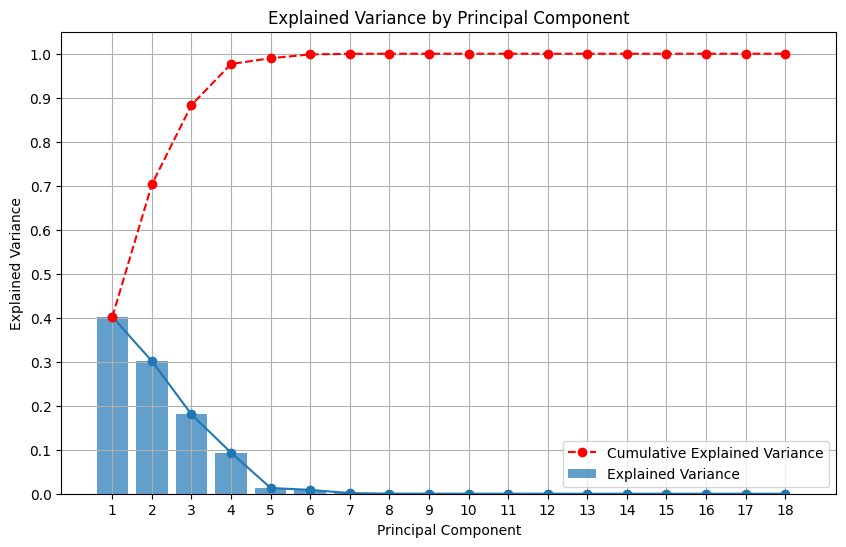

In [ ]:
plot_explained_variance(
    explained_variance,
    title='Explained Variance by Principal Component',
    x_label='Principal Component',
    y_label='Explained Variance',
    figsize=(10, 6)
)

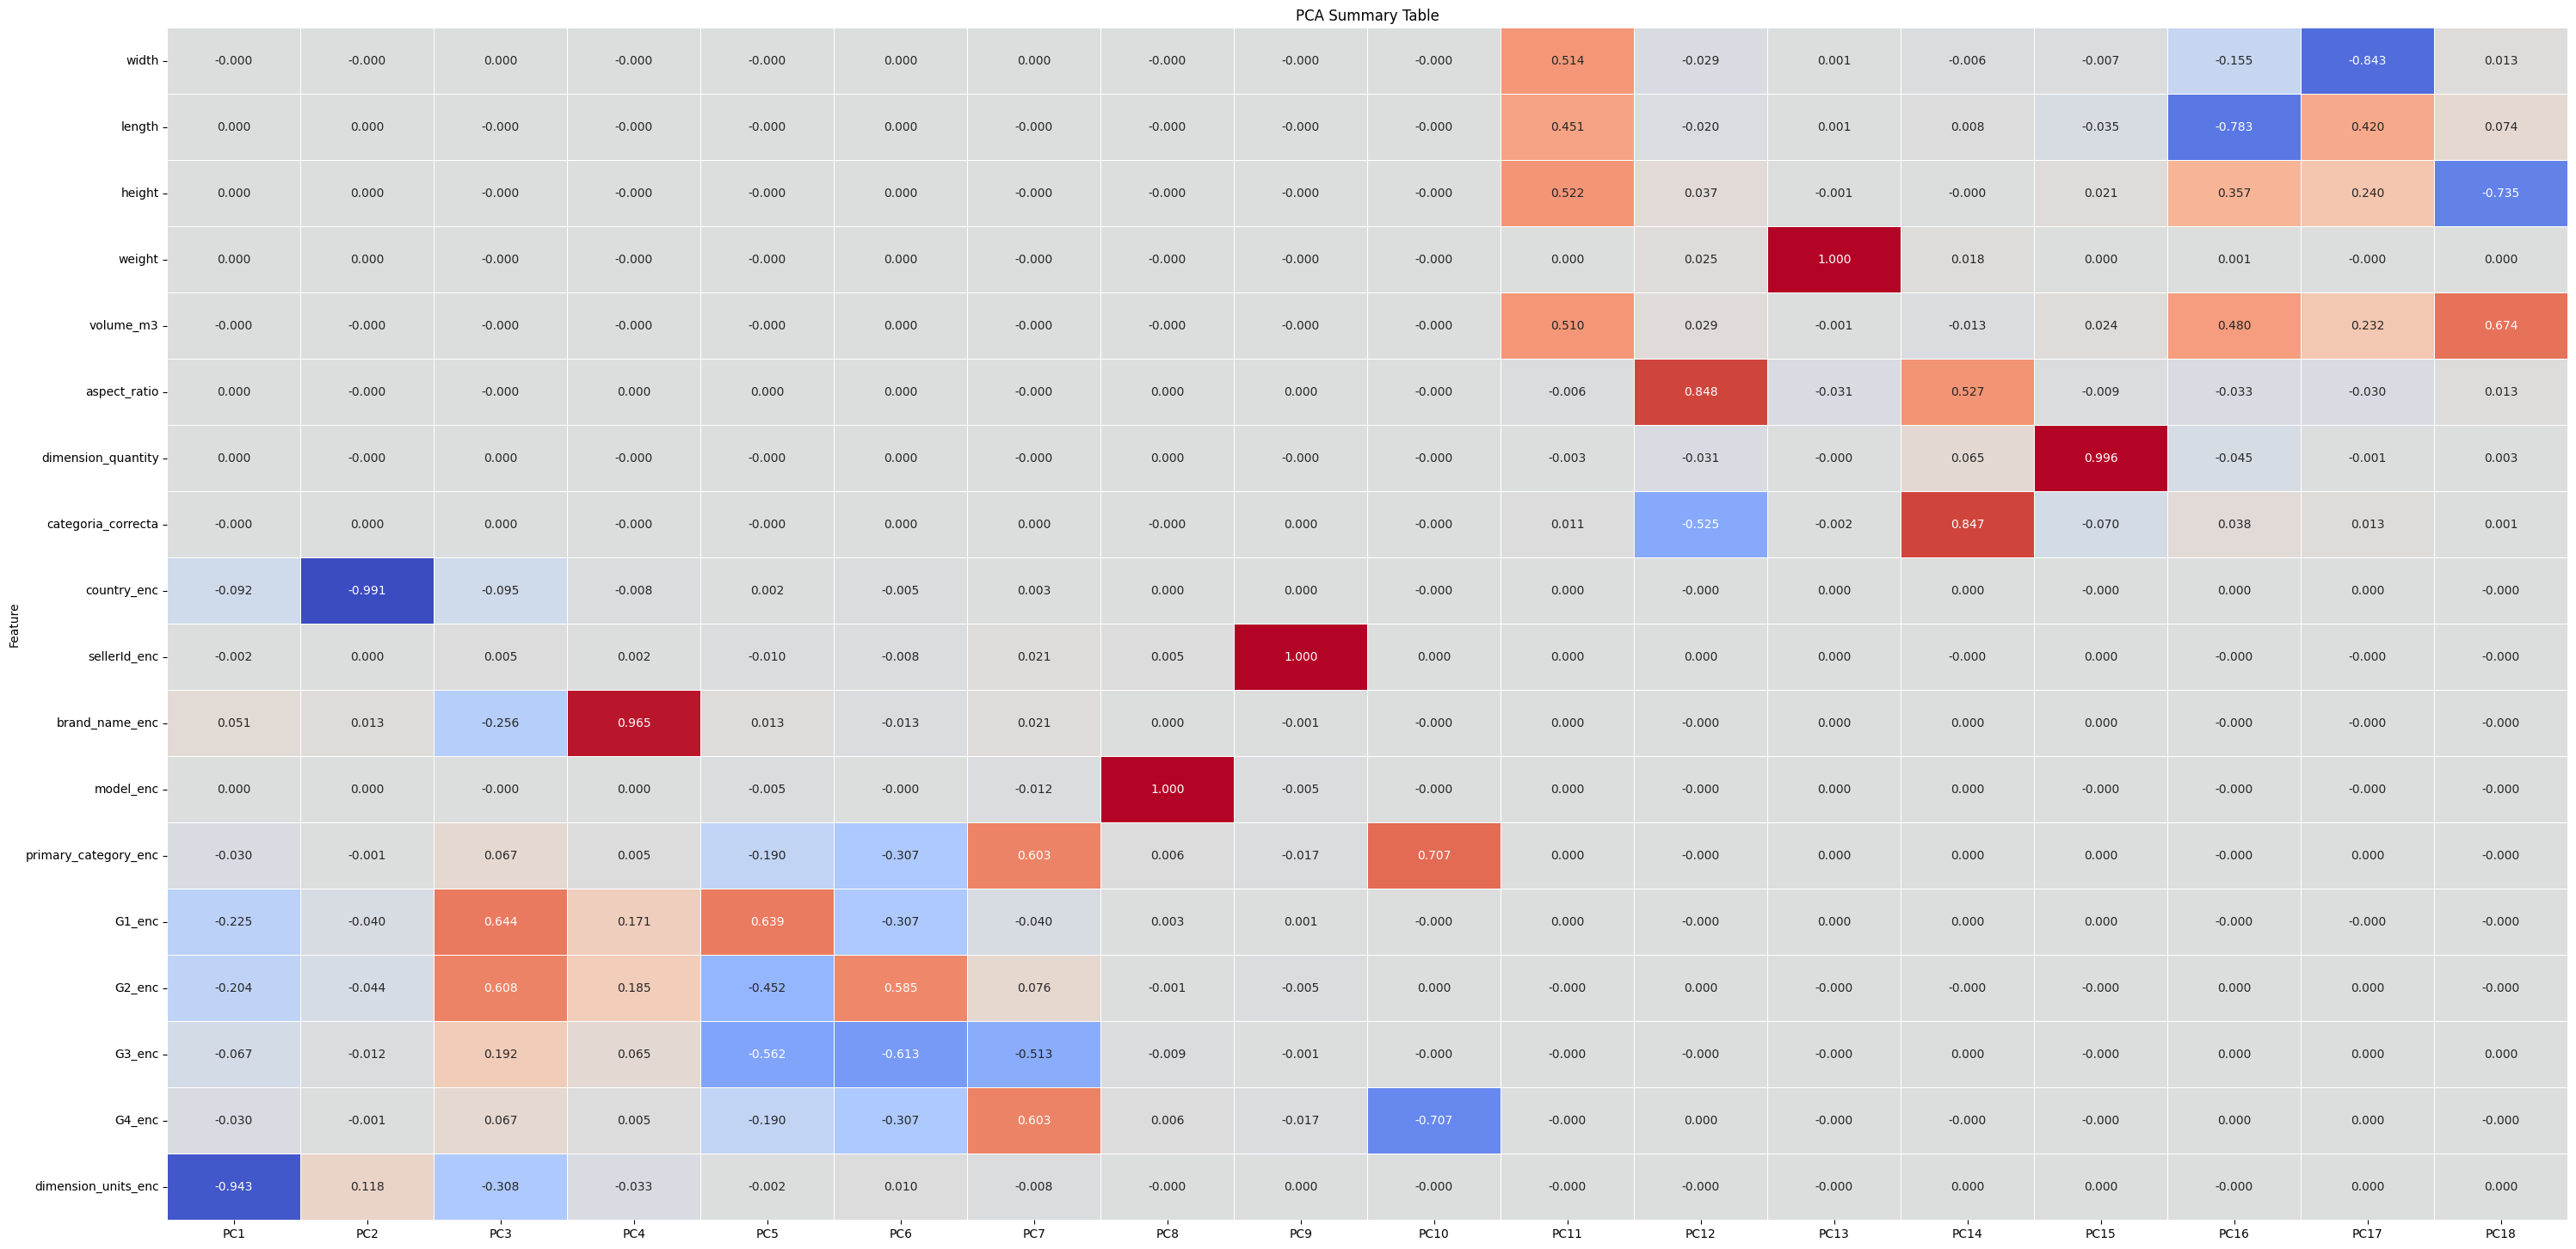

In [ ]:
pca_summary_table(num_cols, text_cols, principal_components)

### **Model training**

In [ ]:
#data_modelada.csv

In [ ]:
selected_features = [
                     'country_enc',
                     'sellerId_enc', 'brand_name_enc', 'model_enc',
                     'G1_enc', 'G2_enc', 'G3_enc', 'G4_enc',
                     'dimension_units_enc',
                     'dimension_quantity',
                     'categoria_correcta',
                     'weight','volume_m3','length'#,'aspect_ratio'
                    ] + product_text_cols #<- estas columnas generan OVERFIT!
target_feature = ['size']

X_train, y_train, X_valid, y_valid, X_test, y_test = prepare_train_data(df, selected_features, target_feature)

In [ ]:
# Class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

In [ ]:
model = tf.keras.Sequential([
              tf.keras.layers.Input(shape=(X_train.shape[1],)),
              #tf.keras.layers.Dense(512, activation='relu'),
              #tf.keras.layers.Dropout(0.4),
              tf.keras.layers.Dense(256, activation='relu'),
              tf.keras.layers.Dropout(0.4),
              tf.keras.layers.Dense(128, activation='relu'),
              #tf.keras.layers.Dropout(0.4),
              tf.keras.layers.Dense(64, activation='relu'),
              #tf.keras.layers.Dropout(0.4),
              tf.keras.layers.Dense(11, activation='softmax')
          ])

In [ ]:
# Compile model
#custom_learning_rate = 0.001
#custom_optimizer = Adam(learning_rate=custom_learning_rate)

model.compile(optimizer='adam', #custom_optimizer
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
              )

In [ ]:
# Train model
max_epochs = 20
batch_size = 32
history = train_model(model,
                      X_train, y_train,
                      X_valid, y_valid,
                      max_epochs,
                      batch_size#,
                      #class_weight_dict
                      )

Epoch 1/20
193134/193134 [==============================] - 610s 3ms/step - loss: 0.3837 - accuracy: 0.8759 - val_loss: 0.3391 - val_accuracy: 0.8881
Epoch 2/20
193134/193134 [==============================] - 581s 3ms/step - loss: 0.3500 - accuracy: 0.8856 - val_loss: 0.3118 - val_accuracy: 0.8954
Epoch 3/20
193134/193134 [==============================] - 581s 3ms/step - loss: 0.7244 - accuracy: 0.8892 - val_loss: 0.3043 - val_accuracy: 0.8991
Epoch 4/20
193134/193134 [==============================] - 583s 3ms/step - loss: 6.9932 - accuracy: 0.8908 - val_loss: 0.3074 - val_accuracy: 0.8951
Epoch 5/20
193134/193134 [==============================] - 588s 3ms/step - loss: 7.6564 - accuracy: 0.8920 - val_loss: 0.2908 - val_accuracy: 0.9019
Epoch 6/20
193134/193134 [==============================] - 592s 3ms/step - loss: 28.6821 - accuracy: 0.8929 - val_loss: 0.2914 - val_accuracy: 0.9013
Epoch 7/20
 23302/193134 [==>...........................] - ETA: 8:04 - loss: 0.3222 - accuracy: 0.

KeyboardInterrupt: 

In [ ]:
history_df = pd.DataFrame({
    'Epoch': range(1, len(history.history['accuracy']) + 1),
    'Training Loss': history.history['loss'],
    'Training Accuracy': history.history['accuracy'],
    'Validation Loss': history.history['val_loss'],
    'Validation Accuracy': history.history['val_accuracy']
})

history_df

NameError: name 'history' is not defined

### **Model evaluation**

#### **Test accuracy**

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

24142/24142 [==============================] - 47s 2ms/step - loss: 0.2860 - accuracy: 0.9020
Test Accuracy: 0.90


#### **Learning curves**

In [ ]:
plot_training_curves(history)

NameError: name 'history' is not defined

#### **Precision, Recall and F1**

In [ ]:
y_probs = model.predict(X_test)

24142/24142 [==============================] - 35s 1ms/step


In [ ]:
y_pred = np.argmax(y_probs, axis=1)

In [ ]:
y_test

array([9, 8, 8, ..., 7, 3, 7])

In [ ]:
inverse_transform_labels(y_test, label_encoder)

array(['XS3', 'XS2', 'XS2', ..., 'XS', 'M', 'XS'], dtype=object)

In [ ]:
calculate_precision_recall_f1(y_test, y_pred, size_order, size_order_encoded)

,Class,Precision,Recall,F1 Score
0,XS3,0.922728,0.983546,0.952167
1,XS2,0.922112,0.979406,0.949896
2,XS,0.807359,0.580778,0.675577
3,S,0.693178,0.198112,0.308153
4,M,0.844041,0.828141,0.836016
5,LO,0.769584,0.732944,0.750818
6,L,0.773310,0.363825,0.494840
7,XL,0.685621,0.699463,0.692473
8,XXL,0.681102,0.774716,0.724899
9,O,0.732855,0.619690,0.671538


#### **AUC-ROC**

In [ ]:
#num_classes = len(size_order_encoded)
#y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

In [ ]:
#auc_roc_per_class = []
#for i in range(num_classes):
#    auc_roc = roc_auc_score(y_test[i], y_pred[i])
#    auc_roc_per_class.append(auc_roc)

#average_auc_roc = np.mean(auc_roc_per_class)

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


In [ ]:
y_test

array([9, 8, 8, ..., 7, 3, 7])

Class 0: AUC-ROC = 0.9666077046892534
Class 1: AUC-ROC = 0.9866229401739467
Class 2: AUC-ROC = 0.9845087419788764
Class 3: AUC-ROC = 0.9833464244002664
Class 4: AUC-ROC = 0.979911034502222
Class 5: AUC-ROC = 0.9490446064382727
Class 6: AUC-ROC = 0.9960445081545973
Class 7: AUC-ROC = 0.9553976403441817
Class 8: AUC-ROC = 0.9912497440056517
Class 9: AUC-ROC = 0.9957602550531555
Class 10: AUC-ROC = 0.9941370779162395


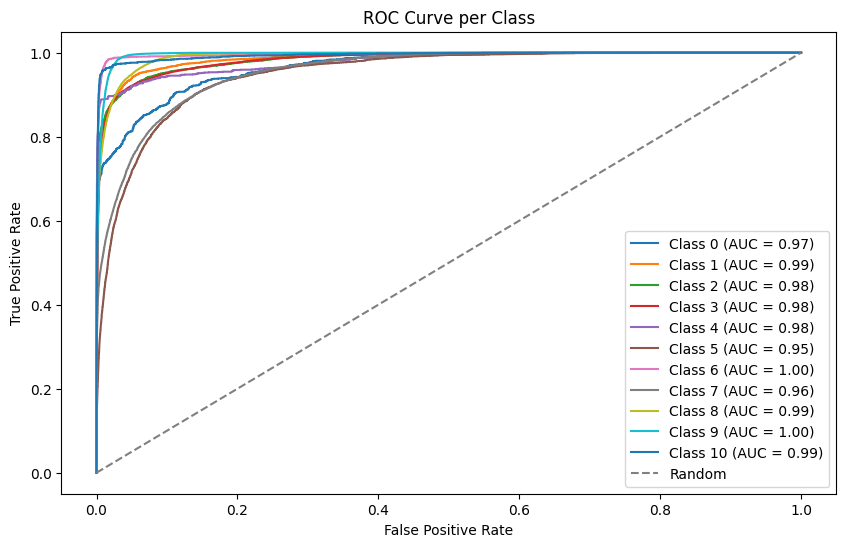

In [ ]:
# Initialize variables to store AUC-ROC scores and curves
class_auc_scores = []
fpr_dict = {}
tpr_dict = {}

# Iterate over each class
for i in range(len(size_order_encoded)):
    # Compute one-vs-rest ROC curve and AUC-ROC score
    fpr_dict[i], tpr_dict[i], _ = roc_curve(y_test == i, y_probs[:, i])
    class_auc_scores.append(auc(fpr_dict[i], tpr_dict[i]))

# Display AUC-ROC scores per class
for i in range(len(size_order_encoded)):
    print(f"Class {i}: AUC-ROC = {class_auc_scores[i]}")

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i in range(len(size_order_encoded)):
    plt.plot(fpr_dict[i], tpr_dict[i], label=f"Class {i} (AUC = {class_auc_scores[i]:.2f})")

plt.plot([0, 1], [0, 1], '--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Class')
plt.legend()
plt.show()

### **Save model**

In [ ]:
model.save('/content/gdrive/MyDrive/modelo_skus_regional_FINAL_27012024.keras')

In [ ]:
model.save('/content/gdrive/MyDrive/modelo_skus_regional_FINAL_27012024.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('/content/gdrive/MyDrive/modelo_skus_regional_FINAL_27012024.tf')

In [ ]:
files.download('/content/gdrive/MyDrive/modelo_skus_regional.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Production**

### **Load new data**

In [ ]:
new_df = data.copy()
#new_df = new_df[new_df['country']=='PE']
#new_df = new_df[new_df['G4'].isin(('G08010305','G19020305','G19020606','G21020409','G19080602'))]
#new_df = new_df[new_df['global_identifier'].isin(['G180201'])]
#new_df = new_df[new_df['primary_category']=='televisores']

### **Preprocess new data**

In [ ]:
new_df = drop_columns(new_df)

In [ ]:
new_df = fix_product_name(new_df)

In [ ]:
#new_df = new_df.assign(product_name = lambda x: x['product_name'].apply(transform_product_name))

In [ ]:
#new_df = (
#        new_df
#        .pipe(extract_dimension_units_and_quantity)
#        .pipe(fix_dimension_units_and_quantity)
#)

In [ ]:
new_df, product_text_cols = text_embedding(new_df)

In [ ]:
new_df, num_cols, text_cols = feature_engineering(new_df, product_text_cols)

In [ ]:
new_df = preprocess_outliers(new_df, approach='winsorize', winsorization_threshold=0.03)

In [ ]:
new_df = fix_size(new_df, size_order)

In [ ]:
new_df, label_encoder, size_order_encoded = label_encode_size(new_df)

In [ ]:
new_df = calculate_intervals(new_df, 0.1, 0.95)

### **Load model**

In [ ]:
# Load the trained model
production_model = keras.models.load_model('/content/gdrive/MyDrive/modelo_skus_regional_FINAL_27012024.keras')

### **Make predictions**

In [ ]:
selected_features = [
                     'country_enc',
                     'sellerId_enc', 'brand_name_enc', 'model_enc',
                     'G1_enc', 'G2_enc', 'G3_enc', 'G4_enc',
                     'dimension_units_enc',
                     'dimension_quantity',
                     'categoria_correcta',
                     'weight','volume_m3','length'#,'aspect_ratio'
                    ] + product_text_cols #<- estas columnas generan OVERFIT!
target_feature = ['size']

In [ ]:
X_new = new_df[selected_features]

scaler = StandardScaler()
X_new = scaler.fit_transform(X_new)



In [ ]:
predictions = production_model.predict(X_new)



403/403 [==============================] - 1s 1ms/step


In [ ]:
predictions_df = pd.DataFrame(predictions)
predictions_df.columns = size_order_encoded

predictions_target_df = pd.DataFrame(inverse_transform_labels(np.argmax(predictions, axis=1), label_encoder))
predictions_target_df.columns = ['predicted_size']



In [ ]:
final_df = (
    new_df
    .merge(predictions_target_df, left_index=True, right_index=True, how='inner')
    .merge(predictions_df, left_index=True, right_index=True, how='inner')
)

In [ ]:
# PRUEBA
#predict_from_data(df, selected_features, production_model, label_encoder, size_order_encoded)

In [ ]:
final_df.to_csv('/content/gdrive/MyDrive/final_df.csv')

In [ ]:
final_df = pd.read_csv('/content/gdrive/MyDrive/final_df.csv')

In [ ]:
televisores = final_df[final_df['primary_category']=='televisores']
televisores.to_csv('televisores.csv')

In [ ]:
# VER CASO 119562359 SCRIPT PYTHON MODIFICA LA DIMENSION_QUANTITY PORQUE???

In [ ]:
final_df.columns

Index(['Unnamed: 0', 'country', 'sellerId', 'sellerName', 'product_name',
       'shop_sku', 'brand_name', 'model', 'primary_category',
       'global_identifier',
       ...
       'L', 'LO', 'M', 'O', 'S', 'XL', 'XS', 'XS2', 'XS3', 'XXL'],
      dtype='object', length=112)

In [ ]:
electronica = final_df[final_df['global_identifier'].str.contains('^G19')]
electronica.to_csv('electronica.csv')

### **Download file**

In [ ]:
modelo_regional =  final_df.loc[:,
                    [
                        'country', 'sellerId', 'sellerName', 'sku_seller', 'product_name',
                        'brand_name', 'model',
                        'shop_sku',
                        'primary_category',
                        'global_identifier', 'G1', 'N1', 'G2', 'N2', 'G3', 'N3', 'G4', 'N4',
                        'status', 'created_at', 'updated_at',
                        'width', 'length', 'height', 'weight',
                        'width_in_cm', 'length_in_cm', 'height_in_cm', 'weight_in_kg',
                        'product_name_w1_enc', 'product_name_w2_enc', 'product_name_w3_enc', # Para validar
                        'dimension_quantity', 'dimension_units_enc', # Para validar
                        'size', 'predicted_size'
                    ]]

In [ ]:
modelo_regional.loc[:, ['country','sellerId','sellerName','sku_seller','product_name','width', 'length', 'height', 'weight', 'dimension_quantity', 'dimension_units_enc','size', 'predicted_size']]

,country,sellerId,sellerName,sku_seller,product_name,width,length,height,weight,dimension_quantity,dimension_units_enc,size,predicted_size
0,PE,SC41CBB,CORPORACION PORTAL,UN55AU7000-2,televisor samsung crystal uhd4k55in smart tv u...,123.0,25.0,79.0,15.0,55.0,9925,LO,M
1,PE,SC63F9F,ELECTRODOMESTICOS GALEXA,TVPHILIPS32BLES,tv philips32in smart hd border less hdd10,78.0,17.0,48.0,10.0,32.0,9925,M,XS3
2,PE,SC2BAF0,ELECTRODOMESTICOS JARED,32LN4100S-JARED,televisor imperial smart tv32in″ 32inln4100s,8.0,75.0,45.0,8.0,32.0,9925,M,XS3
3,PE,SC25E6C,ELECTRODOM,MAC1000DOM1393,televisor32in hyundai full hd hyled3248aim and...,8.0,46.0,31.0,9.1,32.0,9925,M,XS3
4,PE,SCBBDE6,RP INVERSIONES,SMG55CU8000,televisor samsung crystal uhd55in uhd4k smart ...,130.0,30.0,90.0,15.0,55.0,9925,LO,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5499,PE,SCC9507,THM STORE,WTV 55SVB,wolff smart tv55in ultra hd4k android11in.0 wi...,5.5,50.0,30.5,9.0,55.0,9925,M,XS3
5500,PE,SCA6101,LINEA CCENTER E.I.R.L,c73fae8a0ed54eda8dc843d53701eb85,televisor smart32in in webos tv,71.0,99.0,82.0,3.0,32.0,9925,L,XS3
5501,PE,SC6D2D7,IVANCE ELECTRONIC ONLINE,70NANO75SQA,televisor lg70in in. nanocell smart tv uhd4k t...,173.0,19.0,104.0,34.0,70.0,9925,XL,XS2
5502,PE,SCF3CD0,MERCADO PERU EIRL,CCH0871_DELETED_2023-10-12_18-11-48,televisor jvc40in lt40kb308 led fhd smart tv,55.0,95.0,12.0,7.0,40.0,9925,M,XS3


In [ ]:
modelo_regional.to_excel('modelo_regional.xlsx', index=False)

In [ ]:
modelo_regional.to_excel('/content/drive/MyDrive/modelo_regional.xlsx', index=False)

OSError: ignored

In [ ]:
files.download('/content/gdrive/MyDrive/modelo_regional.xlsx')

FileNotFoundError: ignored